# S&P 2019 Data Exploration Stage

**by Marc Angelo Acebedo**

# Table of Contents
- [Introduction](#introduction)
- [Data Setup & Overview](#setup)
- [Preliminary Wrangling](#prelim)
- [Exploration](#explore)
    - [Univariate](#uni)
    - [Bivariate](#bi)
    - [Multivariate](#multi)
- [Conclusions](#conclude)

# I) Introduction <a id = "introduction"> </a>


- I kept features in separate CSVs because date formats differ. `eps_fc` and `eps_act` 

### After cleaning the original dataset as documented in my data wrangling process [here](TK) tk, I isolated the following columns:

### `features.csv`
- **firm_id** : foreign key referring to primary keys in `firms.csv`
- **feature** : type of feature that the **value** field denotes (eps_fc, eps_act, eod_act, eps_fc_terms) 
- **date**    : DateTime object in YYYY-MM-DD format 
    - for **eod_act**, means the date at which the value was recorded
    - for **eps_fc_terms**, means the date at which the term forecast was made
- **term** :  period object in YYYYQQ format (the time period when the value was recorded)
    - FISCAL years for eps_fc and eps_act
    - CALENDAR years for eod_act and eps_fc_terms
- **value** : displays the EPS or EOD value as specified in the 'feature' column.

### `avgs.csv`
- **firm_id** : foreign key referring to the primary keys in `firms.csv`
- **average** : recorded average value as specified in the `average_type` column
- **average_type** : type of average denoted (twenty year, quarterly, or yearly)
- **time_period** : time period that the average is recorded:
    - for twenty-year averages, it's NaN
    - for yearly averages, displays the year (YYYY)
    - for quarterly averages, displays the quarter (QQ)
- **feature** : type of feature recorded for the average (eps_fc, eps_act, eod_act, eps_fc_terms)

# II) Data Setup & Overview<a id = "setup"></a> 

In [1]:
#import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import statsmodels.api as sm
import math 
import random
import calendar

from matplotlib import cm

%matplotlib inline
plt.style.use('bmh')

In [2]:
#define data directories
PATH_CLEAN = './data/clean/'
PATH_CLEAN_AVGS = './data/clean/averages/'

In [3]:
#define visuals destination
PATH_UNIVARIATE = './visuals/univariate/'
PATH_BIVARIATE = './visuals/bivariate/'
PATH_MULTIVARIATE = './visuals/multivariate/'

**Import features and all averages**

In [4]:
features = pd.read_csv(PATH_CLEAN + 'features.csv', low_memory = False)
avgs = pd.read_csv(PATH_CLEAN_AVGS + 'avgs.csv')

In [5]:
#import firm_ids for foreign key references
firm_ids = pd.read_csv(PATH_CLEAN + 'firms.csv')

### Describe Datasets

In [6]:
#look at 5 random entries
features.sample(5)

firm_id  feature        date    term   value
114595      378   eps_fc         NaN  2004Q4   0.326
138870      162  eps_act         NaN  2004Q3   0.250
149727      291  eps_act         NaN  2009Q4   2.190
159857      412  eps_act         NaN  2001Q2   0.500
15340       182  eod_act  2012-03-30  2012Q1  22.070

In [7]:
avgs.sample(5)

firm_id  average average_type time_period       feature
14819      174  0.34750       yearly        2003       eps_act
8732       147      NaN       yearly        2012        eps_fc
36049      194      NaN       yearly        2004  eps_fc_terms
39979       84  0.42175       yearly        2012  eps_fc_terms
22509      289  0.38000       yearly        2018       eps_act

In [8]:
print('FEATURES rows, columns = {}'.format(features.shape), '\n',
      'AVERAGES rows, columns = {}'.format(avgs.shape))

FEATURES rows, columns = (167660, 5) 
 AVERAGES rows, columns = (52015, 5)


### Convert DateTime columns

In [9]:
features.dtypes

firm_id      int64
feature     object
date        object
term        object
value      float64
dtype: object

In [10]:
features.date = pd.to_datetime(features.date)
features.term = pd.to_datetime(features.term).dt.to_period('Q')

In [11]:
#verify dtypes
features.dtypes

firm_id             int64
feature            object
date       datetime64[ns]
term        period[Q-DEC]
value             float64
dtype: object

In [12]:
avgs.dtypes

firm_id           int64
average         float64
average_type     object
time_period      object
feature          object
dtype: object

In [13]:
features.sample(5)

firm_id  feature       date    term   value
137932      151  eps_act        NaT  2001Q1   1.830
164162      463  eps_act        NaT  2006Q3   0.670
110055      324   eps_fc        NaT  2003Q4   0.638
20922       249  eod_act 2000-09-29  2000Q3  28.500
94201       135   eps_fc        NaT  2009Q2  -0.273

# III) Preliminary Exploration <a id = "prelim"></a>

### Structure of the Datasets
> Our `features.csv` dataset contains 167,660 entries with 5 features. Firm ID, feature, date, and term are all categorical variables while the value field is numeric and continuous. Even though the date and term fields are recorded as DateTime and Period objects respectively, they are still discrete, categorical data, because there is a limit to the year that can be recorded (1999 - 2020) and there cannot be more than 4 quarters (Q1 - Q5).

> Our `avgs.csv` dataset contains 52,015 entries with 5 features. Firm ID, average type, time period, and feature are all categorical variables while the average field is numeric and continuous. 


### Main features(s) of interest in the dataset

> I'm interested in seeing the ***historical correlation of forecasted vs. actual EPS across all firms in the 2019 S&P Index.***

- **eps_fc**, **eps_act** are the main variables of interest—they are consistent in measuring both the *forecasted* and *actual* EPS of all 505 firms, per fiscal period, over a span of 20 years.
- **eod_act** is recorded based on ***calendar period*** instead of fiscal period, which is a flaw in the data. However, it can be used for some further exploration.
- **eps_fc_terms** is based on ***calendar period***. Although it depicts forecasted EPS, this is still not a main variable of interest because it can *extend* my main research question, but not fully answer it.

> As somebody with very little familiarity with the stock market, I decided to dedicate this thesis project to my exploration of a field I am not familiar with.. I read the book "A Beginner's Guide to the Stock Market" by Matthew R. Kratter, which piqued my interest in stock market trading—particularly dividend stocks. I decided that if I were going to educate myself further on the stock market, then this thesis project to end my senior year at NCF would be a perfect opportunity to directly explore this new interest. Not only would I be educating myself on how the stock market works, but I would also be *working directly with stock market data*, which will help me build further intuition in future stock market and finance-related projects.

These are the questions I'd like to pose in my exploratory stage:

- Do forecasters' predictions become more accurate by the quarter?
- I generate "dumb EPS forecasts" by taking the rolling mean of the previous 2 actual EPS values before the current term (YYYYQQ). How do these "dumb EPS forecasts" compare to the experts' EPS forecasts?
- What differences emerge when analyzing the prediction error and percentage error of EPS forecasts?
- For both the top most inaccurately predicted companies, do EPS forecasts show a pessimistic and/or optimistic view of their company value?

### Features in the dataset that will support my investigation into the features of interest

> For the broadest overview, I predict that ***overtime, EPS forecasts will continually become optimistic for those firms that consistently have high actual EPS values. Vice versa, overtime, EPS forecasts will continually become pessimistic for those firms that consistently have lower-than-expected EPS values.*** As for the other factors, I expect yearly values to show more consistency in pattern (since it is more intuitive to measure 20 years) than quarterly values (since economic situations are greatly diverse over the period of 20 years, no matter the period).

# IV) Exploration <a id="explore"> </a>

## A) Univariate <a id = "uni"></a>

### MISSING VALUES (Features)

In [14]:
sb.set(style = "darkgrid")

In [15]:
def generate_missing_total(df, title_name, save_path, csv_name):
    plt.figure(figsize = [10, 5])
    plt.title('Missing Values per Column under ' + title_name, size = 20)
    na_counts = df.isna().sum().sort_values(ascending = True)
    
    na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
    plt.xlabel('Count', size = 10)
    plt.ylabel('Column Name', size = 10)
    plt.savefig(save_path + csv_name)

In [16]:
features.isna().any()

firm_id    False
feature    False
date        True
term       False
value       True
dtype: bool

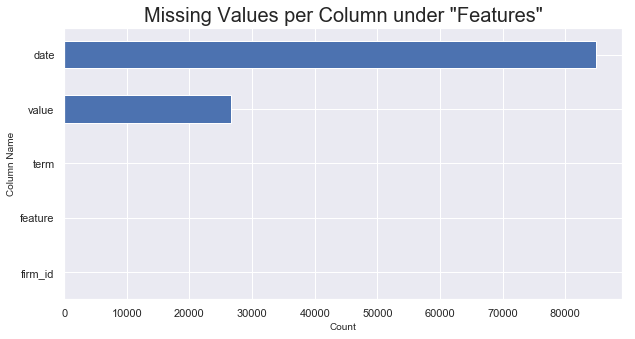

In [17]:
generate_missing_total(features, '"Features"', PATH_UNIVARIATE, 'features-missing-total.png')

**Observation 1:** `date` is the field with the highest amount of missing data, with around **85,000 missing entries.**

**Observation 2:** `value` contains around **26,000 missing entries.***

**Observation 3:** The gap in number of missing values between *value* and *date* is noticeably large.
- This makes sense because *date* is automatically set to 'NaT' for *eps_fc* and *eps_act*.

--- 

**Questions**

1)  For all the entries where *date* is not NaT, how large is the gap in missing values between *values* without the dropped dates and *values* with the dropped dates?

In [18]:
features_date_dropna = features[features['date'].notna()]

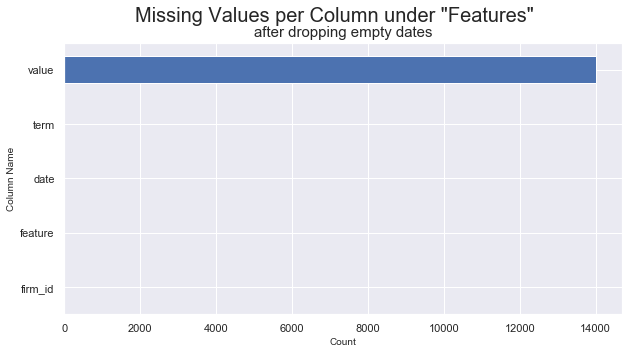

In [19]:
plt.figure(figsize = [10, 5])
plt.suptitle('Missing Values per Column under "Features"', size = 20)
plt.title('after dropping empty dates', size = 15)
na_counts = features_date_dropna.isna().sum().sort_values(ascending = True)

fig = na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
plt.constrained_layout = True
plt.xlabel('Count', size = 10)
plt.ylabel('Column Name', size = 10)
plt.savefig(PATH_UNIVARIATE + 'features-missing-date-dropna.png')

### Question 1: For all the entries where *date* is not NaT, how large is the gap in missing values between *values* without the dropped dates and *values* with the dropped dates?
### Answer

**Observation 1:** Keeping NaT dates, the amount of overall missing values is around **26,000**. After dropping all the NaT dates (dropping `eod_act`and `eps_fc_terms`), the amount of missing values dropped to around **14,000.**

**Observation 2:** Drawing from the previous observation, this means that `eps_fc` and `eps_act` both have around **12,000** missing values in total.

**Observation 3:** Effectively, the undropped columns, `eod_act` and `eps_fc_terms`, have around **14,000** missing values in total.

---

**Questions:**

2) How many missing values does each feature have, individually?

In [20]:
#turn feature values into index values
features_num_nan = features[['feature', 'value']].groupby('feature').count()

In [21]:
#count number of total values (NaN or not) per feature
feature_counts = features.feature.value_counts()

In [22]:
#create function to calculate number NaN
def calculate_nan(num_nan, counts, feature_name):
    num_nan.loc[feature_name] = counts[feature_name] - num_nan.loc[feature_name]
    #num NaN (feature) = num all values (NaN or not) - num all values (not NaN)
    
#create array of feature names
feature_names = ['eps_fc', 'eps_act', 'eod_act', 'eps_fc_terms']

In [23]:
#update all nan counts per average type
for feature_name in feature_names:
    calculate_nan(features_num_nan, feature_counts, feature_name)

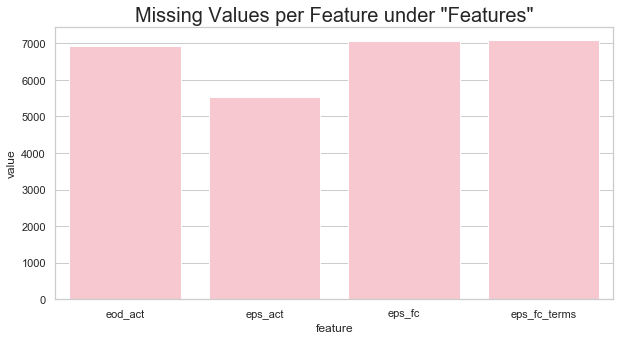

In [24]:
plt.figure(figsize = [10, 5])
sb.set(style = 'whitegrid')
plt.title('Missing Values per Feature under "Features"', size = 20)
plt.xlabel('Feature')
plt.ylabel('Count')

sb.barplot(x = features_num_nan.index, y = features_num_nan.value, color = "pink")
plt.savefig(PATH_UNIVARIATE + 'features-missing-per-feature.png')

**Observation 1:** The feature with the most amount of missing values is `eps_fc_terms`.

**Observation 2:** The feature with the least amount of missing values is `eps_act`.

**Observation 3:** `eod_act`, `eps_fc`, and `eps_fc_terms` all have a very small gap in missing data comparedto `eps_act`

### Question 2: How many missing values does each feature have, individually?

### Answer:

**Observation 1:** Below is a list of each feature and their corresponding estimated number of missing values:

- `eod_act` : 7900
- `eps_act` : 5500
- `eps_fc` : 7050
- `eps_fc_terms` : 7100

**Observation 2:** `eps_fc` and `eps_act` have around 12,000 missing values total, which is consistent with our previous observation.

**Observation 3:** `eod_act` and `eps_fc_terms` have around 14,000 missing values total, which is also consistent with our previous observation.



### MISSING VALUES (Averages)

In [25]:
avgs.isna().any()

firm_id         False
average          True
average_type    False
time_period      True
feature         False
dtype: bool

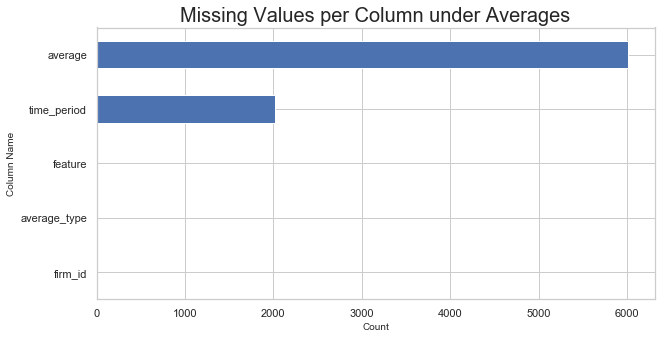

In [26]:
#averages
generate_missing_total(avgs, 'Averages', PATH_UNIVARIATE, 'avgs-missing-total.png')

**Observation 1:** The *average* column contains 6,000 missing data entries.

**Observation 2:** The *time_period* column contains exactly 2,000 missing data entries.

**Observation 3:** The gap in missing values between *average* and *time_period* is 4,000. 

**Observation 3:** By default, all entries with *average_type* of **twenty_year** should have **NaT** fields for *time_period*. 

---

**Questions:**

3) After dropping all NaT fields under *time_period*, how large will the gap in missing values be between *values with the NaT dates* and *values after dropping the NaT dates*?

4) How many missing *average* values does each *average_type* contain?



In [27]:
avgs_date_dropna = avgs[avgs['time_period'].notna()]

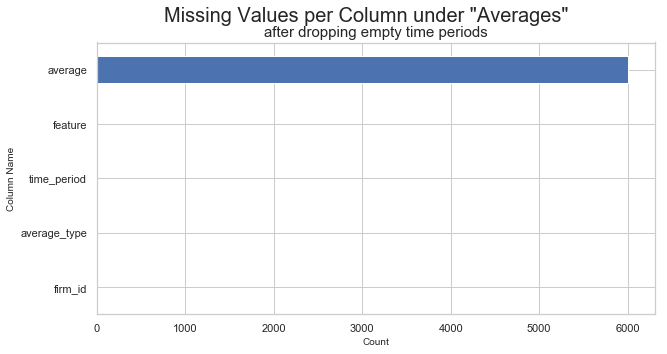

In [28]:
plt.figure(figsize = [10, 5])
plt.suptitle('Missing Values per Column under "Averages"', size = 20)
plt.title('after dropping empty time periods', size = 15)
na_counts = avgs_date_dropna.isna().sum().sort_values(ascending = True)

fig = na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
plt.constrained_layout = True
plt.xlabel('Count', size = 10)
plt.ylabel('Column Name', size = 10)
plt.savefig(PATH_UNIVARIATE + 'avgs-missing-date-dropna.png')

### Question 3:  After dropping all NaT fields under time_period, how large will the gap in missing values be between values with the NaT dates and values after dropping the NaT dates?

### Answer: 
**Observation 1:** After dropping all NaT dates under *time_period*, there are still 6,000 missing *averages*. This is number is consistent with the number of missing *averages* even before dropping NaT dates. Thus, **all entries with a missing time period** (aka all **twenty_year** average types) **did not contain any empty data.**

**To summarize the above, the number of missing *average values* remains the same whether or not you drop all entries with empty time periods, aka all twenty_year average types.**

In [29]:
#turn avg values into index values
avgs_num_nan = avgs[['feature', 'average']].groupby('feature').count()

In [30]:
#count number of total values (NaN or not) per feature
avgs_counts = avgs.feature.value_counts()

In [31]:
#update number of missing values for each average type
for feature_name in feature_names:
    calculate_nan(avgs_num_nan, avgs_counts, feature_name)

In [32]:
avgs_num_nan

average
feature              
eod_act          1539
eps_act          1255
eps_fc           1655
eps_fc_terms     1562

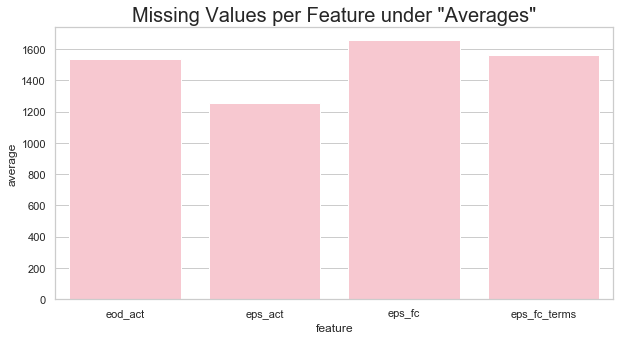

In [33]:
plt.figure(figsize = [10, 5])
# sb.set(style = 'whitegrid')
plt.title('Missing Values per Feature under "Averages"', size = 20)
plt.xlabel('Feature')
plt.ylabel('Count')

sb.barplot(x = avgs_num_nan.index, y = avgs_num_nan.average, color = "pink")
plt.savefig(PATH_UNIVARIATE + 'avgs-missing-per-feature.png')

**Observation 1:** *eps_fc* has the most missing values at around 1650.

**Observation 2:** *eps_act* has the least amount of missing values at around 1250.

**Observation 3:** Under "Averages", the gap in missing values between each average type is ***larger*** than the missing values under "Features".

### Answer:

**Observation 1:** Each average type has the following *approximate* number of ***missing averages***:

- `eod_act` : 1550
- `eps_act` : 1250
- `eps_fc` : 1650
- `eps_fc_terms` : 1590

In [34]:
#turn avg values into index values
avgs_num_avg = avgs[['average_type', 'average']].groupby('average_type').count()

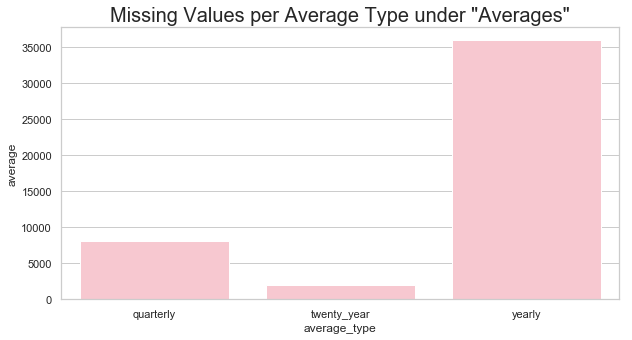

In [35]:
plt.figure(figsize = [10, 5])
# sb.set(style = 'whitegrid')
plt.title('Missing Values per Average Type under "Averages"', size = 20)
plt.xlabel('Average Type')
plt.ylabel('Count')

sb.barplot(x = avgs_num_avg.index, y = avgs_num_avg.average, color = "pink")
plt.savefig(PATH_UNIVARIATE + 'avgs-missing-per-avg-type.png')

### Question 4: How many missing average values does each average_type contain?

### Answer:

**Observation 1:** 

- `quarterly`: ~7500
- `twenty_year`: ~2500
- `yearly`: ~3600

**Observation 2:** The gap in missing values is greatly diversified across all average types.

### FIRM_ID (Features)

> Since 505 firms is too much to fit into one single visual, I decided to split them apart by focusing on the ***20 most common firm ids*** and the ***20 rarest firm ids***.

In [36]:
def generate_pct_bar(df, cat_var, color):
    cat_counts = df[cat_var].value_counts()
    ax = sb.countplot(data = df, y = cat_var, order = cat_counts.index, palette = color)
    
    n_points = df.shape[0]
    locs, labels = plt.yticks()
    
    for p in ax.patches:
        percentage = '{:0.1f}%'.format(100 * p.get_width()/n_points)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), size = 20)

In [37]:
features_firm_id_top = features.firm_id.value_counts()[:20].index
features_firm_id_top_lim = features.loc[features.firm_id.isin(features_firm_id_top)]

#check there are only 50 unique values
features_firm_id_top_lim.firm_id.nunique()

20

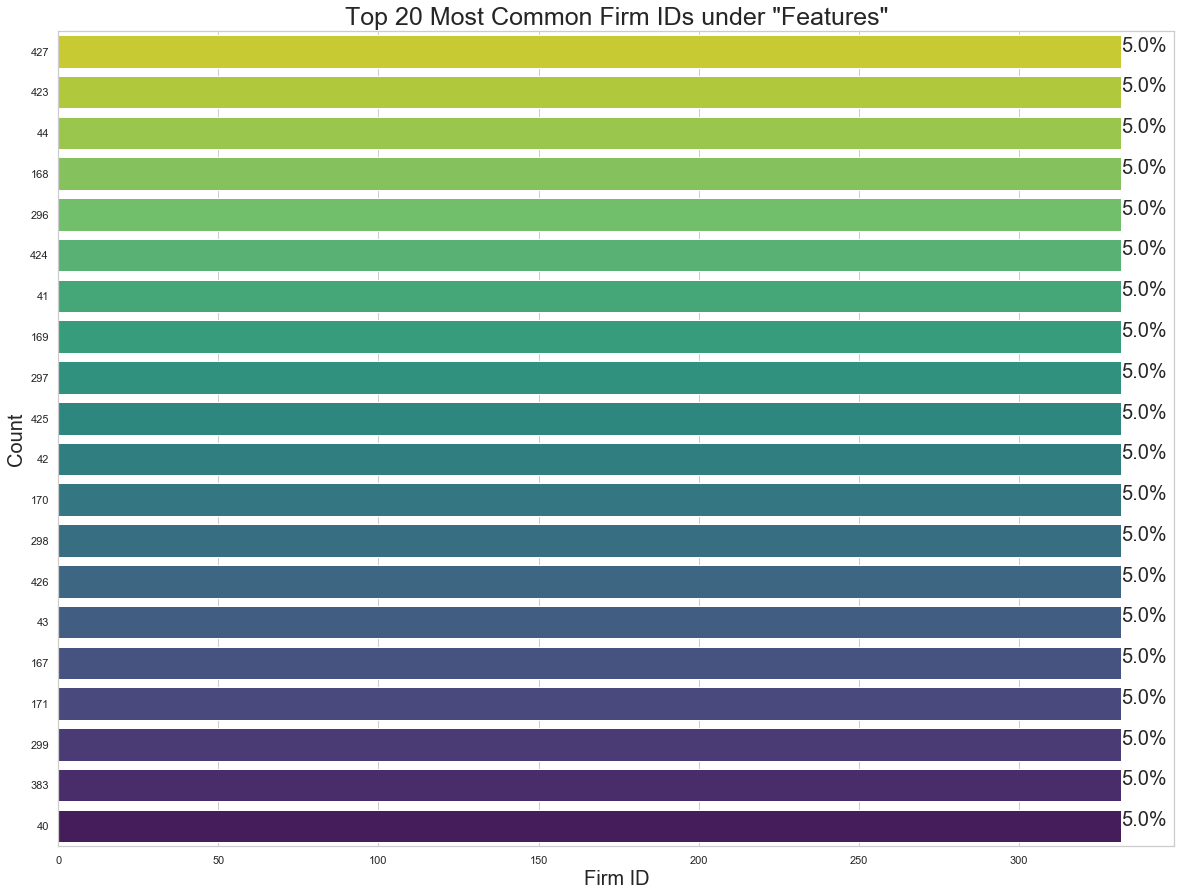

In [38]:
plt.figure(figsize = [20, 15])
x = features_firm_id_top_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('Top 20 Most Common Firm IDs under "Features"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'features-firm-id-count-top.png');
plt.show();

In [39]:
features_firm_id_bottom = features.firm_id.value_counts()[-20:].index
features_firm_id_bottom_lim = features.loc[features.firm_id.isin(features_firm_id_top)]

#check there are only 50 unique values
features_firm_id_bottom_lim.firm_id.nunique()

20

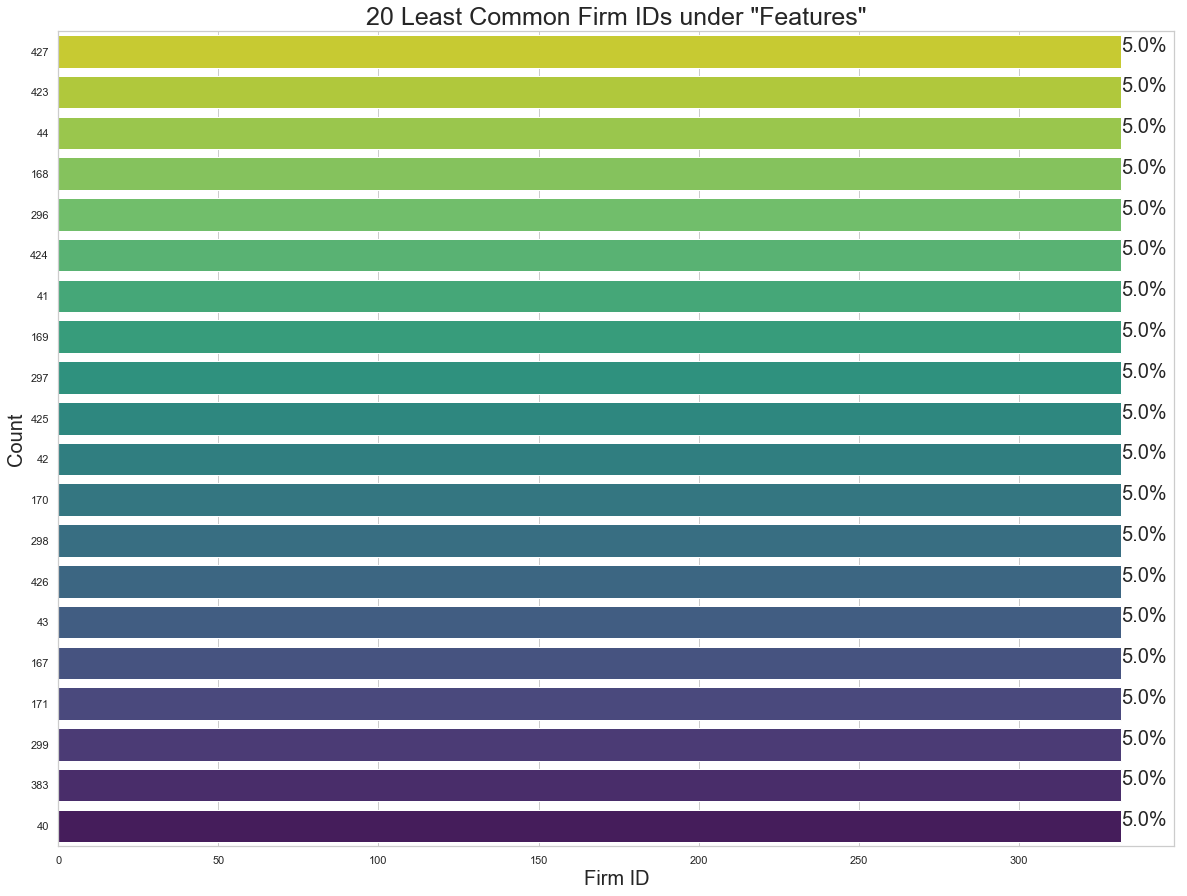

In [40]:
plt.figure(figsize = [20, 15])
x = features_firm_id_bottom_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('20 Least Common Firm IDs under "Features"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'features-firm-id-count-bottom.png');
plt.show();

**Observation 1:** Both the 20 most common and least common Firm IDs all make up the same proportion of existing Firm IDs: 5.0% each. This means that under "Features", there is a **consistent count among all Firm IDs** at around 335.

In [41]:
#check consistency of counts among firm_ids
firm_counts = features.firm_id.value_counts()
np.unique(firm_counts.sort_values().values)

array([332], dtype=int64)

> I discovered that ***all firm id counts are consistent across the entire features.csv dataset*** at 332 entries per firm id. There are no null firm ids.

### FEATURE (Features)

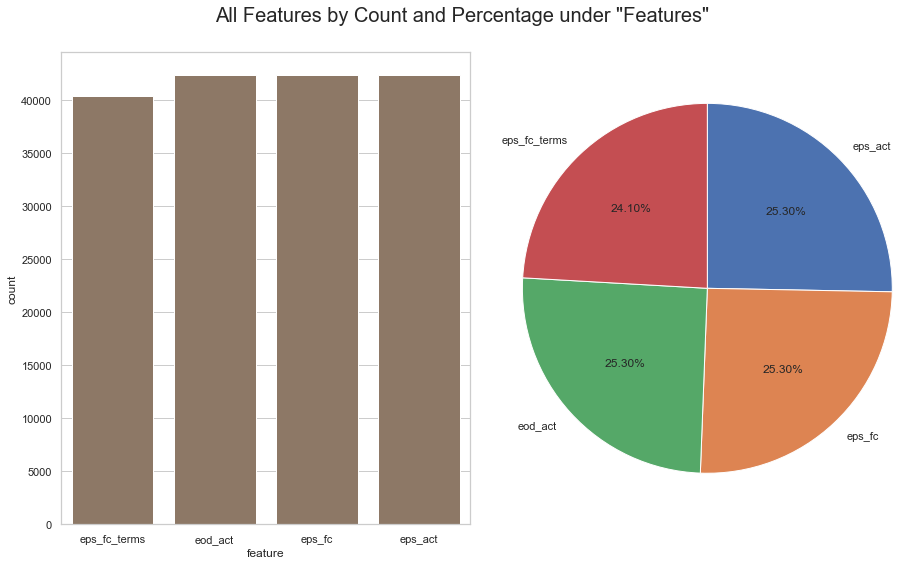

In [42]:
import itertools
plt.figure(figsize = [13, 8])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
sb.countplot(data = features, x = 'feature', order = features.feature.value_counts(ascending = True).index,
            color = base_color)
frame = plt.gca()

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = features['feature'].value_counts()
plt.pie(features.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = features.feature.value_counts().index);
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Features"', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'features-feature-pct-count.png')


**Observation 1:** `eps_act`, `eps_fc`, and `eod_act` all show consistent counts at around 42500 entries each (25.30% each).

**Observation 2:** `eps_fc_terms` is the only *feature type* to deviate from the others, having less entries at around 41,000 (24.10%).

**Observation 3:** It makes sense that `eps_fc_terms` contains missing data, because ***the year 1999 was not included while gathering this data.*** (effectively removing 2020 entries).

### DATE (Features)

In [43]:
#double check that eps_fc and eps_act are the only features to have null Date entries
features[features.date.isna()].feature.unique()

array(['eps_fc', 'eps_act'], dtype=object)



> Since we acknowledged that the `date` column is set to NaT for `eps_fc` and `eps_act`, we will write all our interpretations accordingly.

### All below graphs under "Date" do not take into account the features `eps_fc` and `eps_act`.

In [44]:
features_years = features.date.dt.year.dropna().astype(int)
features_months = features.date.dt.month.dropna().astype(int)

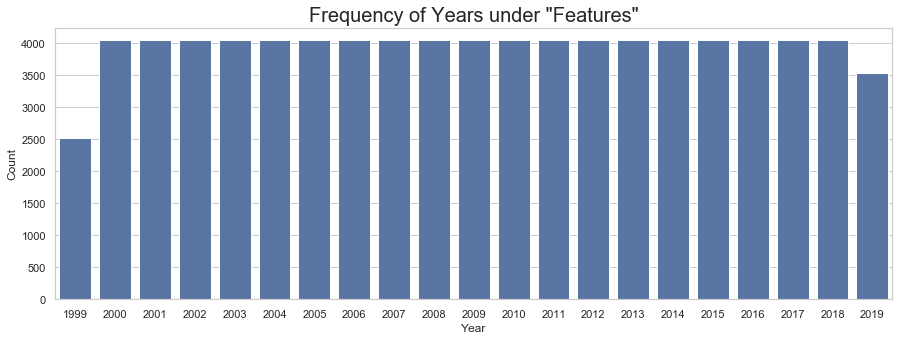

In [45]:
#years
plt.figure(figsize = [15, 5])

ax = sb.countplot(x = features_years, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Years under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-years-count.png')
plt.show()

**Observation 1:** All years between 2000 - 2018 have a consistent count at around 4,000 for all firms. 
- This makes sense, because the year 1999 is missing from all `eps_fc_terms` entries.

**Observation 2:** The years 1999 and 2019 are both *inconsistent* and *less than* the number of 4,000 counts for all other Date years.

**Observation 3:** The year 1999 has 2500 non-null entries.

**Observation 4:** The year 2019 has 3500 non-null entries.

In [46]:
#months
features_months = features_months.apply(lambda x: calendar.month_abbr[x])
months_order = ['Jan', 'Mar', 'Apr', 'Jun', 'Jul', 'Sep', 'Oct', 'Dec']

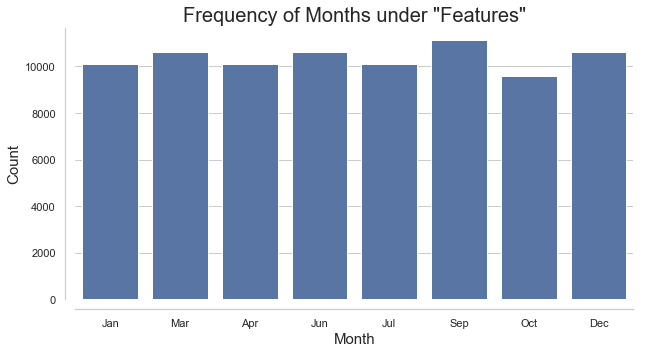

In [47]:
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features_months, color = sb.color_palette()[0], order = months_order)
ax.set(xlabel = 'Month', ylabel = 'Count')
ax.set_title('Frequency of Months under "Features"', size = 20)
sb.despine(offset = 10, trim = False)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-months-count.png')
plt.show();

**Observation 1:** September has the most number of counts at around 15,000.

**Observation 2:** October has the least number of counts at around 9,000.

**Observation 3:** The trend in counts of months under "Date" fluctuates. It is not a linear or exponential pattern; it seems that there is a "peak" in counts every 2nd *recorded* month from January.
- For example, March peaks at around 11,000 counts, then June peaks at around 10,500 counts, and Septemberat around 15,000.



### It is safe to conclude that the "Date" column is unreliable when *examining terms and years*, and should be avoided. It is better to use the "Date" column *only* when referring to specific dates.

### TERM (Features)

> As noted earlier, there are no missing values under the Term column. Therefore, all graphs below do account for `eps_act` and `eps_fc`.

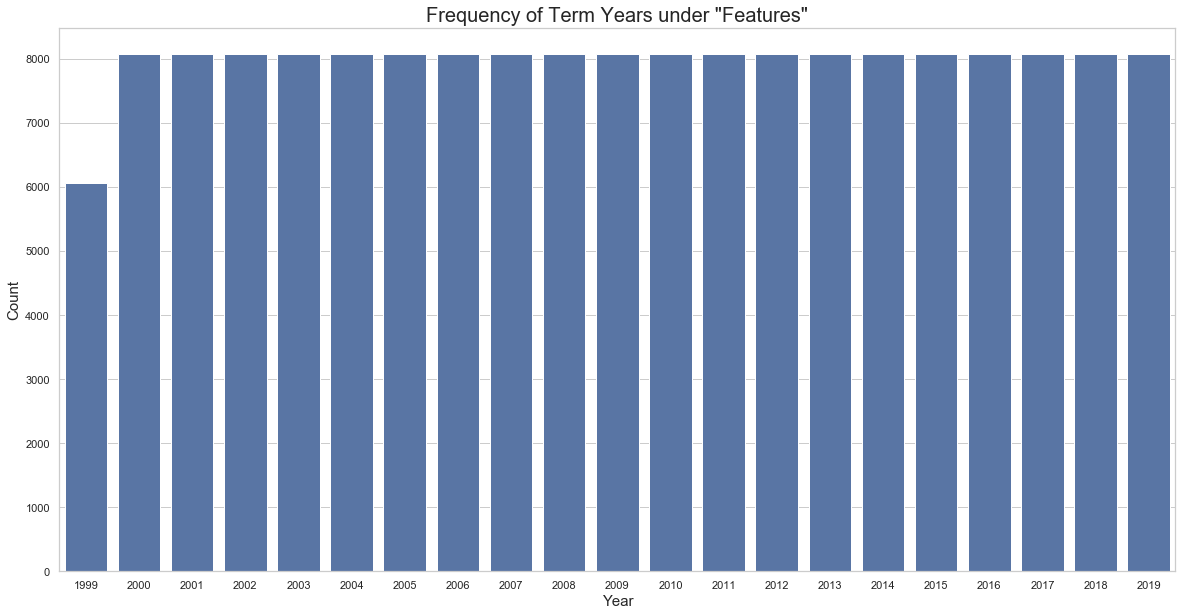

In [48]:
#years
plt.figure(figsize = [20, 10])

ax = sb.countplot(data = features, x = features.term.dt.year, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Term Years under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-years-count.png')
plt.show();

**Observation 1:** All years from 2000 to 2019 have consistent counts at 8,000 per year.

**Observation 2:** Unlike the years under Date, 1999 is the only year that does not follow the general trend. There are 6000 recorded entries containing 1999. This means that *2,000 entries do not contain the year 1999*.

---

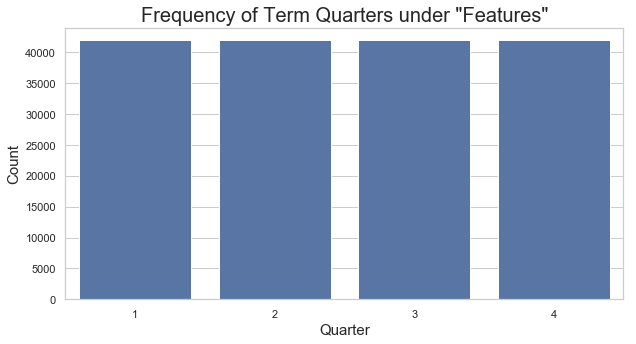

In [49]:
#quarter
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features.term.dt.quarter, color = sb.color_palette()[0])
ax.set(xlabel = 'Quarter', ylabel = 'Count')
ax.set_title('Frequency of Term Quarters under "Features"', size = 20)

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-quarters-count.png')
plt.show();

**Observation 1:** There is a consistent number of ***quarters*** under **term**, unlike years.

**Observation 2:** This means that *quarters* is a more stable, reliable variable to examine under **Term** unlike *years*, which should be examined more closely in regard to which feature(s) contains that year.

### VALUE (Features)

In [50]:
def generate_hist(df, x, bins, title, xlabel, ylabel, save_path, csv_name):
    plt.figure(figsize = [14, 7])
    
    plt.hist(data = df, x = x, bins = bins, color = 'palevioletred')
    plt.title(title, size = 25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.savefig(save_path + csv_name)

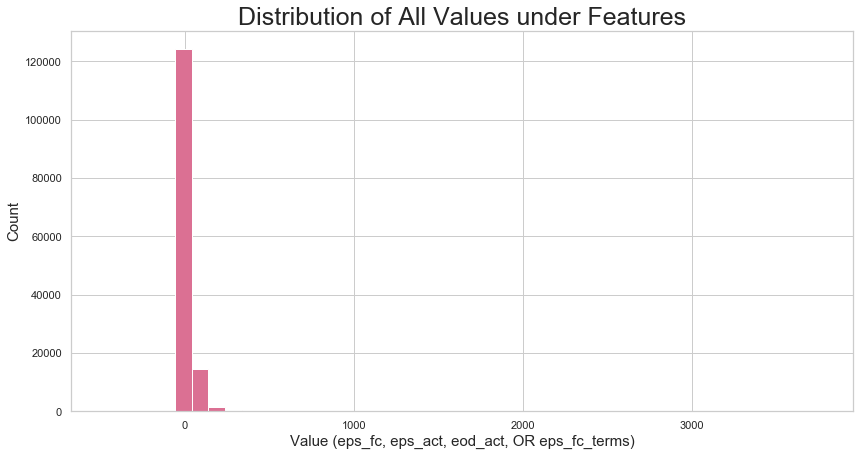

In [51]:
value_bins = np.arange(features.value.min(), features.value.max() + 100, 100)
generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist.png')

**Observation 1**: The trend in value counts is ***heavily right-skewed***

**Observation 2:** The value range 0-100 contains the highest concentration of data, with over 120,000 entries.

**Observation 3:** The value range 0-300 contains the "bulk" of all the data, which means the surrounding x-axis values are all outliers. 

---

**Questions:**

4) How do value counts under Features look like after removing all outliers around the value range 0-300?

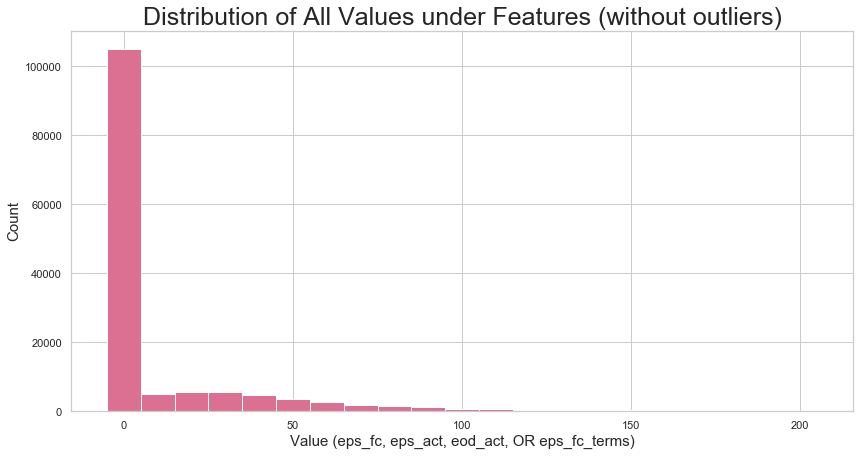

In [52]:
value_bins = np.arange(-5, 200 + 10, 10)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (without outliers)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom-1.png')

### Question 5: How do value counts under Features look like after removing all outliers around the value range 0-300?
**Observation 1:** The graph appears to be a normal distribution with a ***strong right skew.*** This is still unlike the graph *with* all the outliers, where the right skew is much more pronounced and prominent.

**Observation 2:** Instead of breaking the bins up by bin widths of 100, the bin width here is 10.

**Observation 3:** The value range 0-10 contains the **bulk** of all the data. This is the **highest bar**, with counts of around 12,000.
- The previous graph showed that the bin range 0-100 contains around 120,000 points.
- This graph shows that the bin range 0-10 contains around 120,000 points.
- Drawing from the previous 2 observations, we can conclude that ***it's really the bin range 0-10 that contains the bulk of all the data***.

### It would be a good idea to break down the 0-10 bin range even further, and examine solely that range.

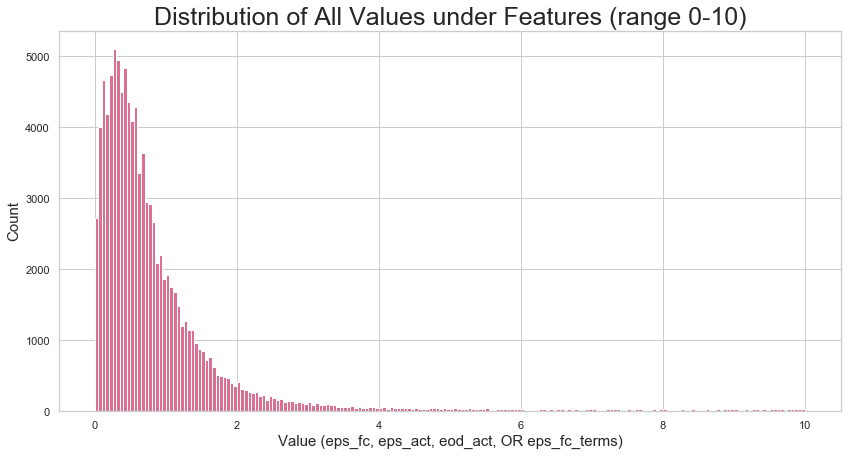

In [53]:
value_bins = np.arange(0, 10 + 0.05, 0.05)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (range 0-10)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom-2.png')

**Observation 1:** The graph, even when zoomed in, still retains a strong right skew.

**Observation 2:** The "bulk" of the data is around the value range **0.02 to 0.05: the "peak" of the distribution.**

 

> Just to make sure this graph is skewed heavily to the right, let's create a kernel density curve:

In [54]:
def generate_distplot(data, bins):
    fig = plt.figure(figsize = [14, 7])
    ax = sb.distplot(data, bins = bins, color = 'hotpink')
    ax.minorticks_on()
    return fig, ax

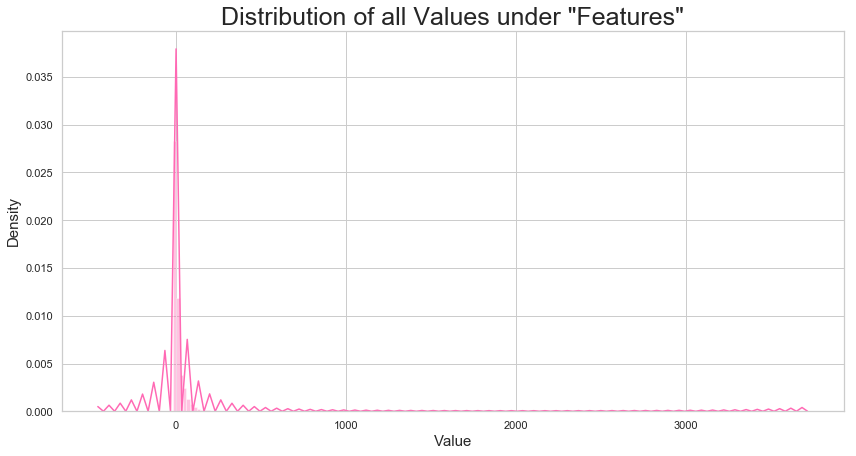

In [55]:
value_bins = np.arange(features.value.min(), features.value.max() + 20, 20)
generate_distplot(features.value.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'features-value-dist.png')

**Observation:** As shown by the kernel density curve, the distribution of `values` under Features is heavily right-skewed. This means that ***most values are clustered around the left-side of the distribution*** where the mean, median, and mode are all located.

### FIRM_ID (Averages)

In [56]:
avgs_firm_id_top = avgs.firm_id.value_counts()[:20].index
avgs_firm_id_top_lim = avgs.loc[avgs.firm_id.isin(avgs_firm_id_top)]

#check there are only 20 unique values
avgs_firm_id_top_lim.firm_id.nunique()

20

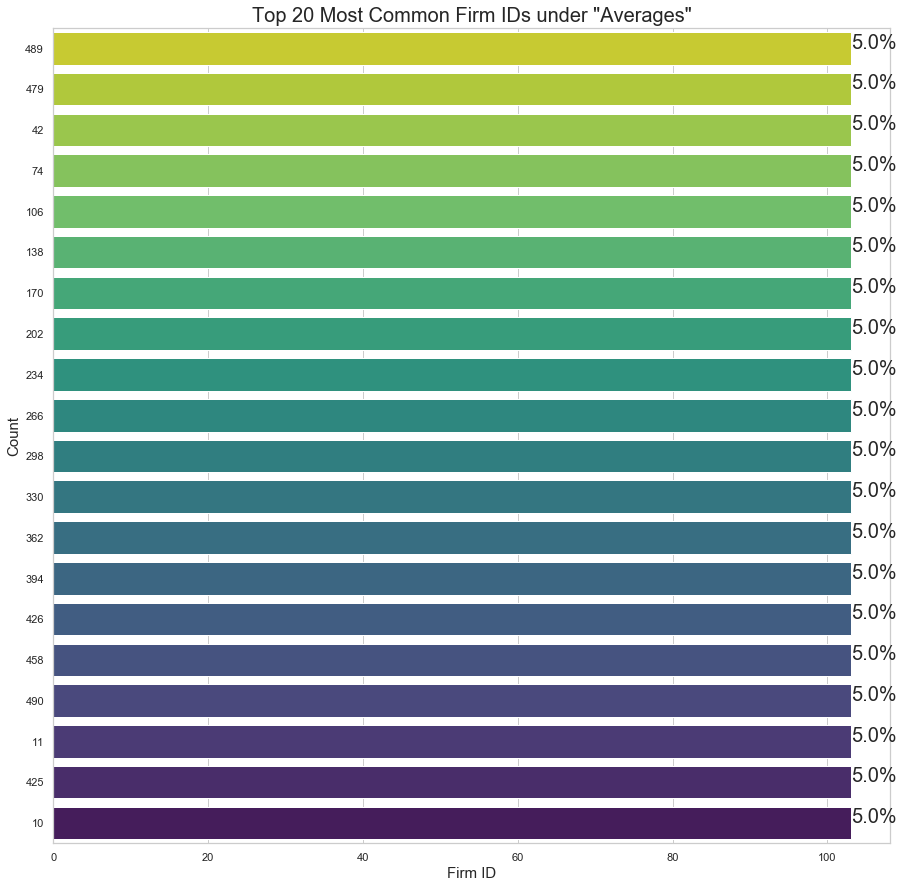

In [57]:
plt.figure(figsize = [15, 15])
x = avgs_firm_id_top_lim
num_bins = 5
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID')
plt.ylabel('Count')
plt.title('Top 20 Most Common Firm IDs under "Averages"', size = 20)

plt.savefig(PATH_UNIVARIATE + 'avgs-firm-id-count-top.png');
plt.show();

In [58]:
avgs_firm_id_bottom = avgs.firm_id.value_counts()[-20:].index
avgs_firm_id_bottom_lim = avgs.loc[avgs.firm_id.isin(avgs_firm_id_top)]

#check there are only 20 unique values
avgs_firm_id_bottom_lim.firm_id.nunique()

20

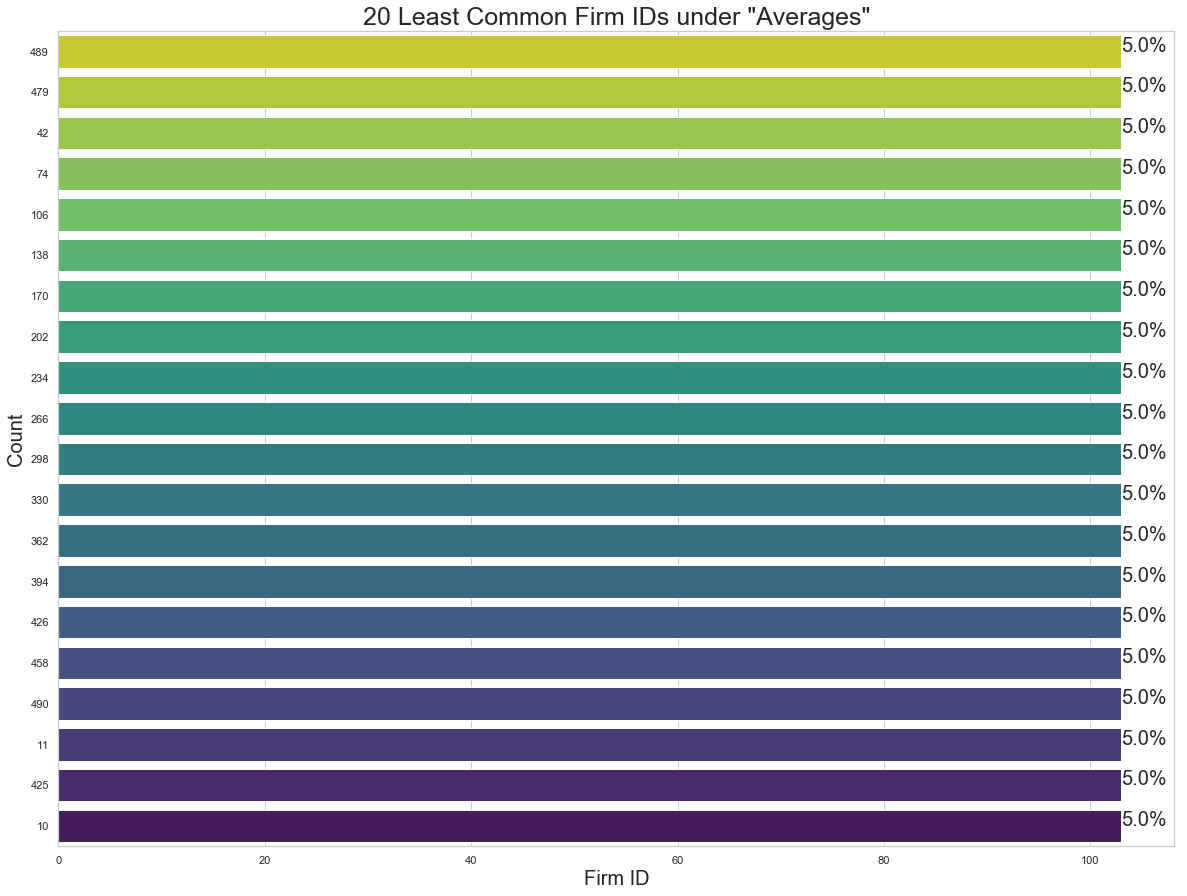

In [59]:
plt.figure(figsize = [20, 15])
x = avgs_firm_id_bottom_lim
generate_pct_bar(x, 'firm_id', 'viridis_r')
# n, bins, patches = plt.hist(x, num_bins, facecolor = 'pink', alpha = 0.5)
plt.xlabel('Firm ID', size = 20)
plt.ylabel('Count', size = 20)
plt.title('20 Least Common Firm IDs under "Averages"', size = 25)

plt.savefig(PATH_UNIVARIATE + 'avgs-firm-id-count-bottom.png');
plt.show();

**Observation 1:** Both the 20 most common and least common Firm IDs all make up the same proportion of existing Firm IDs: 5.0% each. This means that under "Averages", there is a **consistent count among all Firm IDs** at around 105.

In [60]:
#check consistency of counts among firm_ids
firm_counts = avgs.firm_id.value_counts()
np.unique(firm_counts.sort_values().values)

array([103], dtype=int64)

> I discovered that ***all firm id counts are consistent across the entire avgs.csv dataset*** at 105 entries per firm id. There are no null firm ids.

### AVERAGE (Averages)

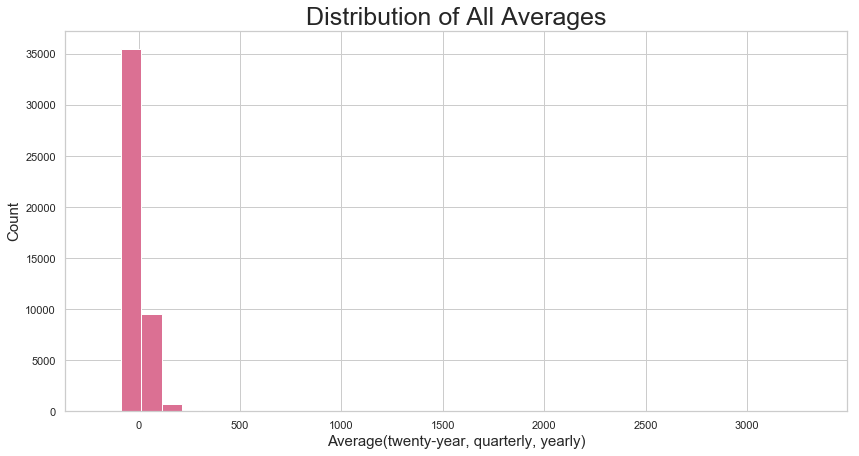

In [61]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 100, 100)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist.png')

**Observation 1**: The trend in value counts is ***heavily right-skewed***

**Observation 2:** The value range 0-100 contains the highest concentration of data, with around 36,000 entries.

**Observation 3:** The value range 0-300 contains the "bulk" of all the data, which means the surrounding x-axis values are all outliers. 

**Observation 4:** There is a ***all values, whether under Features or Averages, share a common theme of taking up the "bulk" of data in the same bin range***

---

**Questions:**

6) How do value counts under Averages look like after removing all outliers around the value range 0-300?

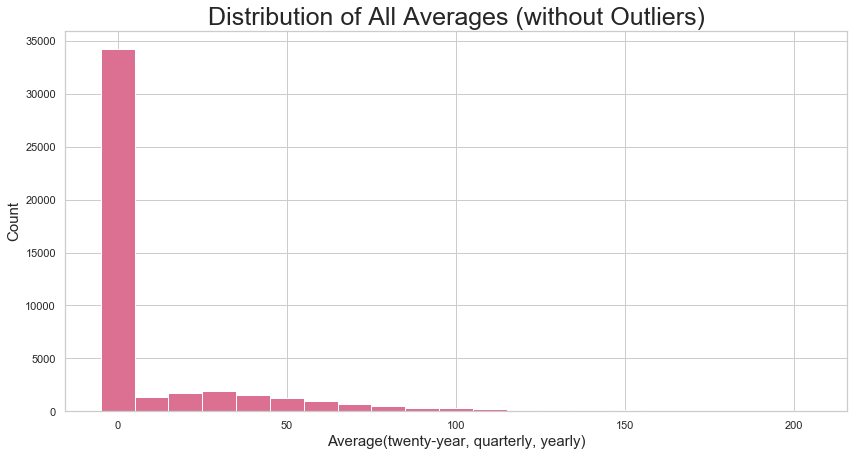

In [62]:
value_bins = np.arange(-5, 200 + 10, 10)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages (without Outliers)', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist-zoom-1.png')

### Question 6: How do average counts under Averages look like after removing all outliers around the value range 0-300?
**Observation 1:** The graph appears to be a normal distribution with a ***strong right skew.*** This is still unlike the previous graph *with* all the outliers, where the right skew is much more pronounced and prominent.

**Observation 2:** Instead of breaking the bins up by bin widths of 100, the bin width here is 10.

**Observation 3:** The value range 0-10 contains the **bulk** of all the data. This is the **highest bar**, with counts of around 12,000.
- The previous graph showed that the bin range 0-100 contains around 36,000 points.
- This graph shows that the bin range 0-10 contains around 34,000 points.
- Drawing from the previous 2 observations, we can conclude that ***it's really the bin range 0-10 that contains the bulk of all the data***, with the other ~2,000 points being scattered among the bins from 10 to 110.

**Observation 4:** Among the bins from 10 to 110 that contain the other 2,000 counts, the bin 30-40 contains the "bulk" of that data at around 2,000 counts.

### It would be a good idea to break down the 0-10 bin range even further for Averages, and examine solely that range.

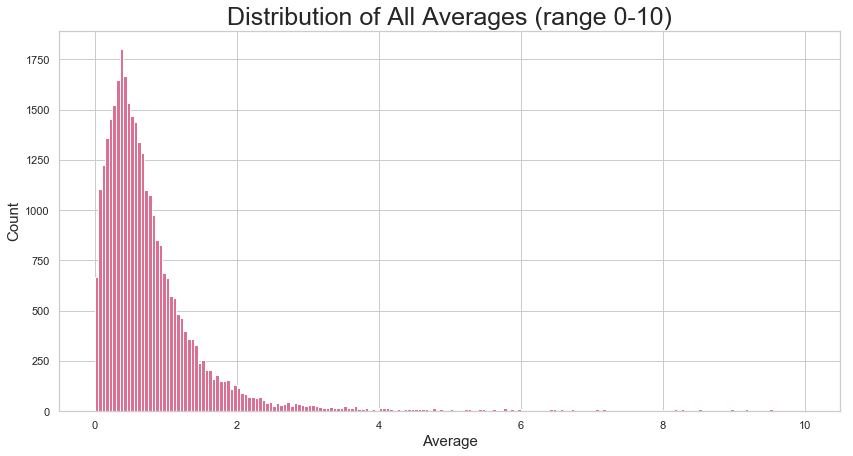

In [63]:
value_bins = np.arange(0, 10 + 0.05, 0.05)
value_hist = generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages (range 0-10)', 
                'Average',
                'Count', PATH_UNIVARIATE, 'avgs-avgs-hist-zoom-2.png')

**Observation 1:** The graph, even when zoomed in, still retains a strong right skew.

**Observation 2:** The "bulk" of the data is around the value range **0.02 to 0.05: the "peak" of the distribution.**

> Just to make sure this graph is skewed heavily to the right, let's create a kernel density curve:

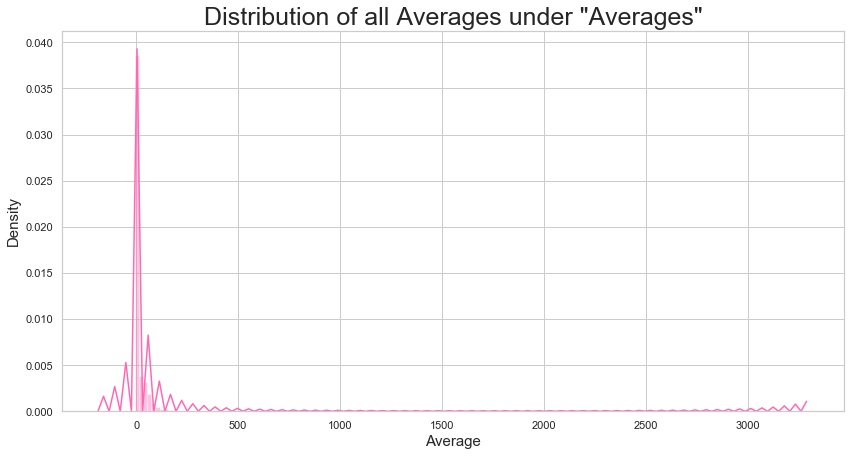

In [64]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 20, 20)
generate_distplot(avgs.average.dropna(), bins = value_bins)
plt.xlabel('Average')
plt.ylabel('Density')
plt.title('Distribution of all Averages under "Averages"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'avgs-average-dist.png')

**Observation:** As shown by the kernel density curve, the distribution of `average` under Averages is heavily right-skewed. This means that ***most averages are clustered around the left-side of the distribution*** where the mean, median, and mode are all located.


**A KEY TAKEAWAY:** There is a strong congruency between the distribution patterns of ***values under Features*** and ***averages under Averages***. 
> This is perhaps because TK

### AVERAGE TYPE (Averages)

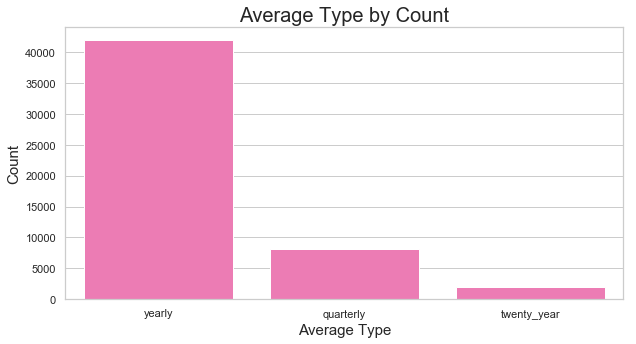

In [65]:
plt.figure(figsize = [10, 5])
cat_order = avgs.average_type.value_counts().index
sb.countplot(data = avgs, x = 'average_type', color = 'hotpink', order = cat_order)
plt.xlabel('Average Type')
plt.ylabel('Count')
plt.title('Average Type by Count', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-count.png')

**Observation 1:** Under Averages, **yearly** data has the highest number of counts while **twenty-year** data has the least number of counts. This all makes sense, as there are more yearly averages than quarters per firm, and more quarters than twenty-year entries per firm.
- For each firm, there are around 20 yearly averages (1999 to 2019) for each of the 4 features. (80 total per firm).
- For each firm, there are 4 quarterly averages for each of the 4 features. (16 total per firm)
- For each firm, there is 1 twenty-year average for each of the 4 features. (4 total per firm)

**Note:** number of entries may vary for *yearly averages* because the year 1999 and 2019 are missing for some features.

In [66]:
#keep for analysis, delete when done w/ report
len(avgs.query('average_type == "yearly" and firm_id == 0'))

83

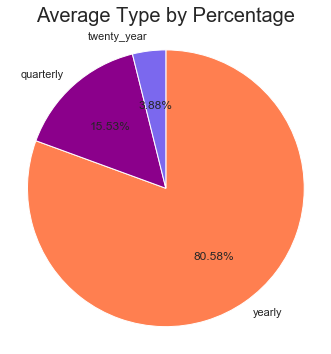

In [67]:
colors = random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)

plt.figure(figsize = [10, 5])
cs=cm.Set1(np.arange(40)/40.)

plt.pie(avgs.average_type.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = avgs.average_type.value_counts().index, colors = colors);
plt.suptitle('Average Type by Percentage', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.axis('square');
plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-pie.png')

**Observation 1:** As expected, yearly average types make up the majority of all entries at 80.58%.

**Observation 2:** As expected, twenty-year average types make up the least portion of all entries at 3.88%.

**Observation 3:** These percentages are consistent with the previous counts.

### TIME_PERIOD (Averages)

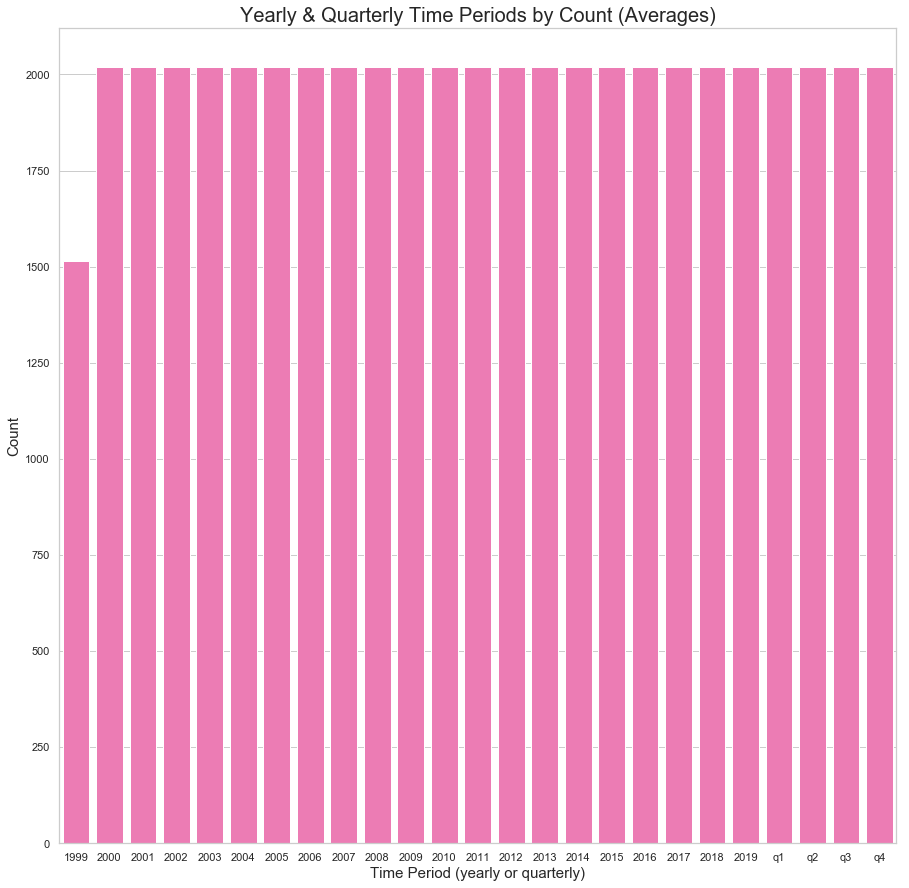

In [68]:
plt.figure(figsize = [15, 15])
cat_order = avgs.time_period.value_counts().sort_index().index
sb.countplot(data = avgs, x = 'time_period', color = 'hotpink', order = cat_order)
plt.xlabel('Time Period (yearly or quarterly)')
plt.ylabel('Count')
plt.title('Yearly & Quarterly Time Periods by Count (Averages)', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-time-period-hist.png')

> I decided to portray ***both yearly and quarterly Time Periods*** in the same countplot because q1-q4 and the years 2000-2019 show consistent counts.

**Observation 1:** All years from 2000-2019 **and** all quarters show consistent counts, at just over 2,000 entries each.

**Observation 2:** The year 1999 has the least amount of counts, at only around 1510. This is because the feature `eps_fc_terms` does not contain the year 1999.

**Observation 3:** The time period for `twenty-year` averages does not show because by default, all Time Period entries associated with average type of `twenty-year` is set to null.

### FEATURE (Averages)

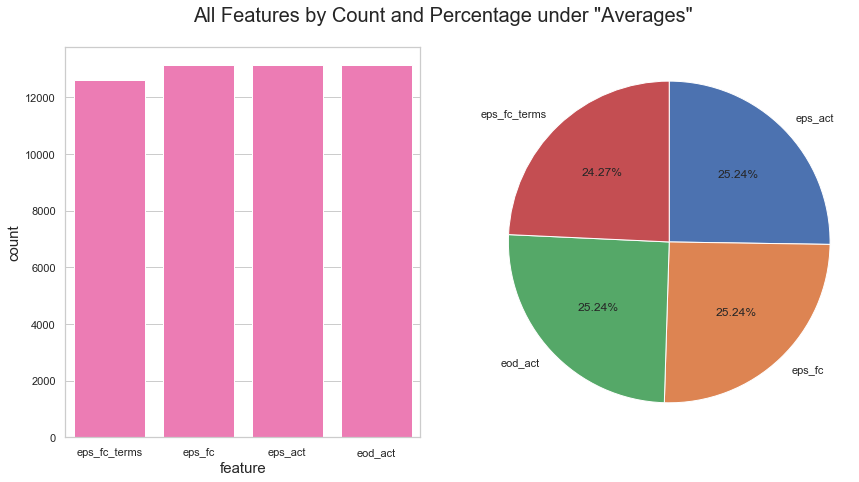

In [69]:
plt.figure(figsize = [14, 7])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
# generate_pct_bar(avgs, 'feature', 'Blues_d')
sb.countplot(data = avgs, x = avgs.feature, color = 'hotpink', order = cat_order)

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = avgs['feature'].value_counts()
plt.pie(avgs.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = avgs.feature.value_counts().index);
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Averages"', size = 20)
# plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'avgs-feature-hist-pie.png')

**Observation 1:** `eps_act`, `eps_fc`, and `eod_act` all show consistent counts at around 13,000 entries each (25.24% each).

**Observation 2:** `eps_fc_terms` is the only *feature type* to deviate from the others, having less entries at around 12,500 (24.27%).

**Observation 3:** It makes sense that `eps_fc_terms` contains missing data, because ***the year 1999 was not included while gathering this data.*** This effectively removes around 500 entries: not a substantial amount of data.

## IV) Bivariate Exploration<a id = "bi"></a>

> General rule: The *closer* the eps_act - eps_fc difference is to 0, the *more accurate* the forecast.

### VALUE by FEATURE

In [70]:
temp = features[features.feature.isin(['eps_fc', 'eps_act'])]

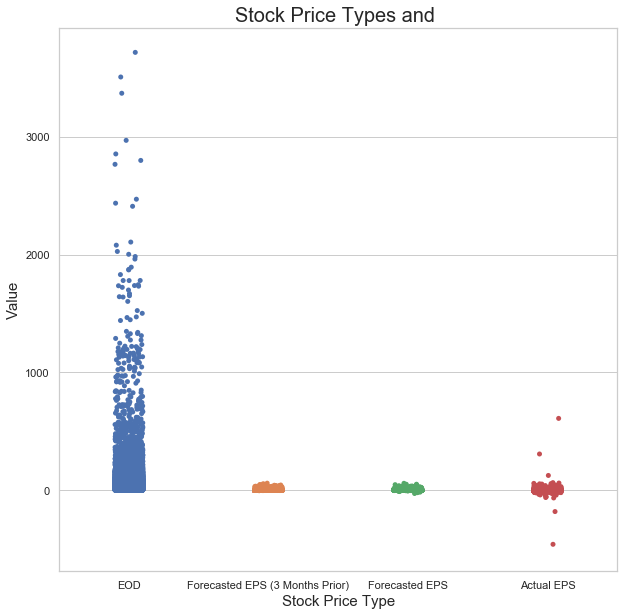

In [71]:
plt.figure(figsize = [10, 10])
sb.stripplot(x = 'feature', y = 'value', data = features, jitter = True)

plt.title('Stock Price Types and ', size = 20)
plt.xlabel('Stock Price Type')
plt.ylabel('Value')

plt.xticks([0, 1, 2, 3], ['EOD', 'Forecasted EPS (3 Months Prior)', 'Forecasted EPS', 'Actual EPS'])
plt.savefig(PATH_BIVARIATE + 'features-feature-value.png')
plt.show();

**Observation 1:** EOD Price has the most variability among the other stock price types.

**Observation 2:** Forecasted EPS (3 months prior) and Forecasted EPS (current) are the only stock price types to appear uniforn in distribution: their values are clustered around 0.

**Observation 3:** Actual EPS has the most outliers compared to the other stock price types: 5 outliers. And since actual EPS has the most outliers, it turns out that forecasters' predictions have been too uniform and stable in the approach of analyzing stock market trends.

---
### EOD Price by Term (features.csv)

In [72]:
features_eod = features[features.feature == 'eod_act']

#create 5-year moving averages to "smooth" out all future graphs
features_eod['ma_value'] = features_eod.value.rolling(12).mean()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


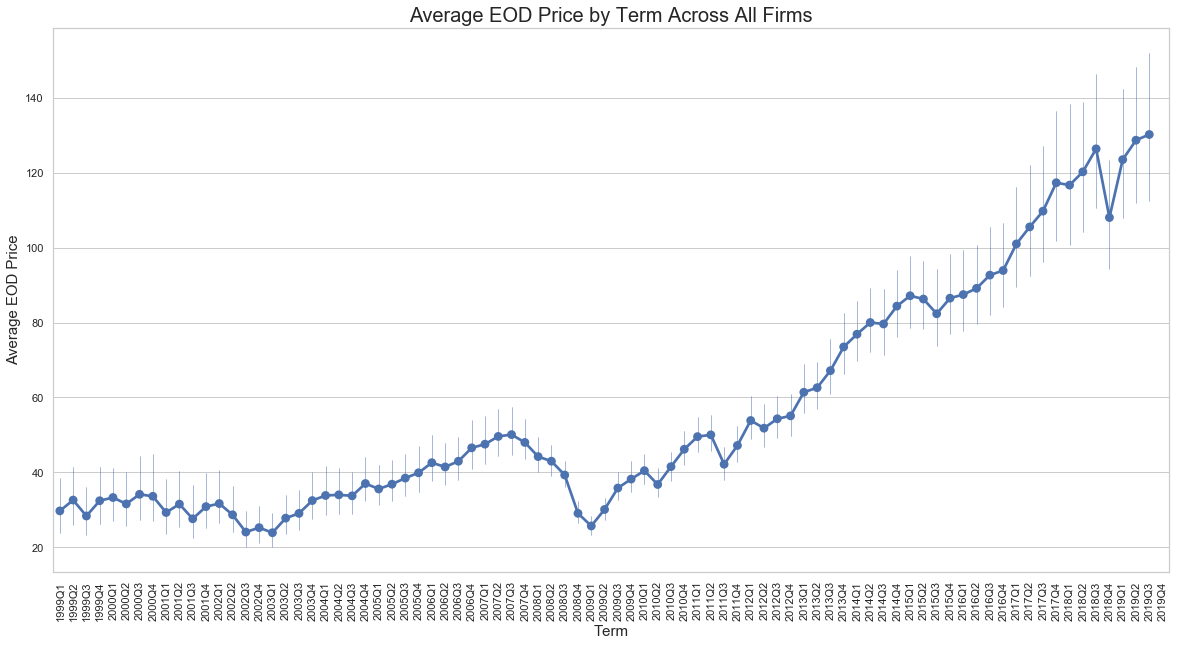

In [73]:
plt.figure(figsize = [20, 10])
sb.pointplot(x = 'term', y = 'value', data = features_eod, errwidth = 0.5)
plt.xticks(rotation = 'vertical')

plt.title('Average EOD Price by Term Across All Firms', size = 20)
plt.xlabel('Term')
plt.ylabel('Average EOD Price')

plt.savefig(PATH_BIVARIATE + 'features-eod-term.png')

**Observation 1:** The graph depicts a positive linear trend from all quarters spanning 1999 - 2019. 

**Observation 2:** The average EOD Price troughs during 2009 Quarter 1. The start of the trend in this downfall starts in 2007 Quarter 4, but the average EOD price recovers shortly after, only 1 quarter later on 2009, Quarter 2.

In layman's terms, this generally positive linear trend shows that ***all 505 firms in the S&P 2019 Index have been getting "richer" over the past 20 years.*** 

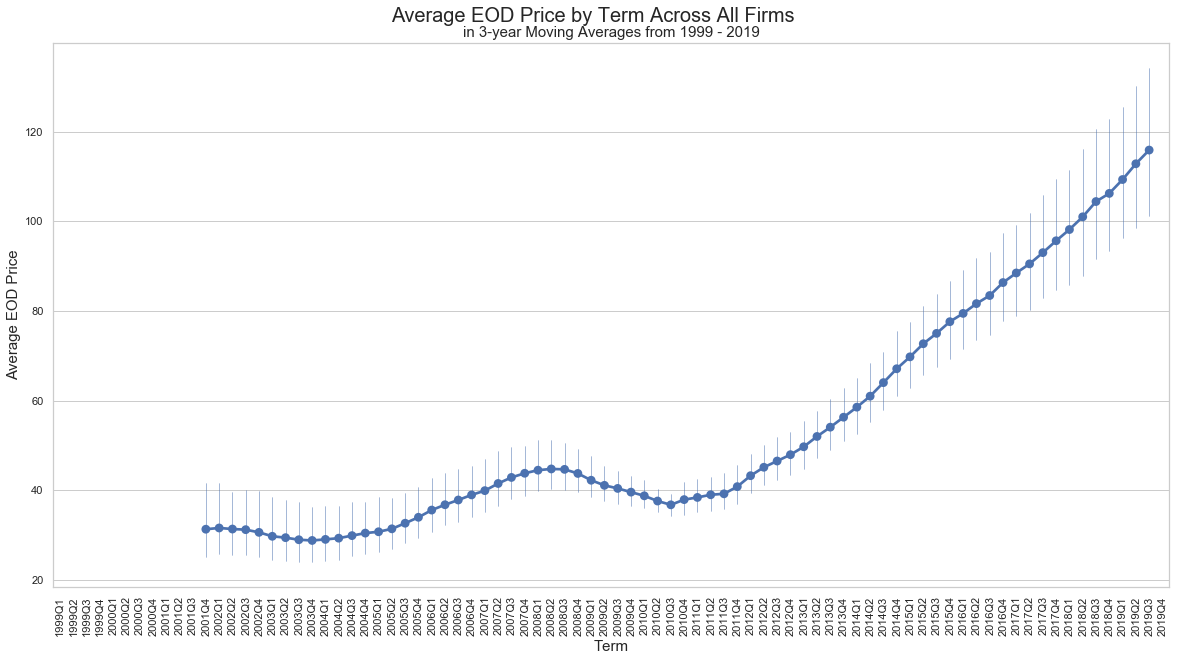

In [74]:
plt.figure(figsize = [20, 10])
sb.pointplot(x = 'term', y = 'ma_value', data = features_eod, errwidth = 0.5)
plt.xticks(rotation = 'vertical')

plt.suptitle('Average EOD Price by Term Across All Firms', size = 20, y = .93)
plt.title('in 3-year Moving Averages from 1999 - 2019', size = 15)
plt.xlabel('Term')
plt.ylabel('Average EOD Price')

plt.savefig(PATH_BIVARIATE + 'features-eod-term-ma.png')



The EOD graph could be used to make correlations with EPS forecasts and how the firm is getting "richer" overtime.

### DIFFERENCE IN FORECASTED AND ACTUAL EPS (PREDICTION ERROR) BY TERM

In [75]:
#isolate eps_fc and eps_act in their own columns to get their difference
features_diffs = features[features.feature.isin(['eps_fc', 'eps_act'])][['firm_id', 'term', 'value', 'feature']]

In [76]:
#isolate eps_fc and eps_act
eps_fc_diffs = features_diffs[features_diffs.feature == 'eps_fc'].rename(columns = {'value' : 'eps_fc_value'})[['firm_id', 'term', 'eps_fc_value']]
eps_act_diffs = features_diffs[features_diffs.feature == 'eps_act'].rename(columns = {'value' : 'eps_act_value'})[['firm_id', 'term', 'eps_act_value']]

In [77]:
#merge, creating separate columns for eps_fc and eps_act values
act_fc_diffs = eps_fc_diffs.merge(eps_act_diffs, how = 'inner', left_on = ['firm_id', 'term'], right_on = ['firm_id', 'term'])

act_fc_diffs.sample(5)

firm_id    term  eps_fc_value  eps_act_value
1028        12  2004Q1         0.287           0.33
19511      232  2004Q4           NaN            NaN
35751      425  2011Q4         0.262           1.36
23513      279  2018Q2         1.188           1.24
11813      140  2012Q2           NaN           0.64

In [78]:
#create 'difference' column
act_fc_diffs['difference'] = act_fc_diffs['eps_act_value'] - act_fc_diffs['eps_fc_value']

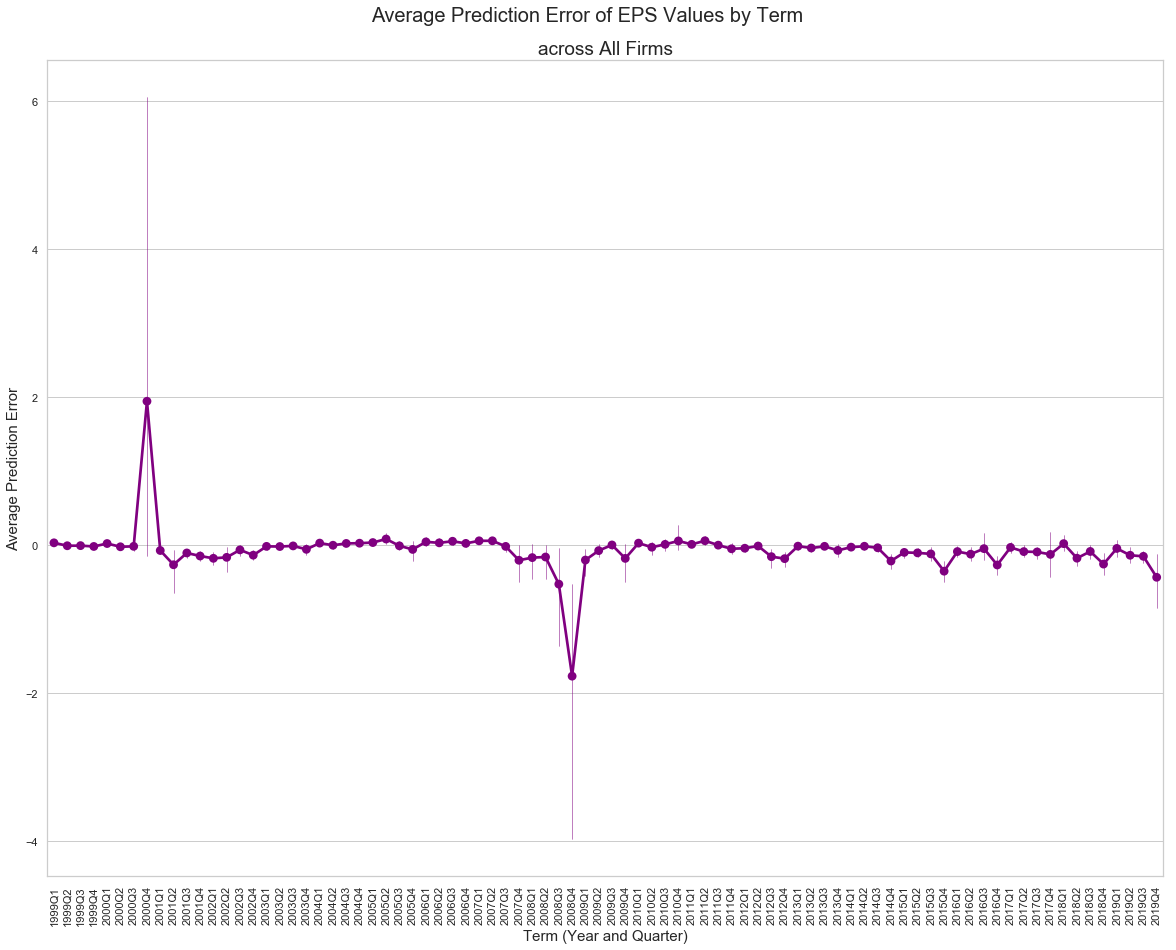

In [79]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = 'term', y = 'difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Term', size = 20, y = .93)
plt.title('across All Firms', size = 19)
plt.xticks(rotation = 'vertical')
plt.xlabel('Term (Year and Quarter)')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-term.png')
plt.show();

**Observation 1:** Forecasters were most optimistic in 2008, Quarter 4.

**Observation 2:** Forecasters were most pessimistic in 2000, Quarter 4.

**Observation 3:** The trend indicates no linear relationship; it follows in a stable, one-dimensional direction with average prediction errors center around 0.

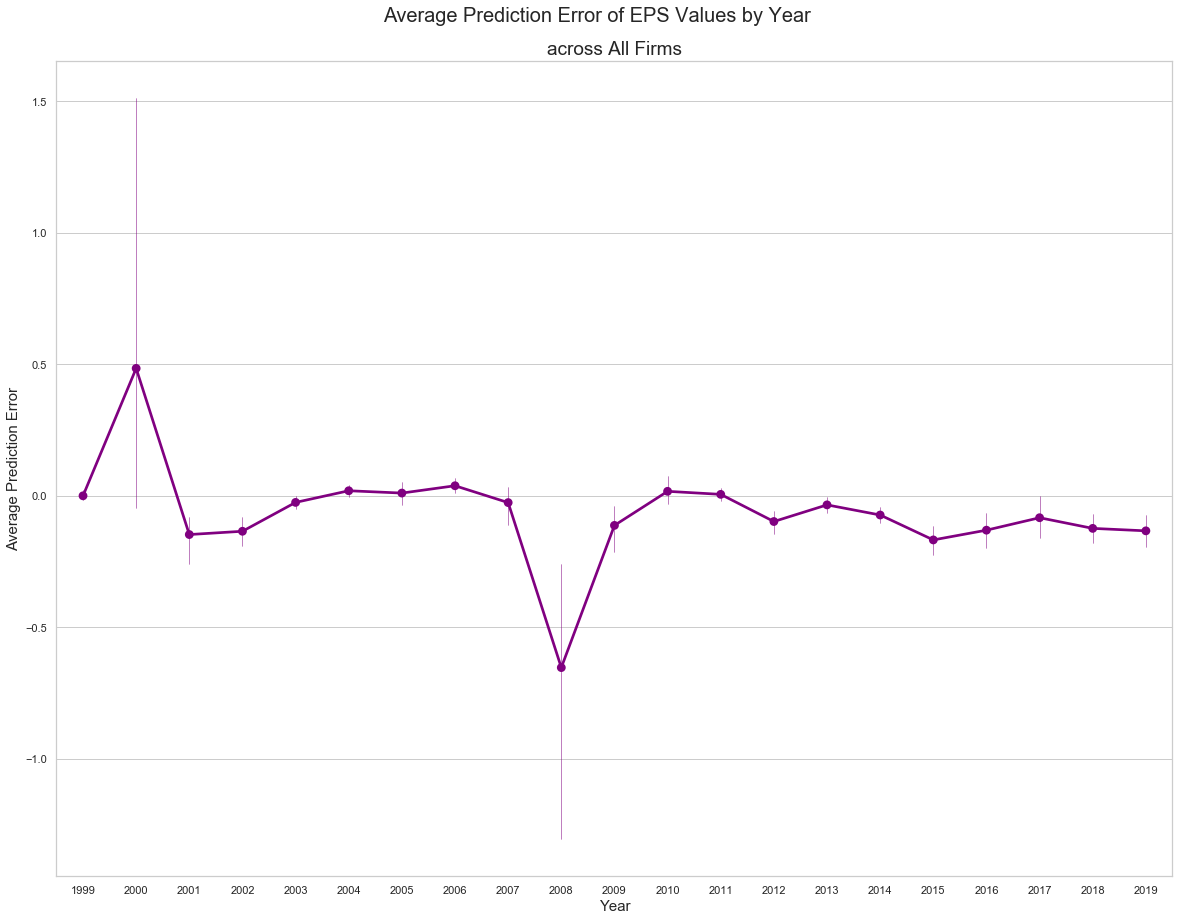

In [80]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.year, y = 'difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Year', size = 20, y = .93)
plt.title('across All Firms', size = 19)
# plt.xticks(rotation = 'vertical')
plt.xlabel('Year')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-year.png')
plt.show();

**Observation 1:** Forecasters were most pessimistic in the year 2000. From the error bar, the year 2000 shows one of the widest variances in average prediction errors ranging from 0 until 0.5

**Observation 2:** Forecasters were most optimistic in the year 2008. From the error bar, the year 2008 shows one of the widest variances in average prediction errors ranging from -0.25 until -1.5. 

**Observation 3:** The overall trend stays consistent with the previous trends by term: consistent, relatively stable, and containing no slope.



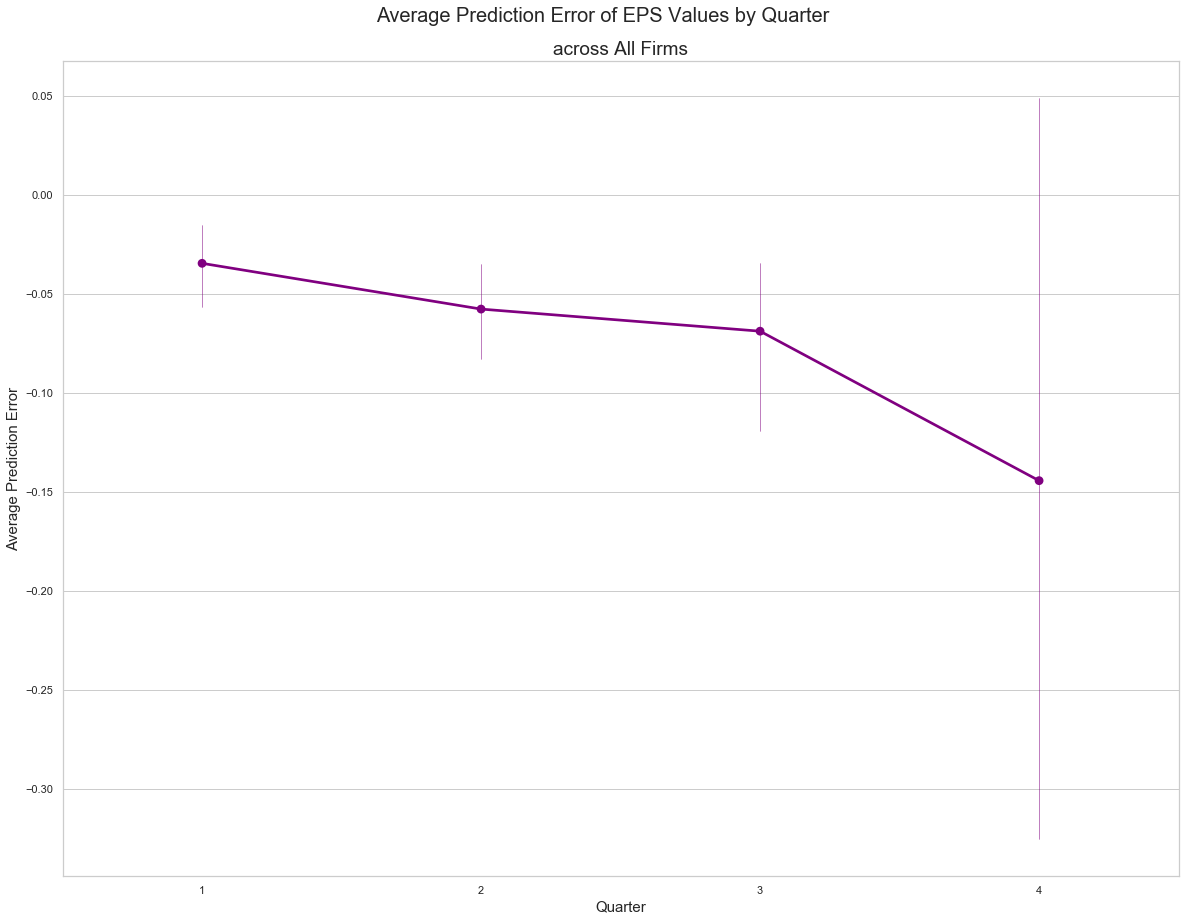

In [81]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.quarter, y = 'difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Quarter', size = 20, y = .93)
plt.title('across All Firms', size = 19)
# plt.xticks(rotation = 'vertical')
plt.xlabel('Quarter')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-quarter.png')
plt.show();

**Observation:** The later the quarter, the more optimistic forecasters become in their predictions. I am assuming this is because each new quarter brings the familiarity of the current year's stock market dynamics.

### DIFFERENCE IN MOVING AVERAGE FORECASTED AND ACTUAL EPS (PREDICTION ERROR) BY TERM

In [82]:
#3-year moving averages
act_fc_diffs['ma_difference'] = act_fc_diffs.difference.rolling(12).mean()

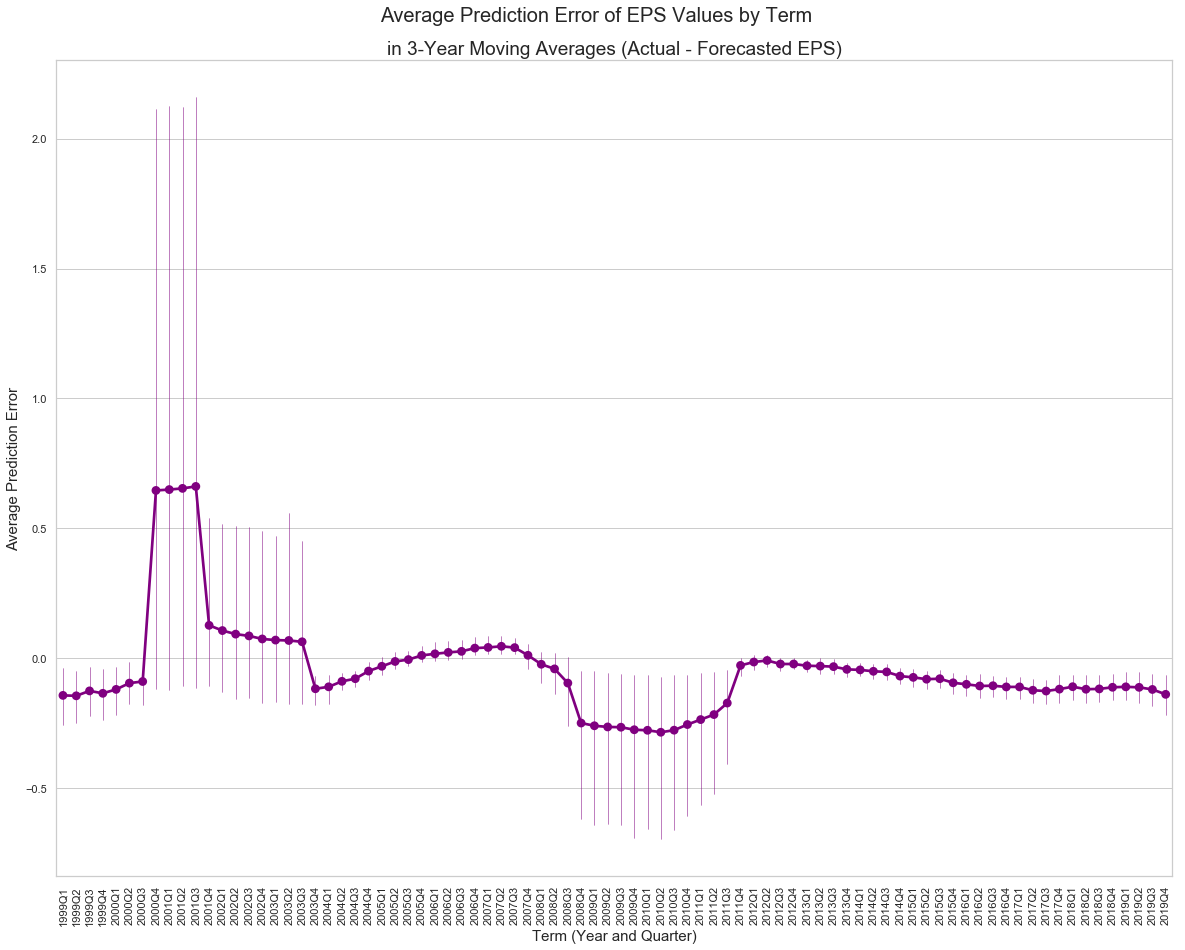

In [83]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = 'term', y = 'ma_difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Term', size = 20, y = .93)
plt.title('in 3-Year Moving Averages (Actual - Forecasted EPS)', size = 19)
plt.xticks(rotation = 'vertical')
plt.xlabel('Term (Year and Quarter)')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-term-ma.png')
plt.show();

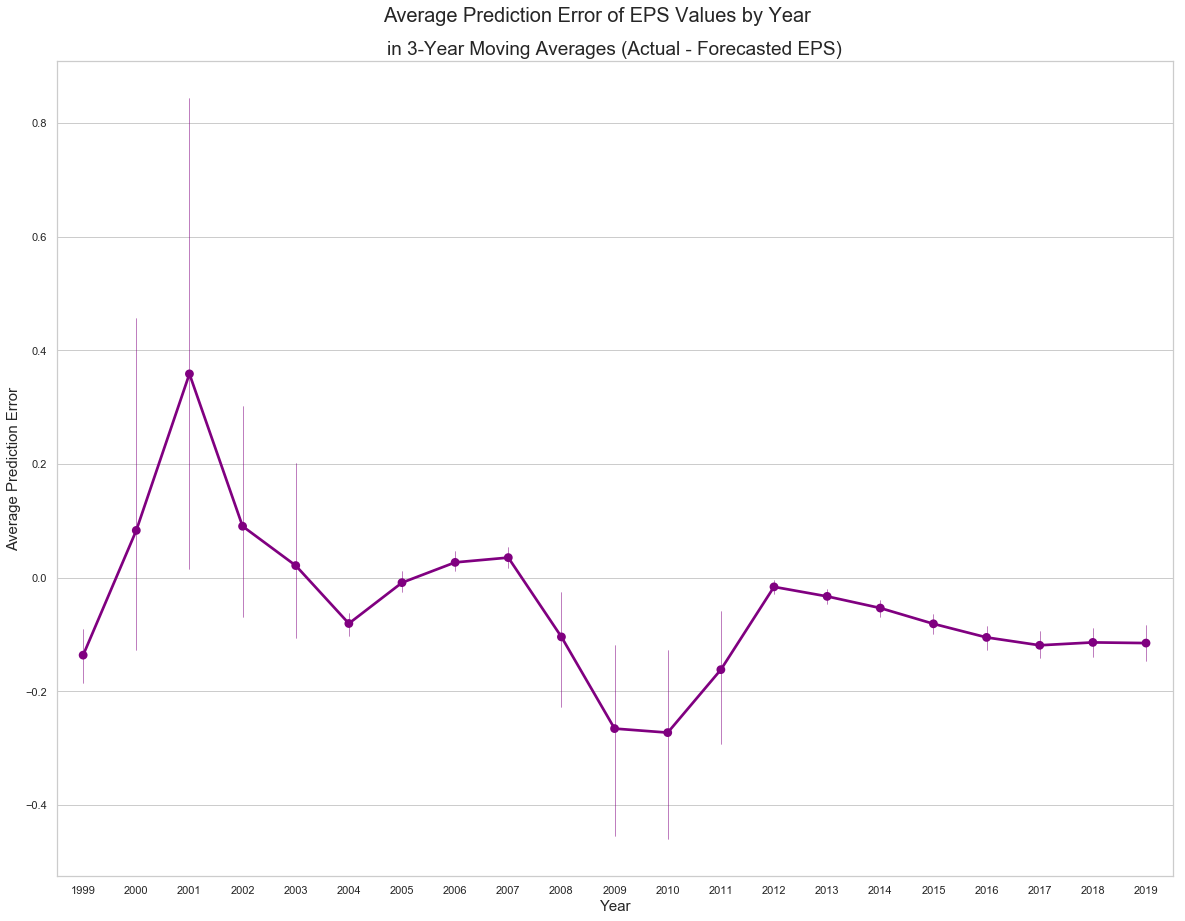

In [84]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.year, y = 'ma_difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Year', size = 20, y = .93)
plt.title('in 3-Year Moving Averages (Actual - Forecasted EPS)', size = 19)
plt.xlabel('Year')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-year-ma.png')
plt.show();

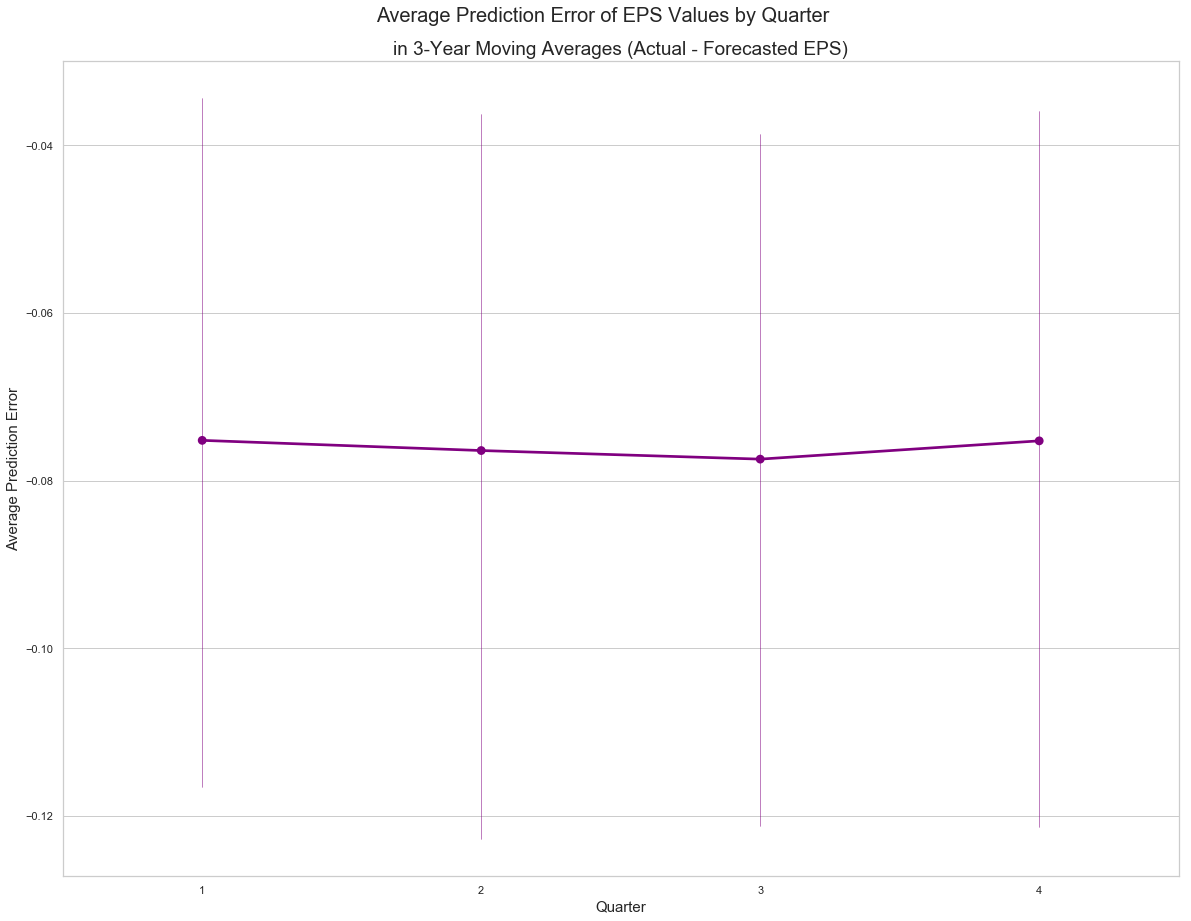

In [85]:
plt.figure(figsize = [20, 15])
sb.pointplot(data = act_fc_diffs, x = act_fc_diffs.term.dt.quarter, y = 'ma_difference', color = 'purple', errwidth = .5)

plt.suptitle('Average Prediction Error of EPS Values by Quarter', size = 20, y = .93)
plt.title('in 3-Year Moving Averages (Actual - Forecasted EPS)', size = 19)
plt.xlabel('Quarter')
plt.ylabel('Average Prediction Error')

plt.savefig(PATH_BIVARIATE + 'features-act-fc-diffs-quarter-ma.png')
plt.show();

**Observation 1:** Compared to their non-moving-average counterparts, the above pointplots plotting 3-year moving averages show a consistent slopeless trned, including periods of optimism vs. pessimism.

### DIFFERENCE IN TWENTY YEAR AVERAGE OF EPS_FC AND EPS_ACT BY FIRM (Averages)

In [86]:
#array of all firm ids
ids = firm_ids.firm_id.values

In [87]:
#put eps_fc and eps_act averages into separate DFs
avgs_eps_fc = avgs[avgs['feature'] == 'eps_fc']
avgs_eps_act = avgs[avgs['feature'] == 'eps_act']

In [88]:
#isolate eps_fc and eps_act DFs by "twenty_year" average type
avgs_eps_fc_twenty = avgs_eps_fc[avgs_eps_fc['average_type'] == 'twenty_year']
avgs_eps_act_twenty = avgs_eps_act[avgs_eps_act['average_type'] == 'twenty_year']

In [89]:
#df of only twenty-year average types
avgs_twenty = pd.concat([avgs_eps_fc_twenty, avgs_eps_act_twenty])

In [90]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_twenty = avgs_twenty.query('feature == "eps_fc"').average.values
avg_eps_act_twenty = avgs_twenty.query('feature == "eps_act"').average.values
twenty_diff_data = list(zip(ids, avg_eps_fc_twenty, avg_eps_act_twenty))

twenty_diffs = pd.DataFrame(twenty_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
twenty_diffs['difference'] = twenty_diffs['average_eps_act'] - twenty_diffs['average_eps_fc']
twenty_diffs['average_type'] = 'twenty_year'

In [91]:
twenty_diffs.sample(5)

firm_id  average_eps_fc  average_eps_act  difference average_type
433      433        0.765619         0.746574   -0.019045  twenty_year
363      363        0.152750         0.149246   -0.003504  twenty_year
443      443        0.401600         0.262182   -0.139418  twenty_year
219      219        0.270173         0.188186   -0.081987  twenty_year
172      172        0.642083         0.701472    0.059389  twenty_year

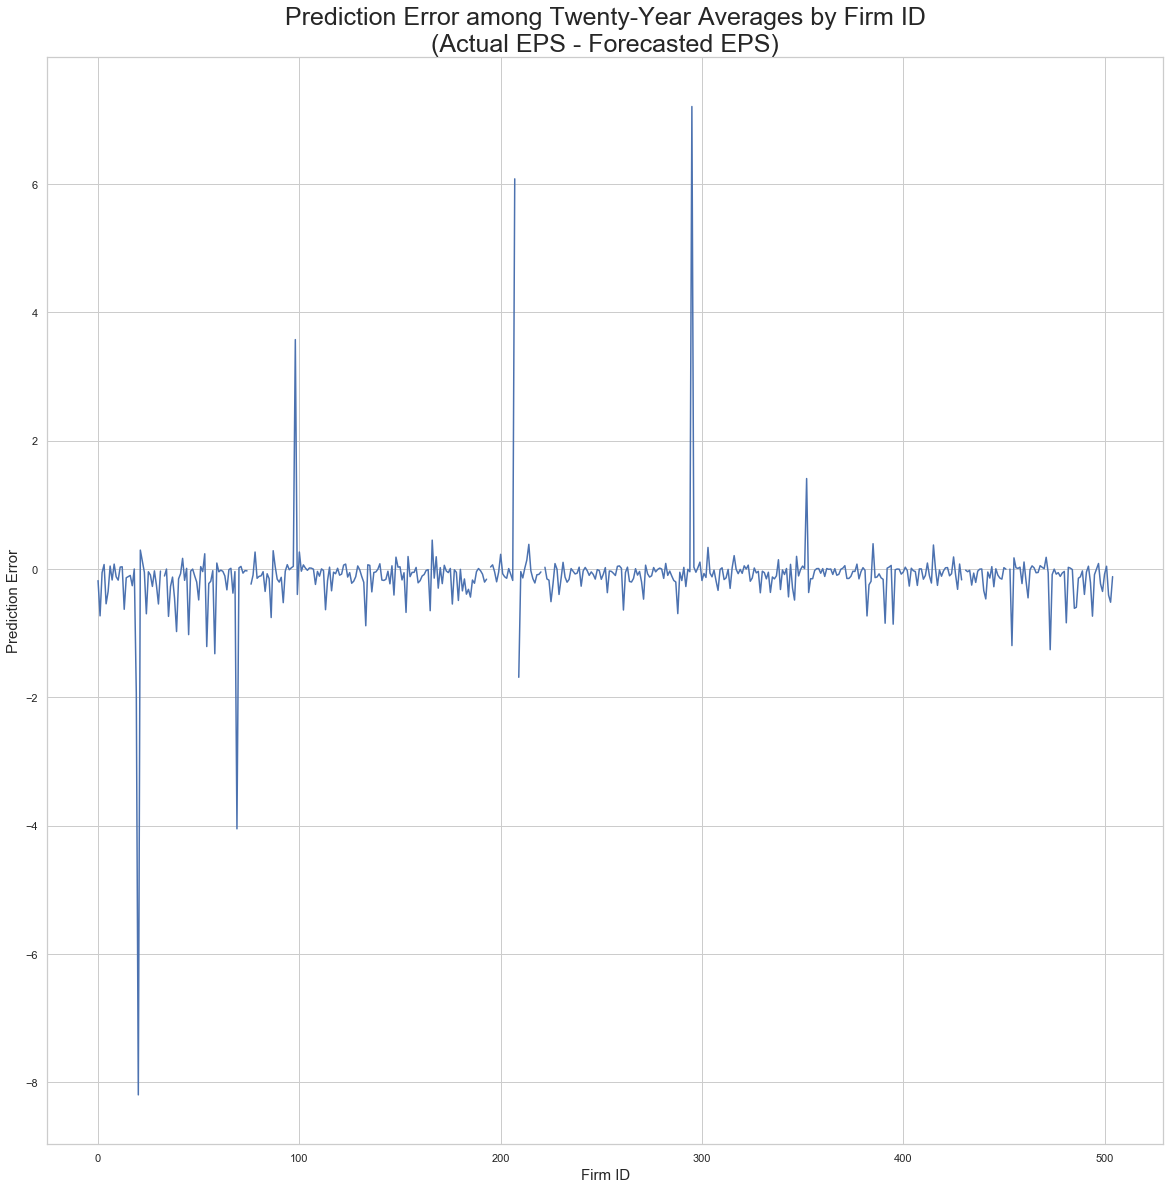

In [92]:
plt.figure(figsize = [20, 20])
plt.title('Prediction Error among Twenty-Year Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
plt.plot(twenty_diffs['firm_id'], twenty_diffs['difference'])

plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year.png')
plt.show();

### DIFFERENCE IN QUARTERLY AVERAGE OF EPS_FC AND EPS_ACT (Averages)

In [93]:
#isolate eps_fc and eps_act DFs by "quarterly" average type
avgs_eps_fc_quarter = avgs_eps_fc[avgs_eps_fc['average_type'] == 'quarterly']
avgs_eps_act_quarter = avgs_eps_act[avgs_eps_act['average_type'] == 'quarterly']

In [94]:
#df of only quarterly averages
avgs_quarter = pd.concat([avgs_eps_fc_quarter, avgs_eps_act_quarter])

In [95]:
#get the average average separately per firm
avgs_quarter_sep = avgs_quarter.groupby(['firm_id', 'feature']).mean().reset_index()
avgs_quarter_sep.shape[0]

1010

In [96]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_quarter = avgs_quarter_sep.query('feature == "eps_fc"').average.values
avg_eps_act_quarter = avgs_quarter_sep.query('feature == "eps_act"').average.values

quarter_diff_data = list(zip(ids, avg_eps_fc_quarter, avg_eps_act_quarter))

quarter_diffs = pd.DataFrame(quarter_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
quarter_diffs['difference'] = quarter_diffs['average_eps_act'] - quarter_diffs['average_eps_fc']
quarter_diffs['average_type'] = 'quarter'

In [97]:
quarter_diffs.head()

firm_id  average_eps_fc  average_eps_act  difference average_type
0        0        0.530992         0.350250   -0.180742      quarter
1        1        0.338961        -0.394274   -0.733235      quarter
2        2        1.054504         0.986728   -0.067777      quarter
3        3        0.873143         0.944501    0.071358      quarter
4        4        1.319607         0.762376   -0.557231      quarter

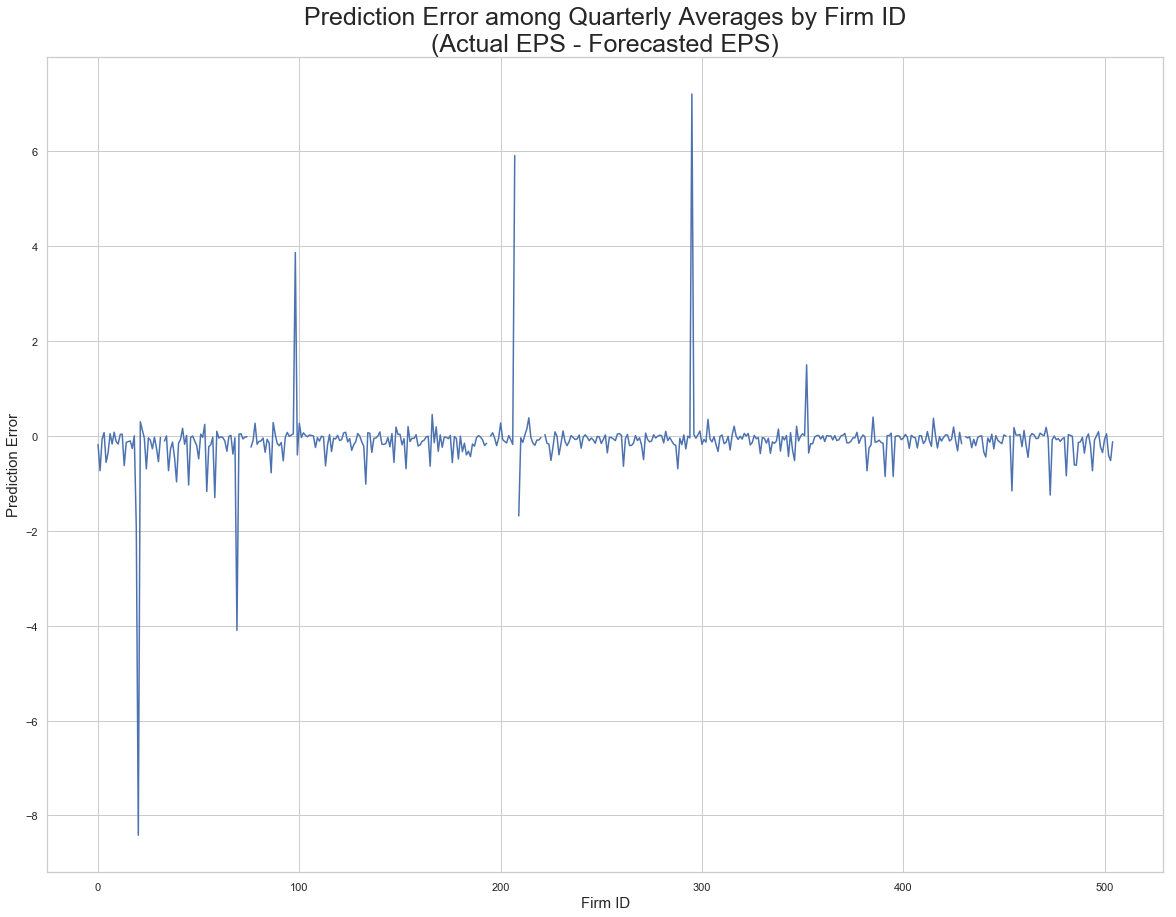

In [98]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Prediction Error among Quarterly Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
plt.plot(quarter_diffs['firm_id'], quarter_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter.png')
plt.show();

### DIFFERENCE IN YEARLY AVERAGE OF EPS_FC AND EPS_ACT (Averages)

In [99]:
#isolate eps_fc and eps_act DFs by "yearly" average type
avgs_eps_fc_year = avgs_eps_fc[avgs_eps_fc['average_type'] == 'yearly']
avgs_eps_act_year = avgs_eps_act[avgs_eps_act['average_type'] == 'yearly']

In [100]:
#df of only yearly averages
avgs_year = pd.concat([avgs_eps_fc_year, avgs_eps_act_year])

In [101]:
#get the average average separately per firm
avgs_year_sep = avgs_year.groupby(['firm_id', 'feature']).mean().reset_index()
avgs_year_sep.sample(5)

firm_id  feature   average
126       63  eps_act  0.469648
925      462   eps_fc  1.080321
519      259   eps_fc  0.387714
943      471   eps_fc  0.666544
175       87   eps_fc  0.107292

In [102]:
#obtain differences in eps_fc and eps_act averages BY firm id
avg_eps_fc_year = avgs_year_sep.query('feature == "eps_fc"').average.values
avg_eps_act_year = avgs_year_sep.query('feature == "eps_act"').average.values

year_diff_data = list(zip(ids, avg_eps_fc_year, avg_eps_act_year))

year_diffs = pd.DataFrame(year_diff_data, columns = ['firm_id', 'average_eps_fc', 'average_eps_act'])
year_diffs['difference'] = year_diffs['average_eps_act'] - year_diffs['average_eps_fc']
year_diffs['average_type'] = 'year'

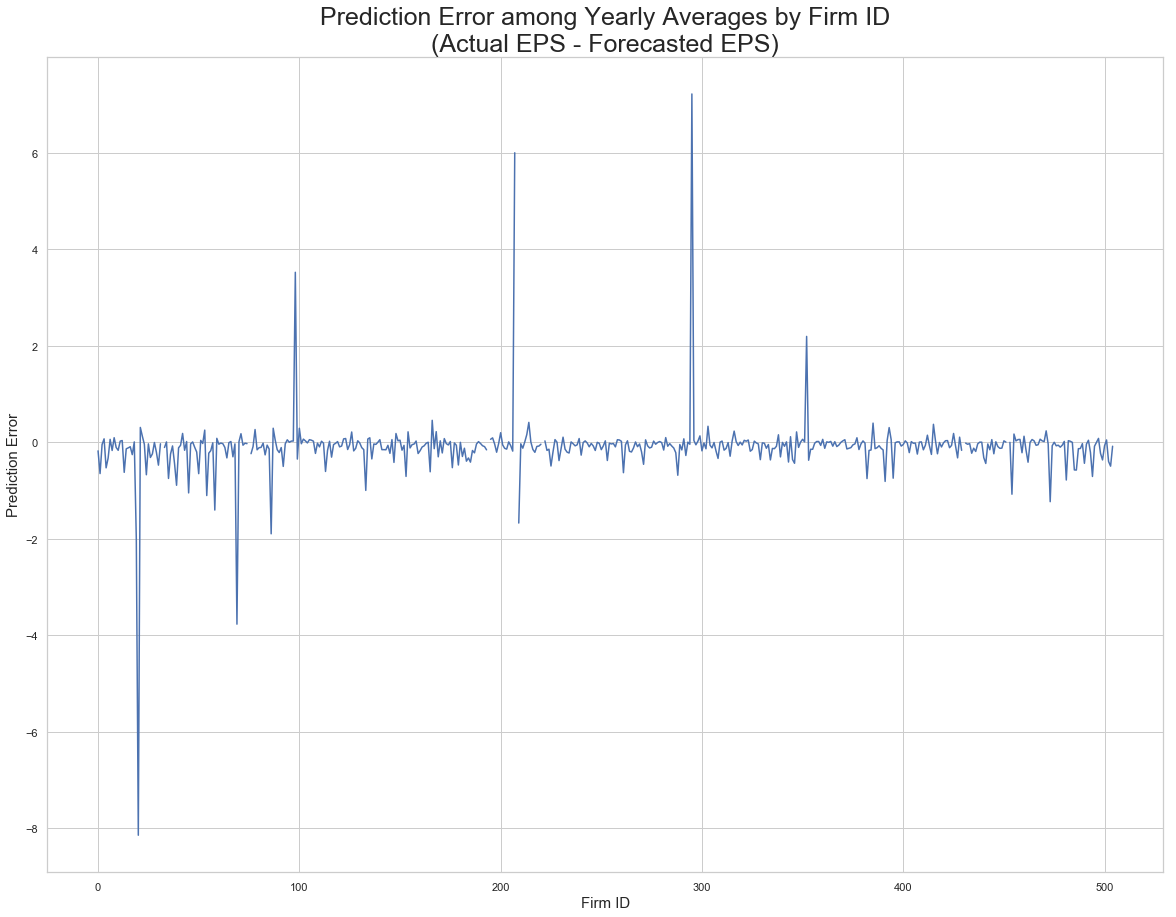

In [103]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Prediction Error among Yearly Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
# plt.title('(Average Forecasted EPS - Average Actual EPS)')
# plt.rcParams = plt.rcParamsDefault
plt.plot(year_diffs['firm_id'], year_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-year.png')
plt.show();

- Put all the above graphs into a single FacetGrid for easy accessibility and comparing, in the Multivariate Exploration stage.

In [104]:
#put all yearly, quarterly, and twenty-year differences into one DF
all_diffs = pd.concat([twenty_diffs, quarter_diffs, year_diffs], sort = False)
all_diffs.sample(5)

firm_id  average_eps_fc  average_eps_act  difference average_type
250      250        0.535357         0.376475   -0.158883      quarter
290      290        0.867179         0.684720   -0.182459      quarter
52        52        0.267975         0.238405   -0.029570      quarter
256      256        0.858671         0.794422   -0.064249  twenty_year
163      163        0.616369         0.596488   -0.019881      quarter

- Now that we looked at the raw data, let's create a line plot depicting the ***average difference among all average types.***

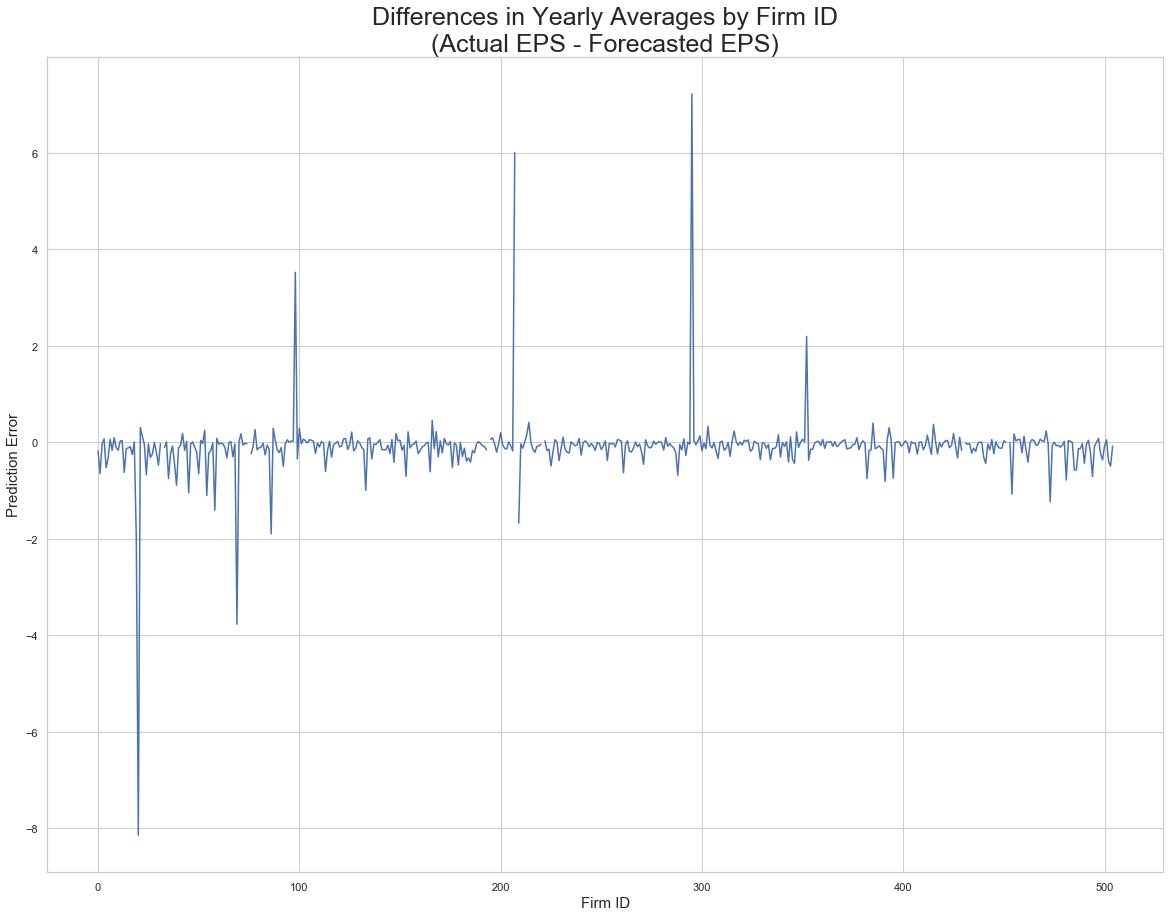

In [105]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Differences in Yearly Averages by Firm ID\n(Actual EPS - Forecasted EPS)', size = 25)
# plt.title('(Average Forecasted EPS - Average Actual EPS)')
# plt.rcParams = plt.rcParamsDefault
plt.plot(year_diffs['firm_id'], year_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-year.png')
plt.show();

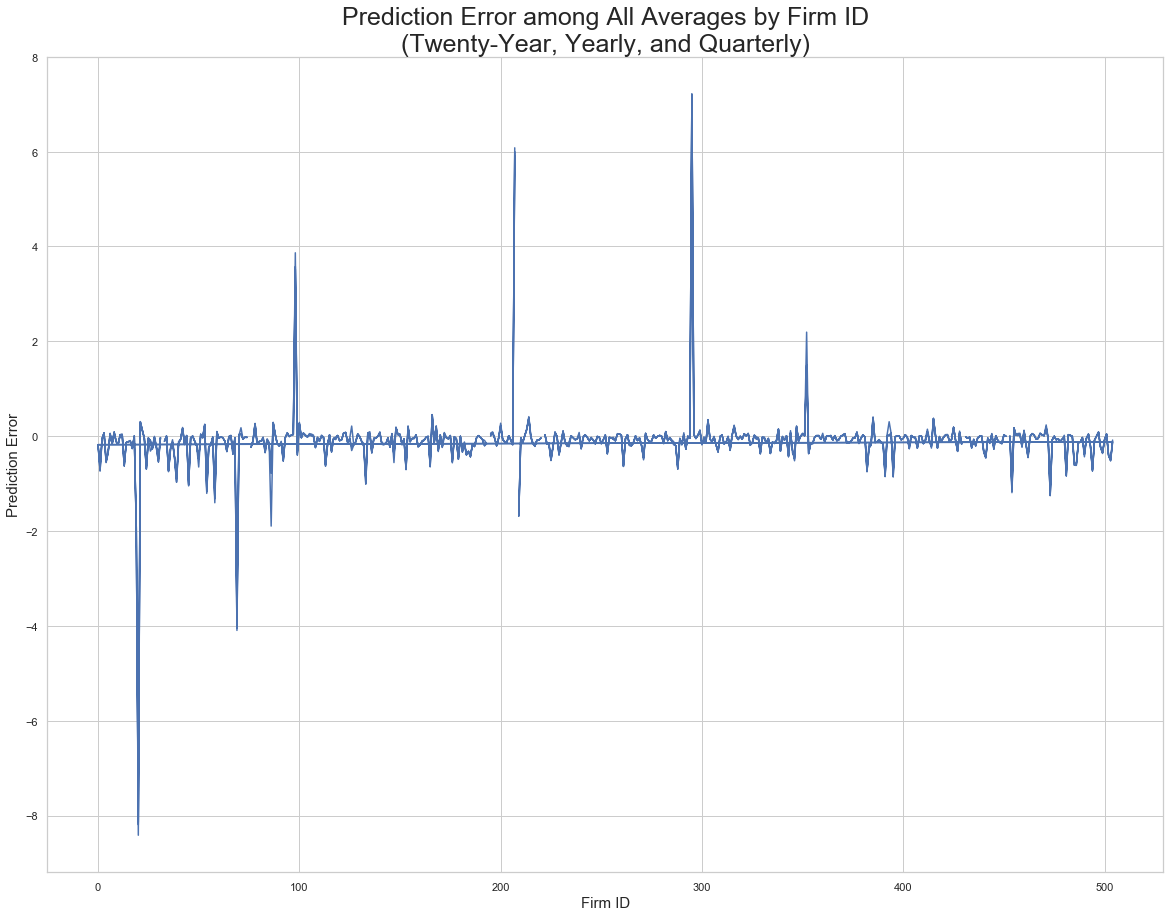

In [106]:
plt.figure(figsize = [20, 15])
plt.xlabel('Firm ID', size = 15)
plt.ylabel('Prediction Error', size = 15)
plt.title('Prediction Error among All Averages by Firm ID\n(Twenty-Year, Yearly, and Quarterly)', size = 25)
plt.plot(all_diffs['firm_id'], all_diffs['difference'])
# plt.scatter(twenty_diffs['firm_id'], twenty_diffs['difference'])
plt.savefig(PATH_BIVARIATE + 'avgs-diff-all.png')
plt.show();

**Observation:** Since ***all graphs depicting the average differences of forecasted and actual EPS, it is safe to use the `all_diffs` DF*** to answer for the yearly, quarterly, and twenty-year interpretations.

### Approach: Isolate the top 20 firms with the *largest absolute differences* (most inaccurate) and the top 20 firms with the *smallest absolute differences* (most accurate)

In [107]:
#helper function to convert a DF for firm_ids to their ticks
def convert_ids_to_ticks(series):
    series = series.apply(lambda x: firm_ids[firm_ids.firm_id == x].values[0][1]).values
    return [x.upper() for x in series]

In [108]:
#add column for absolute difference
all_diffs['difference_abs'] = all_diffs['difference'].abs()

In [109]:
#create column referring to firm tick
all_diffs['firm_tick'] = convert_ids_to_ticks(all_diffs.firm_id)

In [110]:
#rename column and values to fit legend
all_diffs.average_type = all_diffs.average_type.str.replace('_', ' ').str.capitalize()
all_diffs = all_diffs.rename(columns = {'average_type' : 'Average Type'})

**Twenty-Year**

In [111]:
#isolate twenty-year average type
twenty_diffs = all_diffs[all_diffs['Average Type'] == 'Twenty year']

In [112]:
#reorder firms by absolute difference
twenty_diffs_top = twenty_diffs.sort_values(by='difference_abs', ascending = False)
twenty_diffs_bottom = twenty_diffs.sort_values(by='difference_abs', ascending = True)

In [113]:
#drop rows with duplicate firm ids, get top 20 firm ids
twenty_diffs_top = twenty_diffs_top.drop_duplicates(subset = 'firm_id', keep = 'first').head(20)
twenty_diffs_bottom = twenty_diffs_bottom.drop_duplicates(subset = 'firm_id', keep = 'first').head(20)

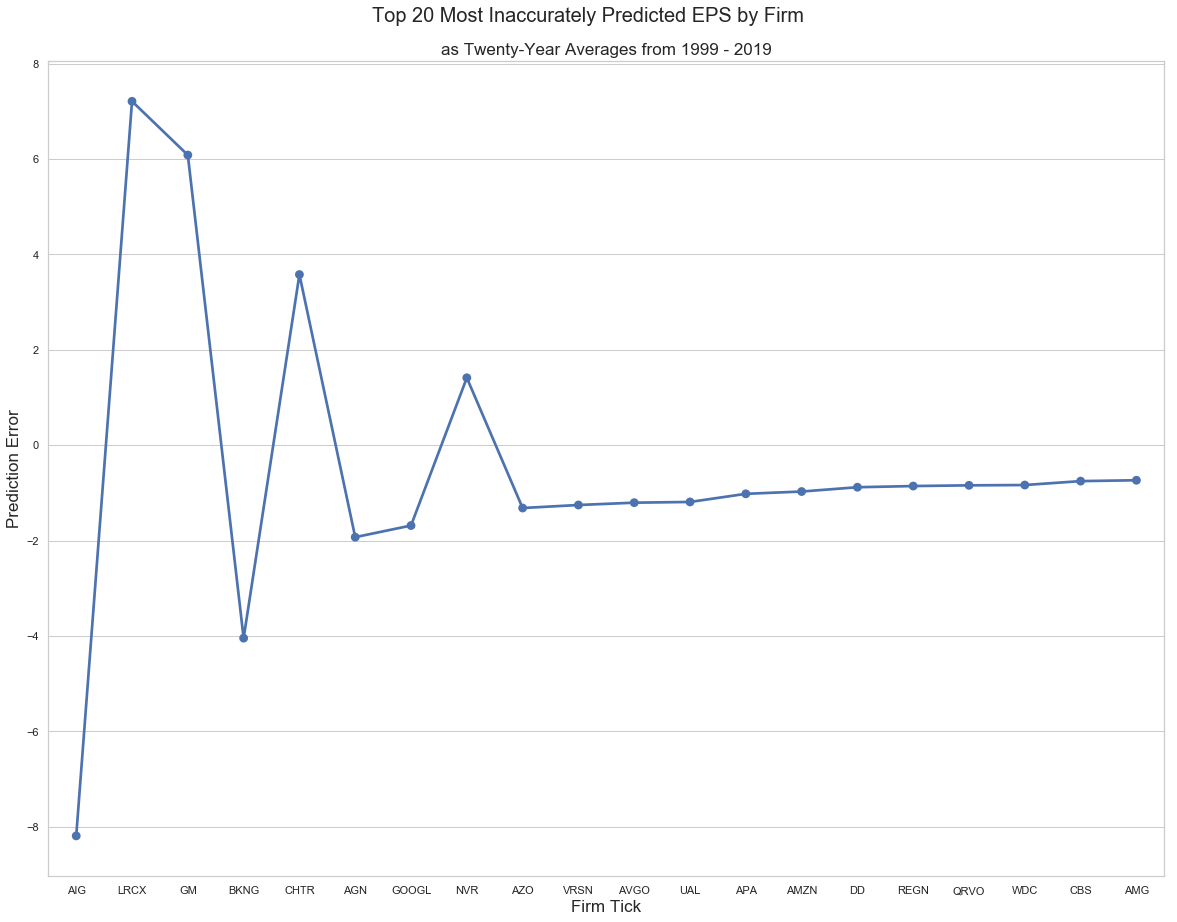

In [114]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = twenty_diffs_top.firm_tick, y = twenty_diffs_top.difference)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Twenty-Year Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year-top.png')

**The 9 most inaccurately predicted firm tickers are AIG, LRCX, GM, BKNG, CHTR, AGN, GOOGL, and NVR.**

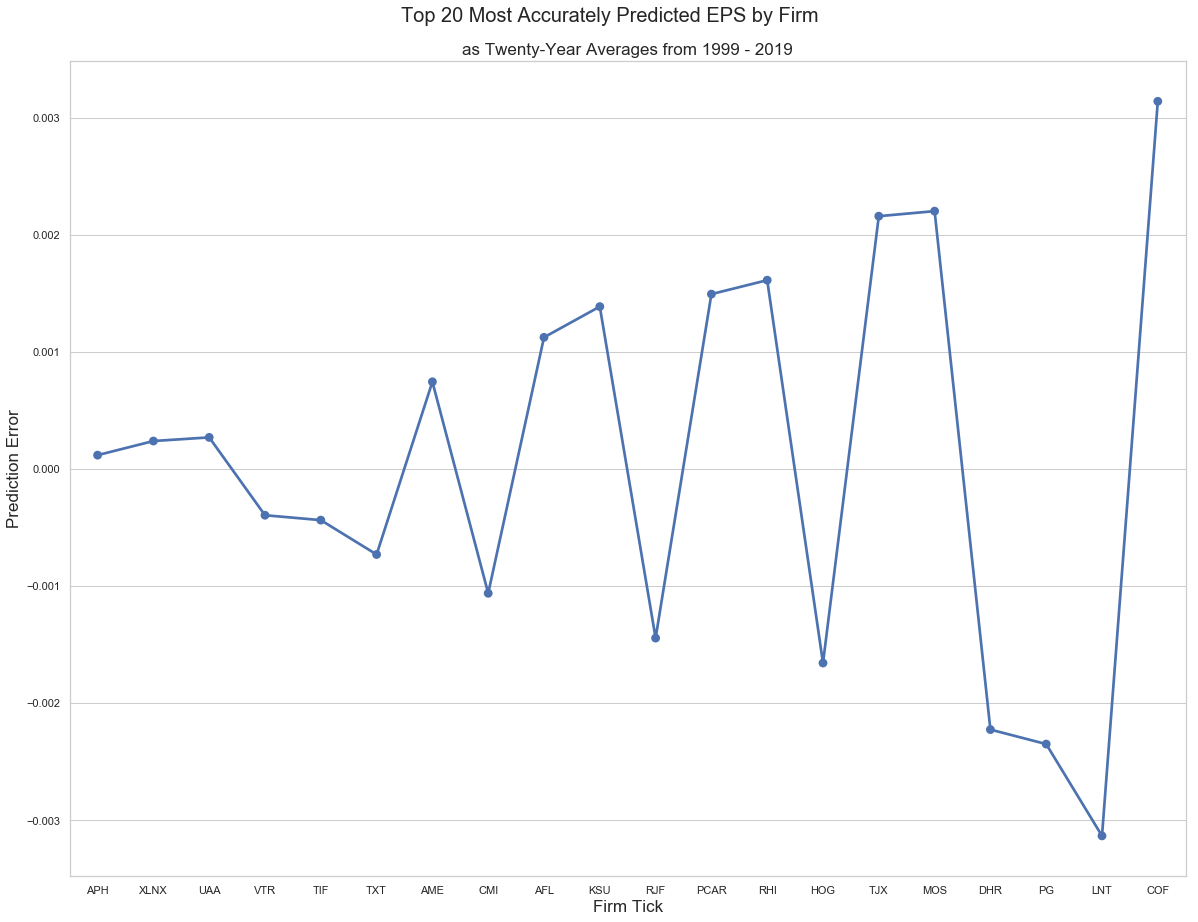

In [115]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = twenty_diffs_bottom.firm_tick, y = twenty_diffs_bottom.difference)

plt.suptitle('Top 20 Most Accurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Twenty-Year Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-twenty-year-bottom.png')

**At first, the trend appears unstable, and this is a tricky and wrong assumption. Visualizing that absolute value of each point proves that this trend among the top 20 most accurately predicted firms is a steady, linear pattern.**

**Quarterly**

In [116]:
#isolate twenty-year average type
quarter_diffs = all_diffs[all_diffs['Average Type'] == 'Quarter']

In [117]:
#create temp DF to get absolute mean difference of all firms
quarter_diffs_means = quarter_diffs.groupby('firm_tick').mean().reset_index()

In [118]:
#get firm ticks of top/bottom 20 firms
quarter_diffs_top_ids = quarter_diffs_means.sort_values(by = 'difference_abs', ascending = False).head(20).firm_tick.values
quarter_diffs_bottom_ids = quarter_diffs_means.sort_values(by = 'difference_abs', ascending = True).head(20).firm_tick.values

In [119]:
#filter quarterly DF for top/bottom firm ticks
quarter_diffs_top = quarter_diffs[quarter_diffs.firm_tick.isin(quarter_diffs_top_ids)]
quarter_diffs_bottom = quarter_diffs[quarter_diffs.firm_tick.isin(quarter_diffs_bottom_ids)]

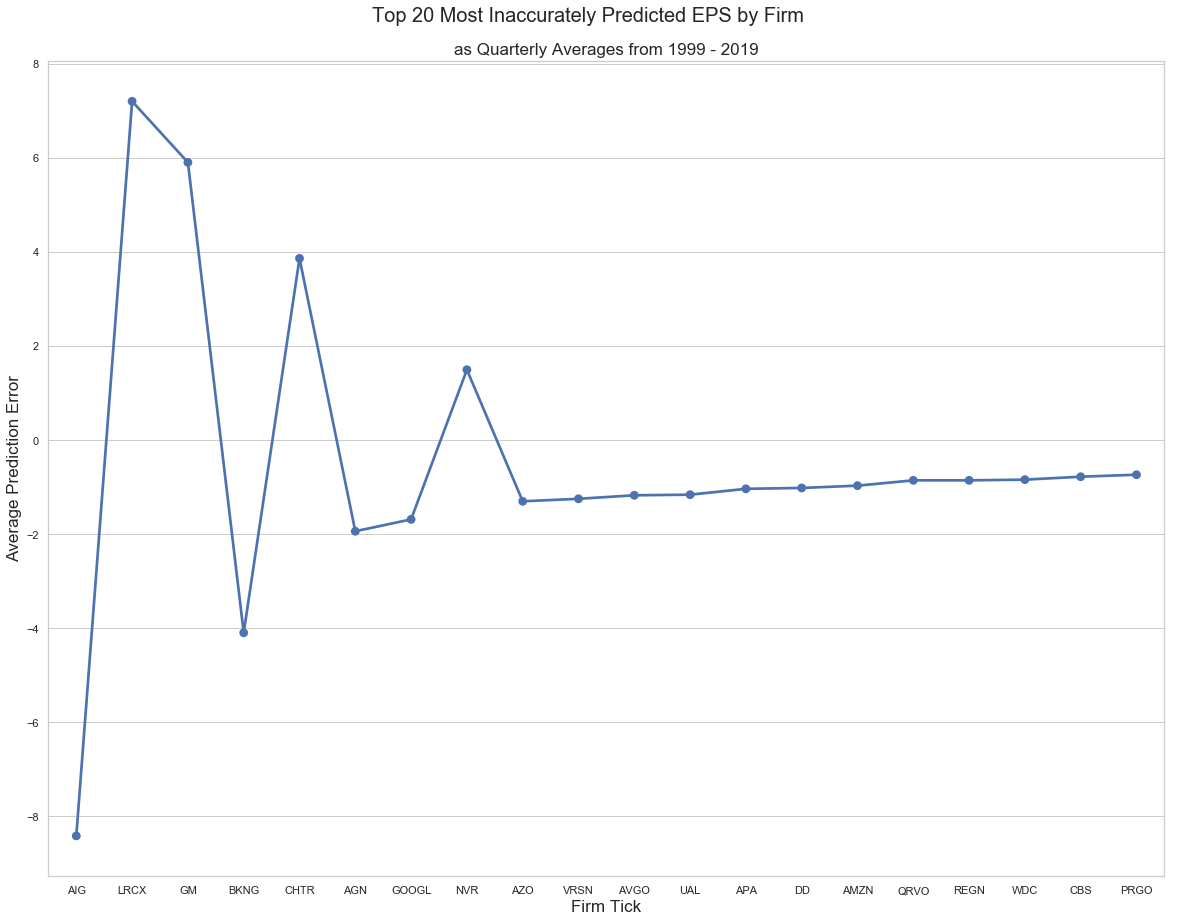

In [120]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = quarter_diffs_top.firm_tick, y = quarter_diffs_top.difference, order = quarter_diffs_top_ids)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Quarterly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter-top.png')

**The 9 most inaccurately predicted firms by quarterly average prediction error are AIG, LRCX, GM, BKNG, CHTR, AGN, GOOGL, NVR, and AZO.**

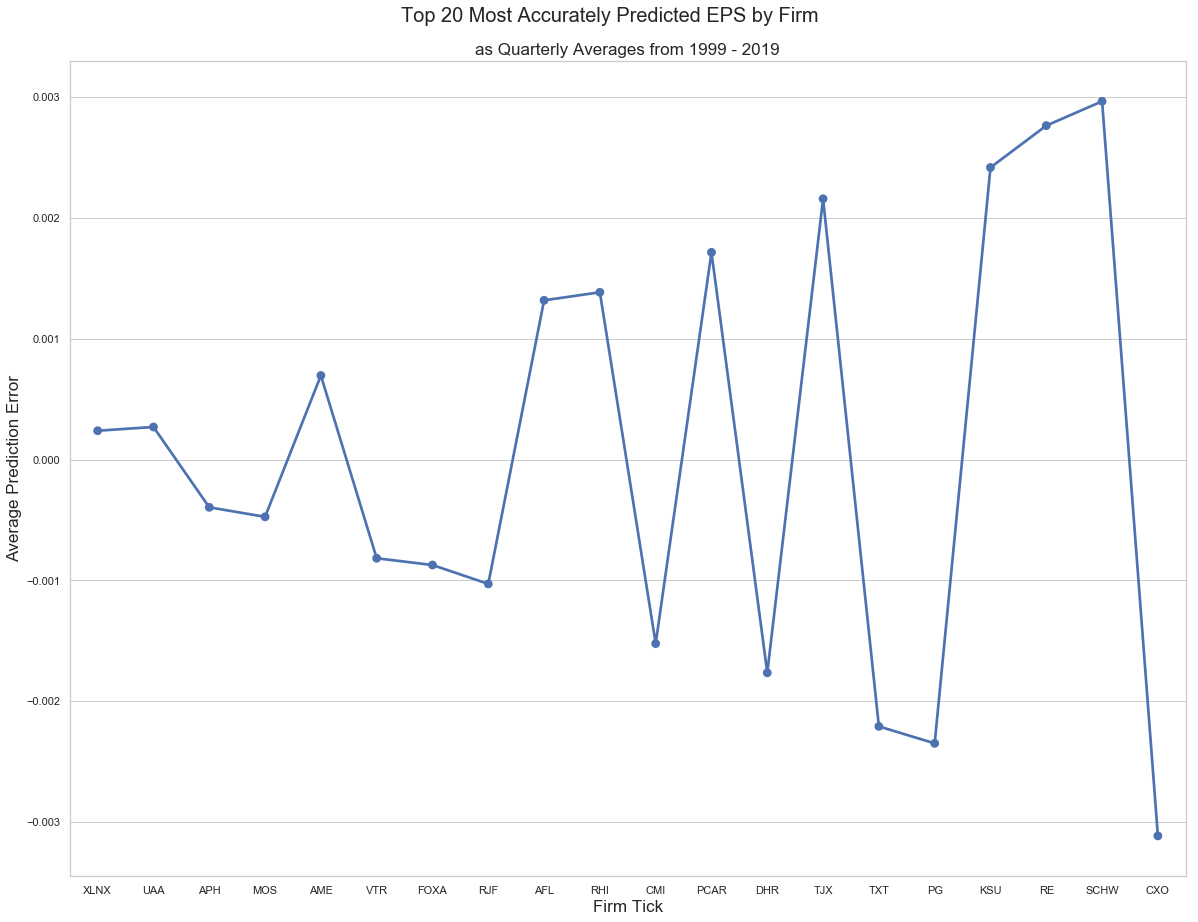

In [121]:
#plot firm IDs as CATEGORICAL variables by their respective quarterly differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = quarter_diffs_bottom.firm_tick, y = quarter_diffs_bottom.difference, order = quarter_diffs_bottom_ids)

plt.suptitle('Top 20 Most Accurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Quarterly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-quarter-bottom.png')

**Similar to the previous twenty-year prediction error point plot, this graph shows a general oscillation between negative and positive values. However, this does not matter in the long run, because the absolute distance between 0 and all the above y-values decreases.**

**Yearly**

In [122]:
#isolate yearly average types
year_diffs = all_diffs[all_diffs['Average Type'] == 'Year']

In [123]:
#create temp DF to get absolute mean difference for all firms
year_diffs_means = year_diffs.groupby('firm_tick').mean().reset_index()

In [124]:
#get firm ticks of top/bottom 20 firms
year_diffs_top_ids = year_diffs_means.sort_values(by = 'difference_abs', ascending = False).head(20).firm_tick.values
year_diffs_bottom_ids = year_diffs_means.sort_values(by = 'difference_abs', ascending = True).head(20).firm_tick.values

In [125]:
#filter yearly DF for top/bottom firm ticks
year_diffs_top = year_diffs[year_diffs.firm_tick.isin(year_diffs_top_ids)]
year_diffs_bottom = year_diffs[year_diffs.firm_tick.isin(year_diffs_bottom_ids)]

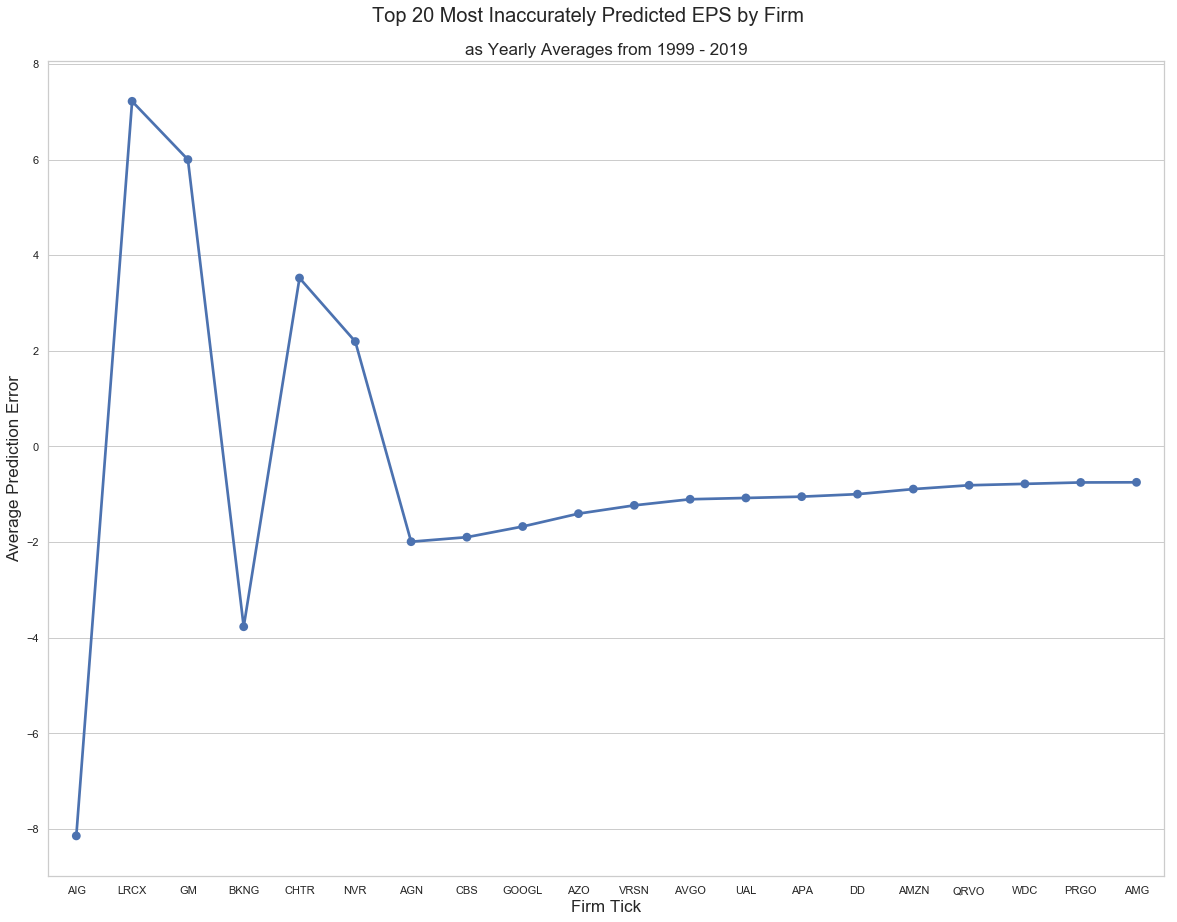

In [126]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = year_diffs_top.firm_tick, y = year_diffs_top.difference, order = year_diffs_top_ids)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('as Yearly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-year-top.png')

**The top 7 most inaccurately predicted firms by yearly average prediction errors are AIG, LRCX, GM, BKNG, CHTR, and NVR.**

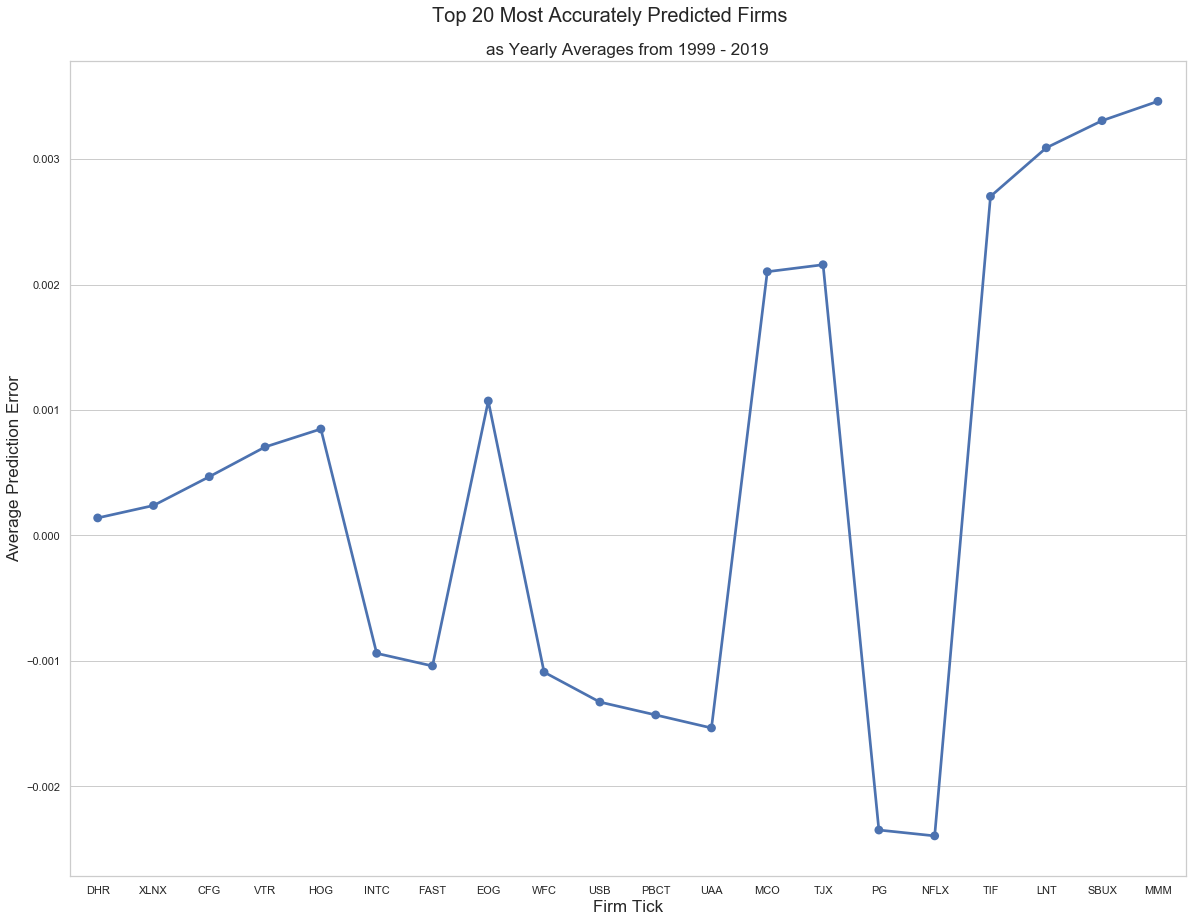

In [127]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = year_diffs_bottom.firm_tick, y = year_diffs_bottom.difference, order = year_diffs_bottom_ids)

plt.suptitle('Top 20 Most Accurately Predicted Firms', size = 20, y = .93)
plt.title('as Yearly Averages from 1999 - 2019', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-year-bottom.png')

**Consistent with previous trends, this graph of the 10 most accurate firms by yearly average predicted errors is varied in its collection of positive and negative values inching closer towards zero.**



**Twenty-Year, Quarterly, and Yearly**

> Main question: How do firms differ by forecast inaccuracy by average type (yearly, quarterly, and yearly)?

**Steps:**

1) Calculate the *average yearly, quarterly, and twenty-difference* for each firm.

2) Convert the new average differences to their absolute value.

3) Isolate the top 20 and bottom 20 firms by their average absolute distances.

4) Convert Firm IDs to Firm Ticks

5) Use those firm ticks to create a visualization using 2 different datasets:
- the `avgs` DF (all raw data)
- the `all_diffs` DF (filtered data)

In [128]:
#calculate average difference for all average types
all_diffs_means = all_diffs.groupby('firm_tick').mean().reset_index()

In [129]:
#get firm ticks of top/bottom 20 firms
all_diffs_top_ids = all_diffs_means.sort_values(by = 'difference_abs', ascending = False).head(20).firm_tick.values
all_diffs_bottom_ids = all_diffs_means.sort_values(by = 'difference_abs', ascending = True).head(20).firm_tick.values

In [130]:
#filter DF for top/bottom firm ticks
all_diffs_top = all_diffs[all_diffs.firm_tick.isin(all_diffs_top_ids)]
all_diffs_bottom = all_diffs[all_diffs.firm_tick.isin(all_diffs_bottom_ids)]

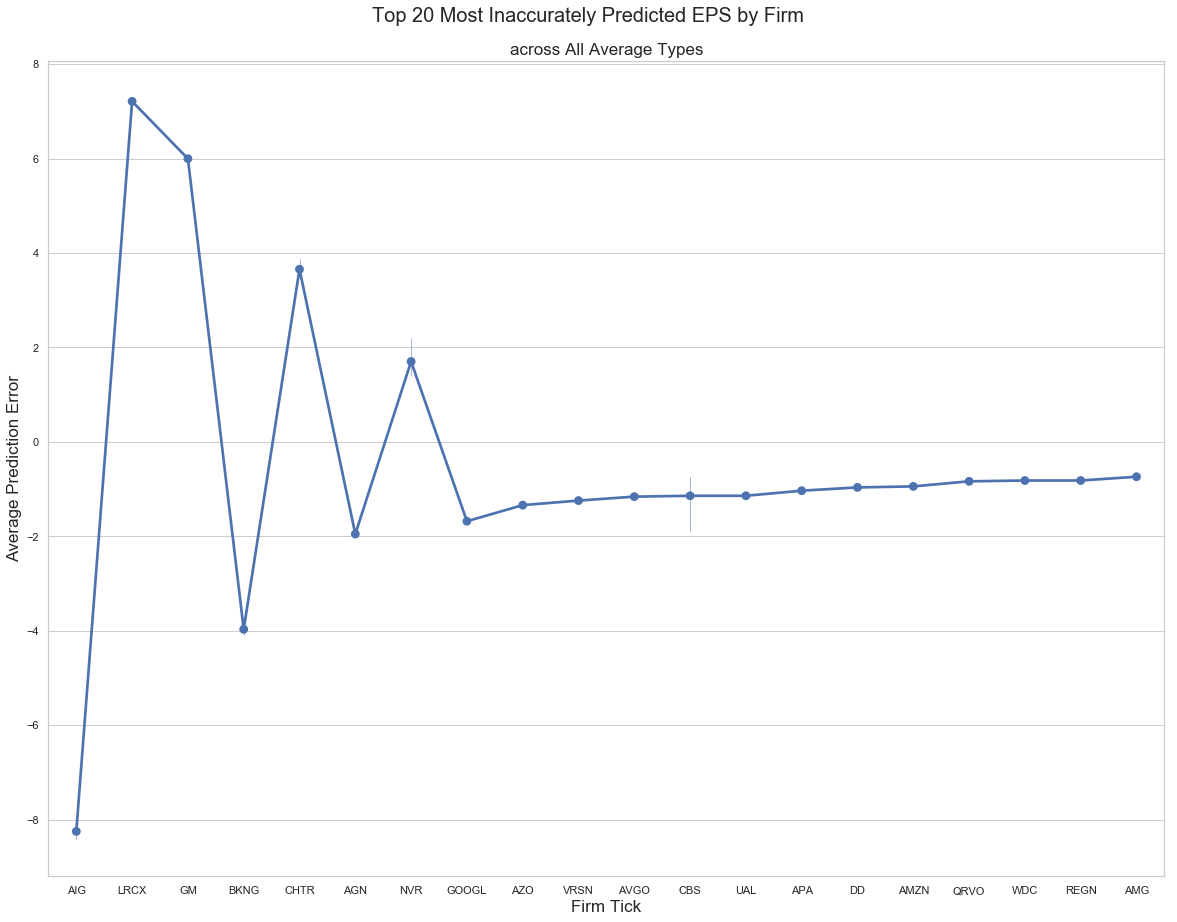

In [131]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = all_diffs_top.firm_tick, y = all_diffs_top.difference, order = all_diffs_top_ids, errwidth = 0.5)

plt.suptitle('Top 20 Most Inaccurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('across All Average Types', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-top.png')

**The top 8 most inaccurate firms by all average types are AIG, LRCX, GM, BKNG, CHTR, AGN, NVR, and GOOGL.**

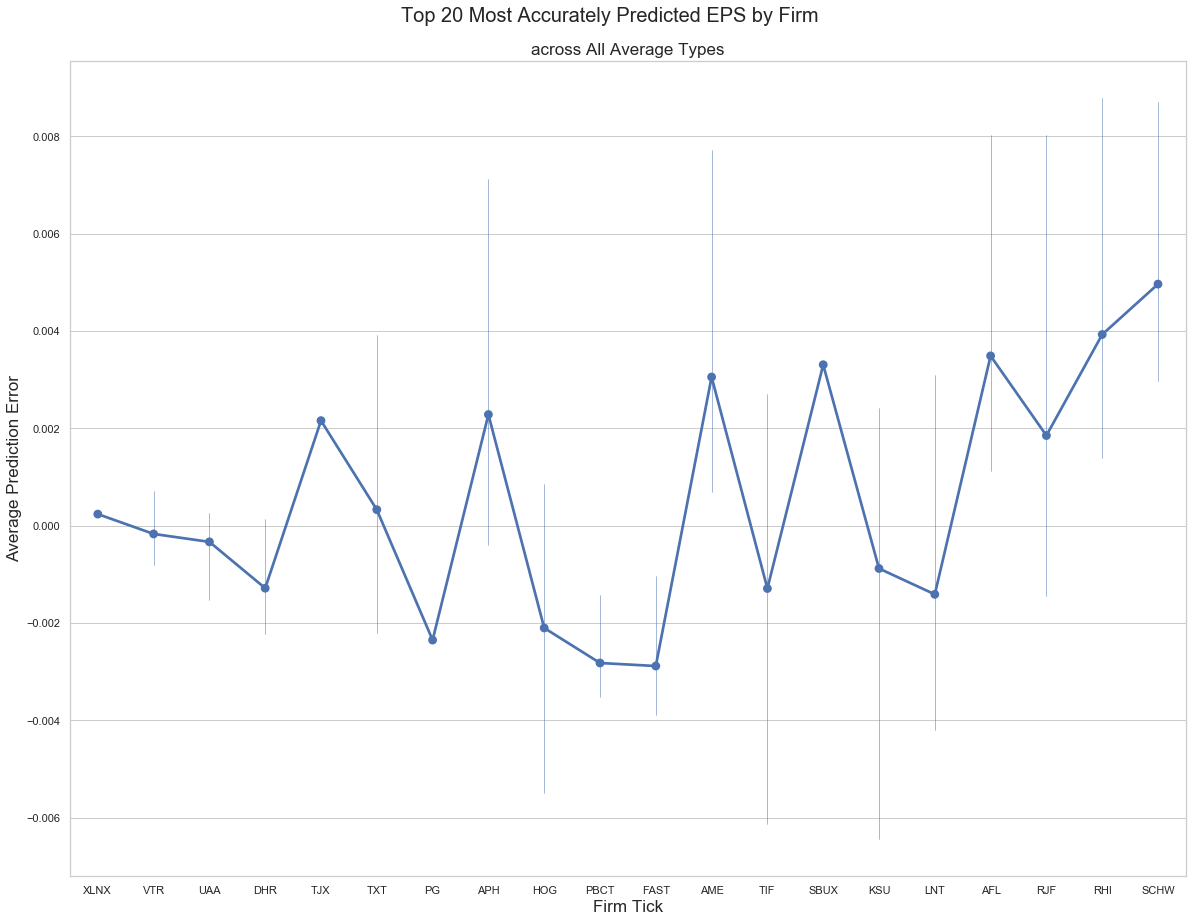

In [132]:
#plot firm IDs as CATEGORICAL variables by their respective twenty-year differences
plt.figure(figsize = [20, 15])

sb.pointplot(x = all_diffs_bottom.firm_tick, y = all_diffs_bottom.difference, order = all_diffs_bottom_ids, errwidth = 0.5)

plt.suptitle('Top 20 Most Accurately Predicted EPS by Firm', size = 20, y = .93)
plt.title('across All Average Types', size = 17)
plt.xlabel('Firm Tick', size = 17)
plt.ylabel('Average Prediction Error', size = 17)

plt.savefig(PATH_BIVARIATE + 'avgs-diff-all-bottom.png')

**The same trend of all values' absolute values steadily approaching 0. Nothing new.**

Now, let's look at the top 20 most inaccurate firms, where I isolated the first couple of firms before the general trend started normalizing, approaching to 0.

- *twenty-year* average prediction errors: AIG, LRCX, GM, BKNG, CHTR, AGN, GOOGL, and NVR.

- *quarterly* average prediction errors: AIG, LRCX, GM, BKNG, CHTR, AGN, GOOGL, NVR, and AZO.

- *yearly* average prediction errors: AIG, LRCX, GM, BKNG, CHTR, and NVR.

- *all* average prediction errors: AIG, LRCX, GM, BKNG, CHTR, AGN, NVR, and GOOGL.

> From the previous summaries, some interesting observations pop up:

**Observation 1:** AIG is consistently the most inaccurately-predicted firm across all twenty-year, quarterly, and/or yearly average types.

**Observation 2:** The firms in common—AIG, LRCX, GM, BKNG, CHTR, and NVR—are all ranked in the same order on the x-axis. Across all average types, these firms are consistent in their order.

**Observation 3:** AGN and GOOGL appears in all the above average types except *yearly*. This means GOOGL EPS more accurately forecasted on a solely by-year basis.

**Observation 4:** AZO appears only in the top 20 most inaccurate *quarterly* average prediction error DataFrame.


### Linear Regression Test for all EPS_ACT AVERAGES  vs. EPS_FC AVERAGES

> Considering that it's impossible to visually conclude a skew or distribution from the graphics alone, can we implement linear regression tests to verify that the relationship between forecasted and actual EPS is statistically significant?



For all linear regression tests, I will ***use the non-absolute values*** of the differences. This is because using a linear regression model on raw, unfiltered data will give more precise results.

H0: The higher the forecasted value, the higher the actual value.

H1: The higher the forecasted value, the lower or equal the actual value.

In [133]:
def implement_ols(df, y, x, avg_type):
    lm = sm.OLS(df[y], df[['intercept', x]], missing = 'drop')
    result = lm.fit()
    
    p_val = result.pvalues[x]
    coeff = result.params[x]
    r = math.sqrt(result.rsquared)
    
    return (result.summary(), avg_type, p_val, coeff, r)

**Isolate Twenty-Year EPS data by firm to fit OLS model**

In [134]:
#helper function to separate eps_act and eps_fc averages into their own columns
def separate_eps_fc_act(df, groupby_arr, value_col):
    #combine eps_fc and eps_act averages into a single column, joined on firm id and time period
    df1 = df.groupby(groupby_arr)[value_col].apply(lambda x: ', '.join(x.astype(str))).reset_index()
    
    #separate eps_fc and eps_act averages then rename columns
    df1 = pd.concat([df1[groupby_arr], df1[value_col].str.split(', ', expand = True)], axis = 1)
    df1.rename(columns = {0: 'eps_fc', 1: 'eps_act'}, inplace = True)
    
    #convert data types
    df1 = df1.astype({'eps_fc' : 'float64', 'eps_act' : 'float64'})
    
    #add intercept
    df1['intercept'] = 1
    
    return df1

In [135]:
avgs_twenty_ols = separate_eps_fc_act(avgs_twenty, ['firm_id', 'average_type'], 'average')
avgs_twenty_ols.sample(10)

firm_id average_type    eps_fc   eps_act  intercept
98        98  twenty_year  0.450026  4.026481          1
67        67  twenty_year  1.974690  1.600100          1
411      411  twenty_year  1.664000  1.565229          1
222      222  twenty_year  0.755012  0.783893          1
384      384  twenty_year  1.072362  0.881566          1
102      102  twenty_year  0.871250  0.936820          1
396      396  twenty_year  0.321631  0.311397          1
451      451  twenty_year  0.496250  0.495519          1
363      363  twenty_year  0.152750  0.149246          1
88        88  twenty_year  0.584405  0.624217          1

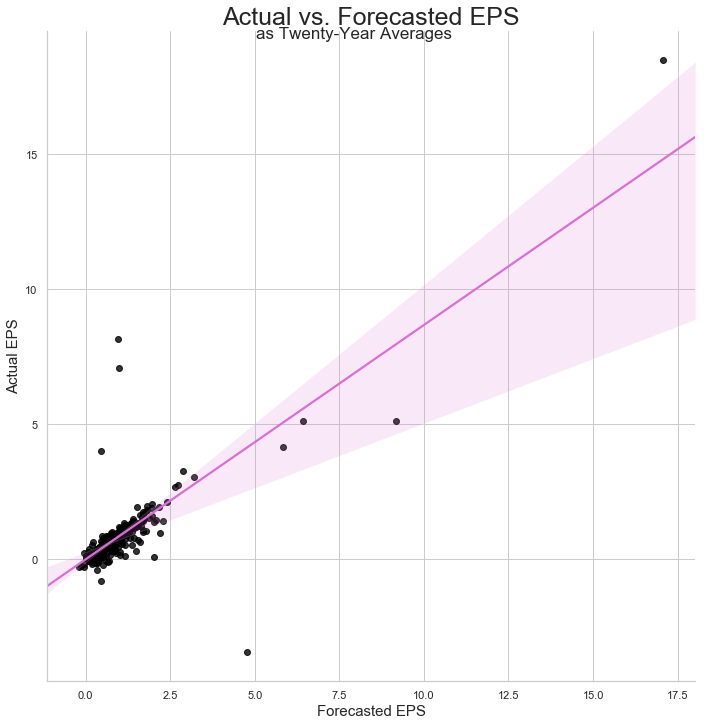

In [136]:
ax = sb.lmplot(data= avgs_twenty_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.title('Actual vs. Forecasted EPS', size = 25)
plt.suptitle('as Twenty-Year Averages', size = 17)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-act-fc-twenty.png')

**Observation 1:** The relationship between actual and forecasted EPS shows a wide variance in y-values from x = 0.0 to x = 9.0.

**Observation 2:** Most of the points are clustered between 0.0 and 2.5 on the x-axis. Besides that cluster, all other points are outliers, which contribute not only to the scatterplot's visible variance, but also lead the trend towards a general positive linear trend (after ignoring the outlier at x = 5.0, y = 0.25, of course)

**Observation 3:** The 95% confidence interval is wide TK

In [137]:
twenty_ols = implement_ols(avgs_twenty_ols, 'eps_act', 'eps_fc', 'Twenty-Year')
twenty_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     927.1
Date:                Fri, 01 May 2020   Prob (F-statistic):          1.33e-115
Time:                        14:27:22   Log-Likelihood:                -491.24
No. Observations:                 498   AIC:                             986.5
Df Residuals:                     496   BIC:                             994.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.037     -0.020      0.984      -0.073       0.072
eps_fc         0.8680      0.029     30.448      0.000       0.812       0.924
==============================================================================
Omnibus:                      366.690   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163395.963
Skew:                           1.937   Prob(JB):                         0.00
Kurtosis:                      91.654   Cond. No.                         2.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Isolate Quarterly EPS data by firm to fit OLS model**

In [138]:
avgs_quarter_ols = separate_eps_fc_act(avgs_quarter, ['firm_id', 'average_type', 'time_period'], 'average')
avgs_quarter_ols.sample(10)

firm_id average_type time_period    eps_fc   eps_act  intercept
132        33    quarterly          q1 -0.100714 -0.095714          1
1430      357    quarterly          q3  0.248190  0.306250          1
894       223    quarterly          q3  0.586143  0.728442          1
1982      495    quarterly          q3  0.676857  0.393333          1
1501      375    quarterly          q2  0.284286  0.312068          1
1678      419    quarterly          q3  0.874800  0.780227          1
1213      303    quarterly          q2  0.177500  0.244625          1
1022      255    quarterly          q3  0.193619  0.064739          1
1371      342    quarterly          q4  0.280952  0.291091          1
784       196    quarterly          q1  0.789333  0.911111          1

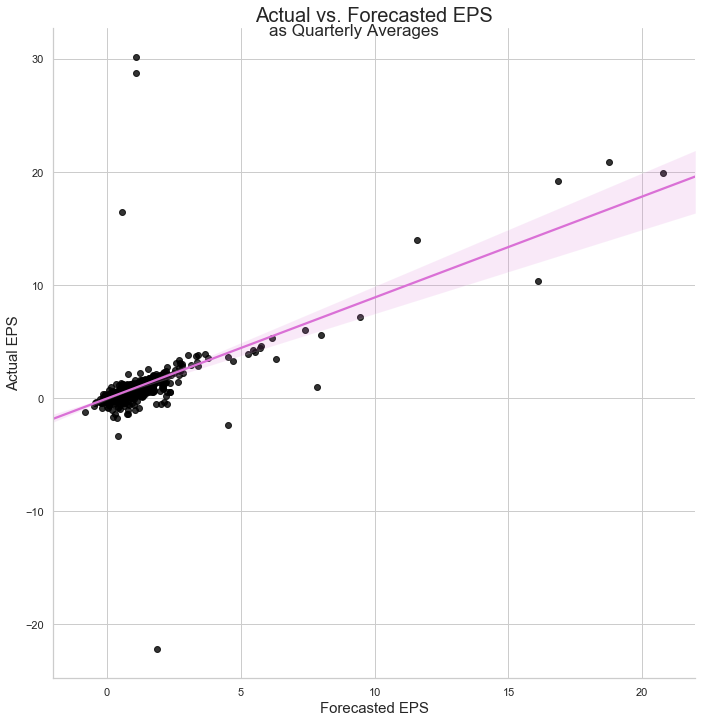

In [139]:
ax = sb.lmplot(data= avgs_quarter_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.title('Actual vs. Forecasted EPS', size = 20)
plt.suptitle('as Quarterly Averages', size = 17)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-act-fc-quarter.png')

**Observation 1:** Unlike the previous graph showing the twenty-year averages of forecasted and actual EPS, the confidence interval for quarterly averages is much more narrow. This means that ***the relationship between forecasted and actual EPS quarterly averages*** should be TK.

**Observation 2:** There is a similar pattern of all points being "clustered" at the beginning, with outliers being abundant outside of the initial x-range. Here, that range is from x = -1 to x = 3.5. 

**Observation 3:** Outliers among EPS quarterly averages are much more varied and pronounced, which causes the regression line to be much less steep than the regression line for twenty-year EPS averages. 

In [140]:
quarter_ols = implement_ols(avgs_quarter_ols, 'eps_act', 'eps_fc', 'Quarterly')
quarter_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     1291.
Date:                Fri, 01 May 2020   Prob (F-statistic):          3.26e-218
Time:                        14:27:23   Log-Likelihood:                -3163.6
No. Observations:                1988   AIC:                             6331.
Df Residuals:                    1986   BIC:                             6342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0228      0.033     -0.684      0.494      -0.088       0.042
eps_fc         0.8937      0.025     35.927      0.000       0.845       0.943
==============================================================================
Omnibus:                     3432.956   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         15378611.603
Skew:                          10.939   Prob(JB):                         0.00
Kurtosis:                     433.324   Cond. No.                         2.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Isolate Yearly EPS data by firm to fit OLS model**

In [141]:
avgs_year_ols = separate_eps_fc_act(avgs_year, ['firm_id', 'average_type', 'time_period'], 'average')
avgs_year_ols.sample(10)

firm_id average_type time_period   eps_fc   eps_act  intercept
8201      390       yearly        2010  0.56500  0.495000          1
9689      461       yearly        2007  1.03450  0.097500          1
1981       94       yearly        2006  0.04800  0.030000          1
771        36       yearly        2014  2.04350  1.697500          1
6474      308       yearly        2005  0.46625 -0.135000          1
4338      206       yearly        2011  0.41300  0.450000          1
6586      313       yearly        2012 -0.17825 -0.902500          1
6940      330       yearly        2009  0.72925  0.691653          1
5164      245       yearly        2018  1.18750  1.405000          1
2514      119       yearly        2014  0.20075  0.177500          1

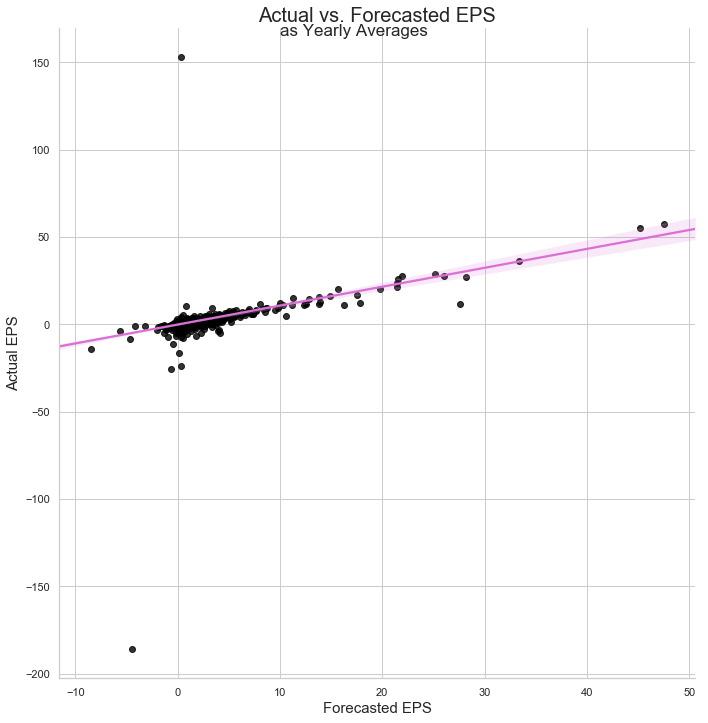

In [142]:
ax = sb.lmplot(data= avgs_year_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.title('Actual vs. Forecasted EPS', size = 20)
plt.suptitle('as Yearly Averages', size = 17)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'avgs-act-fc-year.png')

**Observation 1:** There is significantly less variance among yearly EPS averages, with only 2 outliers at x = -4 and x = 0.5. 

**Observation 2:** Compared to twenty-year and quarterly EPS averages, the 95% confidence interval for ***yearly EPS averages*** is much more narrow than both of them, which means that TK.

**Observation 3:** Residuals tend to stay closer to the regression line, implying that there is lower bias in the relationship between forecasted and actual yearly EPS averages.

In [143]:
year_ols = implement_ols(avgs_year_ols, 'eps_act', 'eps_fc', 'Yearly')
year_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     3147.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        14:27:27   Log-Likelihood:                -21086.
No. Observations:                8848   AIC:                         4.218e+04
Df Residuals:                    8846   BIC:                         4.219e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1440      0.032     -4.530      0.000      -0.206      -0.082
eps_fc         1.0824      0.019     56.097      0.000       1.045       1.120
==============================================================================
Omnibus:                    17981.094   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5446459294.082
Skew:                         -15.036   Prob(JB):                         0.00
Kurtosis:                    3846.500   Cond. No.                         2.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Isolate Raw EPS data by firm to fit OLS model**

In [144]:
features_eps_fc_act = features.loc[features['feature'].isin(['eps_act', 'eps_fc'])]
features_all_ols = separate_eps_fc_act(features_eps_fc_act, ['firm_id', 'term'], 'value')
features_all_ols.sample(10)

firm_id    term  eps_fc  eps_act  intercept
6549        77  2019Q2   1.000  0.84000          1
15187      180  2015Q4   0.203  0.19500          1
15196      180  2018Q1   0.309  0.30500          1
41542      494  2010Q3   1.499  1.50000          1
2779        33  2000Q4     NaN  0.57000          1
32297      384  2009Q2   0.557  0.80000          1
1060        12  2012Q1   0.606  0.62000          1
9397       111  2017Q2   1.898  1.96000          1
8421       100  2004Q2   0.540  0.87619          1
16395      195  2002Q4     NaN      NaN          1

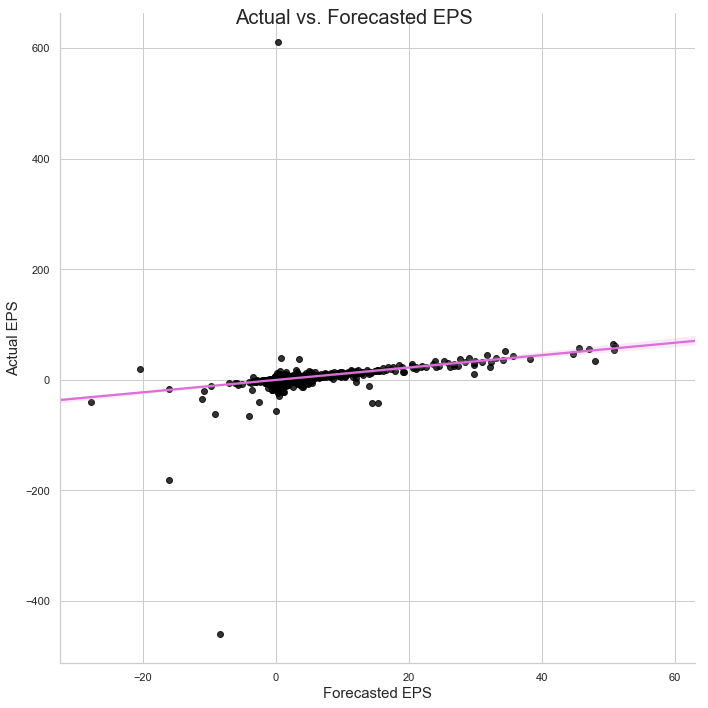

In [145]:
ax = sb.lmplot(data= features_all_ols, x = 'eps_fc', y = 'eps_act', height = 10, 
          scatter_kws = {'color' : 'black'}, line_kws = {'color' : 'orchid'})

plt.suptitle('Actual vs. Forecasted EPS', size = 20)
plt.xlabel('Forecasted EPS', size = 15)
plt.ylabel('Actual EPS', size = 15)

plt.savefig(PATH_BIVARIATE + 'features-act-fc-all.png')

**Observation 1:** The raw actual vs. forecasted EPS help paint a better overall picture of the trends.

**Observation 2:** The previous graphs depicting *averages* instead of *raw data* have clustered points at the beginning of the x-axis. But here, the scatterplot *starts* with 4 outliers until the first "cluster" of points takes place. 

**Observation 3:** From x = 0 onward, the initial cluster of points gradually declusters afterwards while maintaining minimal distance from the regression line as residuals. ***Out of all the regression plots depicting actual vs. forecasted EPS, the raw data displays the least amount of variance.*** This potentially could mean the lowest amount of bias as well.

**Observation 4:** The slope for raw EPS data is less steep than all of the three previous graphs, and this relationship depicts a slight positive linear relationship: the weakest linear trend out of them all.

**Observation 5:** The confidence interval for *raw EPS data* is much narrower, and virtually non-existent. This implies that TK

In [146]:
all_ols = implement_ols(features_all_ols, 'eps_act', 'eps_fc', 'All')
all_ols[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                eps_act   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5115.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        14:27:38   Log-Likelihood:                -99603.
No. Observations:               34448   AIC:                         1.992e+05
Df Residuals:                   34446   BIC:                         1.992e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1697      0.027     -6.399      0.000      -0.222      -0.118
eps_fc         1.1196      0.016     71.516      0.000       1.089       1.150
==============================================================================
Omnibus:                   106243.709   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     299298412516.719
Skew:                          45.670   Prob(JB):                         0.00
Kurtosis:                   14442.998   Cond. No.                         2.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Examine p-value, coeff, and r-value

In [147]:
#put all ols in an array
ols = [twenty_ols, quarter_ols, year_ols, all_ols]

In [148]:
statement = 'Actual EPS vs Forecasted EPS ({}):\np-value: {:.5f}\ncoefficient: {:.5f}\nr-value: {:.5f}\n'

#display p-value, coeff, and r-values
for ol in ols:
    print(statement.format(ol[1], ol[2], ol[3], ol[4]))

Actual EPS vs Forecasted EPS (Twenty-Year):
p-value: 0.00000
coefficient: 0.86799
r-value: 0.80713

Actual EPS vs Forecasted EPS (Quarterly):
p-value: 0.00000
coefficient: 0.89373
r-value: 0.62762

Actual EPS vs Forecasted EPS (Yearly):
p-value: 0.00000
coefficient: 1.08243
r-value: 0.51224

Actual EPS vs Forecasted EPS (All):
p-value: 0.00000
coefficient: 1.11957
r-value: 0.35956



> Check if the scatterplots are consistent with the results from their linear regression models.

**Observation 1:** The coefficient associated with `average_eps_fc` is 0.8680. This depicts a ***strong positive linear relationship*** between the forecasted and actual twenty-year EPS averages.

**Observation 2:** Let's establish our Type I error rate to be 0.05. The calculated p-value for `average_eps_fc` is 0.00. Since the p-value is less than our error threshold, ***the relationship between the twenty-year forecasted and actual EPS averages is statistically significant.***
> This is evidence in favor of my alternative hypothesis, therefore we ***accept the null hypothesis*** that as the value for forecasted twenty-year average EPS increases, the higher the actual value.



**Observation 1:** Interestingly enough, the graph encompassing the broadest data (all data from features) has the ***most stable 95% confidence interval*** as per the regression line.

**Observation 2:** The quarterly average regression line is the most unstable.

### "Dumb Predictions" vs "Expert Predictions"

1) Create a DF depicting `eps_act` last quarter vs `eps_act` this quarter.

2) Create "dumb predictions" 

3) Compare my predictions to all `eps_fc` values 

In [149]:
#isolate eps_act entries, drop date column
features_dumb_eps = features[features['feature'] == 'eps_act'].loc[:, features.columns != 'date']

In [150]:
#grab previous eps_act term
features_dumb_eps['previous_value'] = features_dumb_eps['value'].shift(1)

features_dumb_eps = features_dumb_eps[['firm_id', 'feature','term', 'value', 'previous_value']]

In [151]:
features_dumb_eps.head()

firm_id  feature    term  value  previous_value
125240        0  eps_act  1999Q1   0.16             NaN
125241        0  eps_act  1999Q2   0.35            0.16
125242        0  eps_act  1999Q3   0.30            0.35
125243        0  eps_act  1999Q4   0.32            0.30
125244        0  eps_act  2000Q1   0.29            0.32

> "Dumb Prediction" = the **moving average of the values from the last 2 quarters.**

In [152]:
#create dumb prediction
features_dumb_eps['dumb_prediction'] = features_dumb_eps.value.rolling(2).mean()

In [153]:
#preview
features_dumb_eps.head(5)

firm_id  feature    term  value  previous_value  dumb_prediction
125240        0  eps_act  1999Q1   0.16             NaN              NaN
125241        0  eps_act  1999Q2   0.35            0.16            0.255
125242        0  eps_act  1999Q3   0.30            0.35            0.325
125243        0  eps_act  1999Q4   0.32            0.30            0.310
125244        0  eps_act  2000Q1   0.29            0.32            0.305

In [154]:
#create column showing corresponding eps_fc for that term

#create Series of eps_fc values
features_fc = features[features.feature == 'eps_fc'].drop(columns = ['date', 'feature'])

In [155]:
features_fc.head()

firm_id    term  value
82820        0  1999Q1    NaN
82821        0  1999Q2    NaN
82822        0  1999Q3    NaN
82823        0  1999Q4    NaN
82824        0  2000Q1    NaN

In [156]:
#merge eps_fc values with dumb predictions on 'firm_id' and 'term'
features_dumb_eps = features_dumb_eps.merge(features_fc, on = ['term', 'firm_id'], how = 'left')
features_dumb_eps.rename(columns = {'value_x' : 'value', 'value_y' : 'eps_fc_value'}, inplace = True)

In [157]:
#create 3-year moving averages for all numerical fields
features_dumb_eps['ma_value'] = features_dumb_eps.value.rolling(12).mean()
features_dumb_eps['ma_previous_value'] = features_dumb_eps.previous_value.rolling(12).mean()
features_dumb_eps['ma_dumb_prediction'] = features_dumb_eps.dumb_prediction.rolling(12).mean()
features_dumb_eps['ma_eps_fc_value'] = features_dumb_eps.eps_fc_value.rolling(12).mean()

In [158]:
features_dumb_eps.sample(5)

firm_id  feature    term  value  previous_value  dumb_prediction  \
10681      127  eps_act  2002Q2   0.06        0.140000         0.100000   
23340      277  eps_act  2017Q1   0.28        0.130000         0.205000   
15093      179  eps_act  2013Q2   0.37        0.150000         0.260000   
16345      194  eps_act  2011Q2    NaN             NaN              NaN   
10857      129  eps_act  2004Q2   1.94        1.204616         1.572308   

       eps_fc_value  ma_value  ma_previous_value  ma_dumb_prediction  \
10681         0.060  0.135000           0.143333            0.139167   
23340         0.437  0.393333           0.400833            0.397083   
15093         0.258       NaN                NaN                 NaN   
16345           NaN       NaN                NaN                 NaN   
10857         1.309       NaN                NaN                 NaN   

       ma_eps_fc_value  
10681         0.154083  
23340         0.482750  
15093              NaN  
16345              NaN  
10857         0.753500

In [159]:
features_dumb_eps.head()

firm_id  feature    term  value  previous_value  dumb_prediction  \
0        0  eps_act  1999Q1   0.16             NaN              NaN   
1        0  eps_act  1999Q2   0.35            0.16            0.255   
2        0  eps_act  1999Q3   0.30            0.35            0.325   
3        0  eps_act  1999Q4   0.32            0.30            0.310   
4        0  eps_act  2000Q1   0.29            0.32            0.305   

   eps_fc_value  ma_value  ma_previous_value  ma_dumb_prediction  \
0           NaN       NaN                NaN                 NaN   
1           NaN       NaN                NaN                 NaN   
2           NaN       NaN                NaN                 NaN   
3           NaN       NaN                NaN                 NaN   
4           NaN       NaN                NaN                 NaN   

   ma_eps_fc_value  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

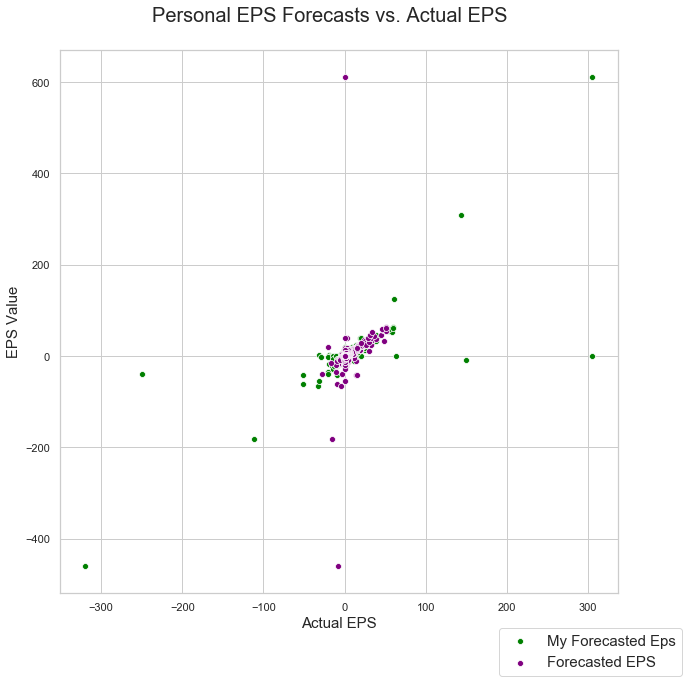

In [208]:
fig = plt.figure(figsize = [10, 10])

sb.scatterplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'green')
sb.scatterplot(data = features_dumb_eps, x = 'eps_fc_value', y = 'value', color = 'purple')

fig.legend(labels = ['My Forecasted Eps', 'Forecasted EPS'], prop = {'size' : 15}, loc = 'lower right')

plt.suptitle('Personal EPS Forecasts vs. Actual EPS', size = 20, y = .94)
# plt.title('in 3-year Moving Averages', size = 17)
plt.ylabel('EPS Value')
plt.xlabel('Actual EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-fc-scatter.png')
plt.show();

**Observation 1:** With actual EPS as the x-value, we can see that ***my personal forecasts*** show much more variance with outliers spreading across the entire scatterplot, in all 4 quartiles. If we ignored the outliers, then all of my personal forecasts cluster around (0, 0).

**Observation 2:** Similarly, ***experts' forecasted EPS*** has only 3 outliers and generally stays uniformly clustered around (0,0). This means that my approach of generating personal forecasts by 2-quarter averages is much less accurate than the method that Bloomberg forecasters had used.

**To confirm variance and bias, I decided to add two separate regression lines on the same scatterplot:**

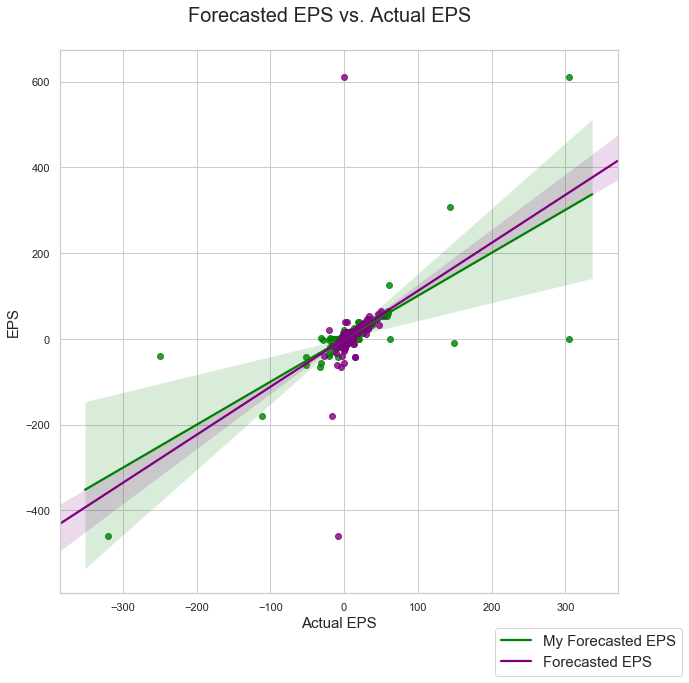

In [161]:
fig = plt.figure(figsize = [10, 10])

sb.regplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'green')
sb.regplot(data = features_dumb_eps, x = 'eps_fc_value', y = 'value', color = 'purple')

fig.legend(labels = ['My Forecasted EPS', 'Forecasted EPS'], prop = {'size' : 15}, loc = 'lower right')

plt.suptitle('Forecasted EPS vs. Actual EPS', size = 20, y = .94)
# plt.title('in 3-year Moving Averages', size = 17)
plt.ylabel('EPS')
plt.xlabel('Actual EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-fc-reg.png')
plt.show();

**Observation 1:** Not surprisingly, my ***personal forecasted EPS*** has a much wider 95% confidence interval than ***experts' forecasted EPS.*** Due to the wider variance for the former, those 2-quarter rolling averages would subsequently come equipped with a broader confidence interval scope.

**Observation 2:** Experts' forecasted EPS, while counting outliers, exhibits a greater rate of increase compared to my personal forecasts after x = 0. This means that when compared to actual EPS values, experts' forecasts tend to surpass my personal forecasts.

**Observation 3:** When ignoring outliers, experts' forecasted EPS and my personal forecasts clusters uniformly around (0, 0), with slightly more of my personal forecasts taking up the left side of the "cluster:" before x = 0. This confirms my previous statement that although both variables show a general consistent positive linear trend, my personal forecasts are ***less reliable*** and ***more inaccurate*** due to having more variance, outliers insonsistent with the pairing regression line trend, and moving-averages depend solely on historical data. 

**Observation 4:** Most of my personally generated outliers reside in Quartile I and the x-axis side of Quartile IV. All experts' forecasted EPS outliers reside in Quartiles II and III. Both forecasts' outliers are scattered in completely different quartiles from each other. This observation helps to ***further accentuate that although both regression lines share a linear positive trend, the distribution of outliers shows that both variables are not necessarily correlated to each other in terms of actual EPS.***


**2 Linear Regression Tests for My Predicted EPS & Forecasted EPS vs. Actual EPS**

In [162]:
#add intercept
features_dumb_eps_ols = features_dumb_eps.copy()
features_dumb_eps_ols['intercept'] = 1

In [163]:
#my forecast vs. actual
lm_dumb = sm.OLS(features_dumb_eps_ols['dumb_prediction'], features_dumb_eps_ols[['intercept', 'value']], missing = 'drop')
result_dumb = lm_dumb.fit()

result_dumb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        dumb_prediction   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 5.666e+04
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        14:27:47   Log-Likelihood:                -83164.
No. Observations:               36357   AIC:                         1.663e+05
Df Residuals:                   36355   BIC:                         1.663e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2667      0.013     21.118      0.000       0.242       0.291
value          0.6076      0.003    238.039      0.000       0.603       0.613
==============================================================================
Omnibus:                   108154.157   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     154136433848.584
Skew:                          41.401   Prob(JB):                         0.00
Kurtosis:                   10089.712   Cond. No.                         5.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
lm_fc = sm.OLS(features_dumb_eps_ols['eps_fc_value'], features_dumb_eps_ols[['intercept', 'value']], missing = 'drop')
result_fc = lm_fc.fit()

result_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eps_fc_value   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5115.
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        14:27:47   Log-Likelihood:                -60477.
No. Observations:               34448   AIC:                         1.210e+05
Df Residuals:                   34446   BIC:                         1.210e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7034      0.008     92.170      0.000       0.688       0.718
value          0.1155      0.002     71.516      0.000       0.112       0.119
==============================================================================
Omnibus:                    53211.382   Durbin-Watson:                   0.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        335545890.869
Skew:                           8.808   Prob(JB):                         0.00
Kurtosis:                     486.182   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

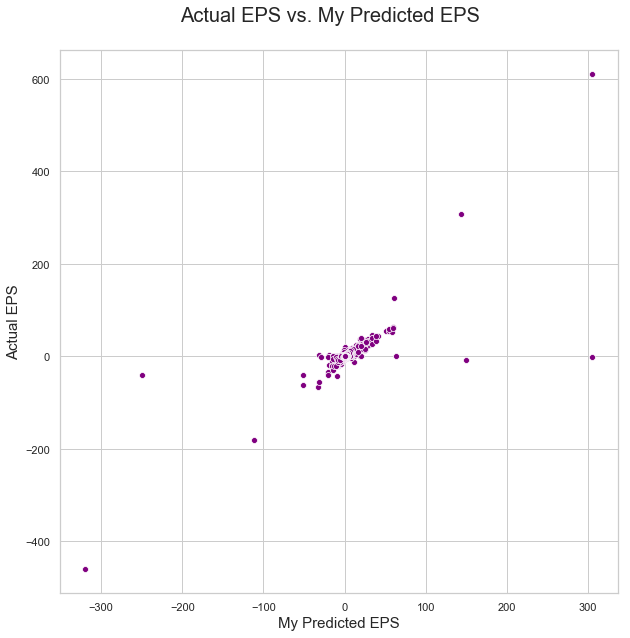

In [165]:
fig = plt.figure(figsize = [10, 10])

sb.scatterplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'purple')

plt.suptitle('Actual EPS vs. My Predicted EPS', size = 20, y = .94)
plt.ylabel('Actual EPS')
plt.xlabel('My Predicted EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-scatter.png')
plt.show();

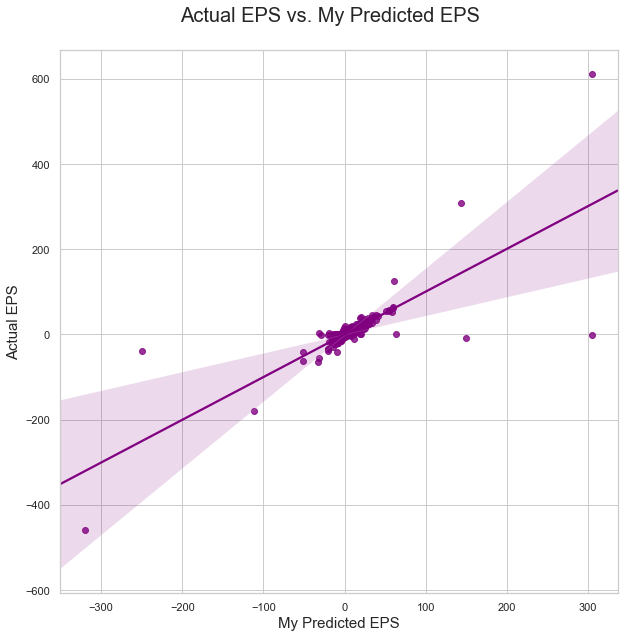

In [166]:
fig = plt.figure(figsize = [10, 10])

sb.regplot(data = features_dumb_eps, x = 'dumb_prediction', y = 'value', color = 'purple')

plt.suptitle('Actual EPS vs. My Predicted EPS', size = 20, y = .94)
plt.ylabel('Actual EPS')
plt.xlabel('My Predicted EPS')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-act-reg.png')
plt.show();

**My personal forecasts by using rolling averages accounts only for predictions from previous trends—completely reliant on historical census—and does not take into account the largely dynamic structure of the stock market.** However, it is noteworthy that my personally generated forecasts still depicted a similar, if not consistent, trend pattern with experts' forecasted EPS.

In [167]:
lm_dumb_act = sm.OLS(features_dumb_eps_ols['value'], features_dumb_eps_ols[['intercept', 'dumb_prediction']], missing = 'drop')
result_dumb_act = lm_dumb_act.fit()

result_dumb_act.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                 5.666e+04
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        14:27:51   Log-Likelihood:                -92270.
No. Observations:               36357   AIC:                         1.845e+05
Df Residuals:                   36355   BIC:                         1.846e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0064      0.016      0.392      0.695      -0.026       0.038
dumb_prediction     1.0026      0.004    238.039      0.000       0.994       1.011
==============================================================================
Omnibus:                    50305.992   Durbin-Watson:                   2.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      65797589437.202
Skew:                           5.856   Prob(JB):                         0.00
Kurtosis:                    6593.463   Cond. No.                         3.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
value_vars = ['value', 'previous_value', 'dumb_prediction', 'eps_fc_value', 'ma_value', 'ma_previous_value',
             'ma_dumb_prediction', 'ma_eps_fc_value']

In [169]:
#melt dumb_predictions and eps_fc_value to prepare for plotting
df_dumb_eps_melt = pd.melt(features_dumb_eps, id_vars = ['firm_id', 'feature', 'term'],
       value_vars = value_vars,
       var_name = 'value_type')

In [210]:
#isolate only dumb predictions and eps_fc_value
dumb_eps_fc = df_dumb_eps_melt[df_dumb_eps_melt.value_type.isin(['dumb_prediction', 'eps_fc_value', 'value'])]

In [171]:
dumb_eps_fc['ma_value'] = dumb_eps_fc.value.rolling(12).mean()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [211]:
dumb_eps_fc.sample(5)

firm_id  feature    term       value_type  value
4707         56  eps_act  1999Q4            value    NaN
114307      350  eps_act  2015Q4  dumb_prediction  0.260
149040      259  eps_act  2005Q1     eps_fc_value  0.180
22521       268  eps_act  2001Q2            value  0.280
140121      153  eps_act  2001Q2     eps_fc_value  0.693

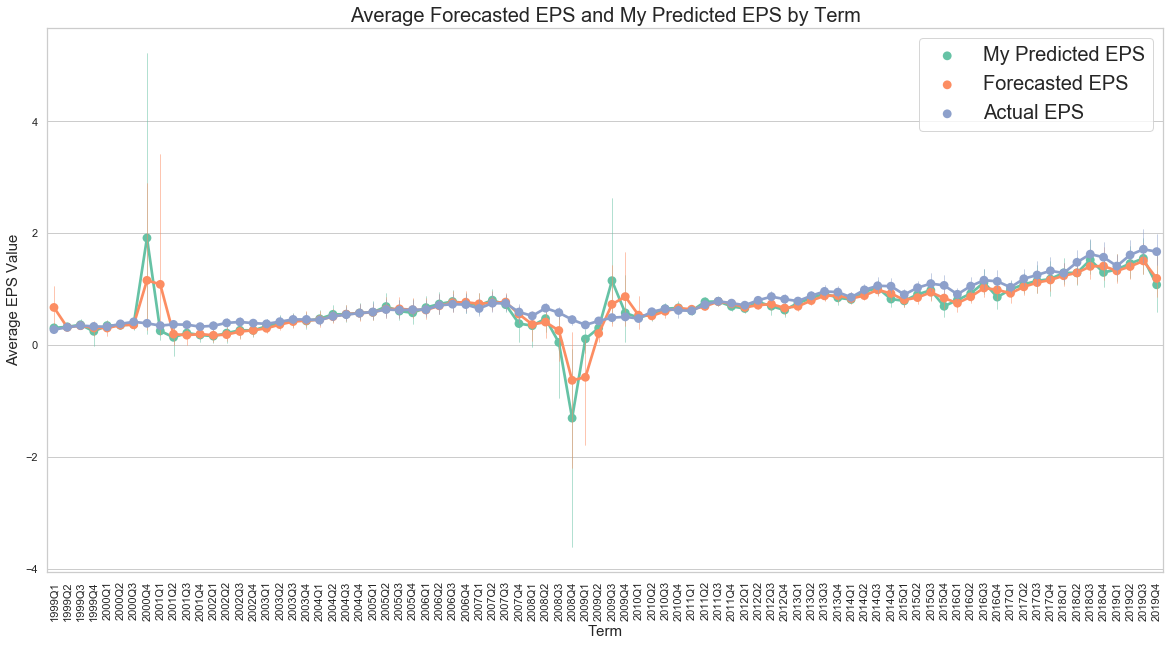

In [216]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(x = 'term', y = 'value', data = dumb_eps_fc, hue = 'value_type',
                  errwidth = .5, palette = 'Set2')

plt.xticks(rotation = 'vertical')

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['My Predicted EPS', 'Forecasted EPS', 'Actual EPS'], prop = {'size' : 20})

plt.title('Average Forecasted EPS and My Predicted EPS by Term', size = 20)
plt.ylabel('Average EPS Value')
plt.xlabel('Term')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-eps.png')
plt.show();

In [229]:
#isolate actual EPS and personal predicted EPS
ma_dumb_fc = df_dumb_eps_melt[df_dumb_eps_melt.value_type.isin(['ma_dumb_prediction', 'ma_value', 'ma_eps_fc_value'])]

In [230]:
ma_dumb_fc.value_type.unique()

array(['ma_value', 'ma_dumb_prediction', 'ma_eps_fc_value'], dtype=object)

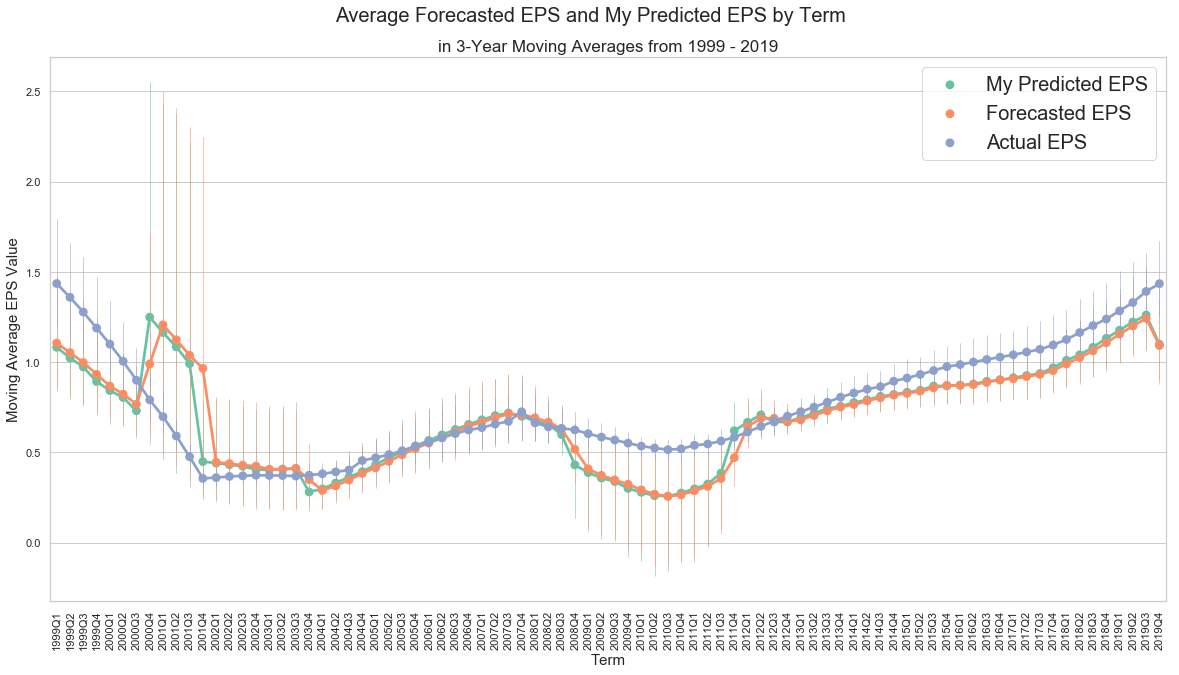

In [231]:
plt.figure(figsize = [20, 10])
ax = sb.pointplot(x = 'term', y = 'value', data = ma_dumb_fc, hue = 'value_type',
                  errwidth = .5, palette = "Set2")

plt.xticks(rotation = 'vertical')

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ['My Predicted EPS', 'Forecasted EPS', 'Actual EPS'], prop = {'size' : 20})

plt.suptitle('Average Forecasted EPS and My Predicted EPS by Term', size = 20, y = .95)
plt.title('in 3-Year Moving Averages from 1999 - 2019', size = 17)
plt.ylabel('Moving Average EPS Value')
plt.xlabel('Term')

plt.savefig(PATH_MULTIVARIATE + 'features-dumb-eps-ma.png')
plt.show();

**Observation 1:** In the first figure, my predicted EPS has strayed drastically away from the more normal forecasted EPS general trend pattern in 2 instances. Between ***2000Q4*** and ***2001Q1***, my forecasts become optimistic, forming a 2-point peak before jumping back into the uniform trend. Between ***2008Q4*** and ***2009Q1***, my forecasts become pessimistic, forming a 2-point trough before hopping back up into the uniform trend similar to the actual EPS trend.

**Observation 2:** When plotting moving averages per term, both trend lines follow an almost-identical polynomial trend, overall leading into a direction of a positive slope. 

The technique that the Bloomberg forecasters used was much more effective than my method of predicting by using 2-quarter moving averages.

## V) Multivariate Exploration <a id="multi"></a>

### Time vs. Percentage Error vs. Firm IDs

In [181]:
#add percentage_error column to features
features_pct = features[features.feature.isin(['eps_fc', 'eps_act'])]

In [182]:
features_pct = separate_eps_fc_act(features_pct, ['firm_id', 'term'], 'value')

In [183]:
features_pct['pct_error'] = (features_pct.eps_act - features_pct.eps_fc) / features_pct.eps_act

In [184]:
features_pct['pct_error'] = features_pct['pct_error'].replace([np.inf, -np.inf], np.nan)

In [185]:
#get absolute value of percentage errors
features_pct['pct_error_abs'] = features_pct.pct_error.abs()

In [186]:
#add tick column for plotting assisance
features_pct['firm_tick'] = convert_ids_to_ticks(features_pct.firm_id)

In [187]:
#add 3-year moving averages for percentage error
features_pct['ma_pct_error'] = features_pct.pct_error.rolling(12).mean()

In [188]:
#grab top/bottom 10 firms
features_pct_top_ids = features_pct.sort_values(by = 'pct_error_abs', ascending = False).firm_id.drop_duplicates().head(5).values
features_pct_bottom_ids = features_pct.sort_values(by= 'pct_error_abs', ascending = True).firm_id.drop_duplicates().head(5).values

In [189]:
#filter DF for those 10 firms
features_pct_top = features_pct[features_pct.firm_id.isin(features_pct_top_ids)]
features_pct_bottom = features_pct[features_pct.firm_id.isin(features_pct_bottom_ids)]

> **Percentage Error by Year**

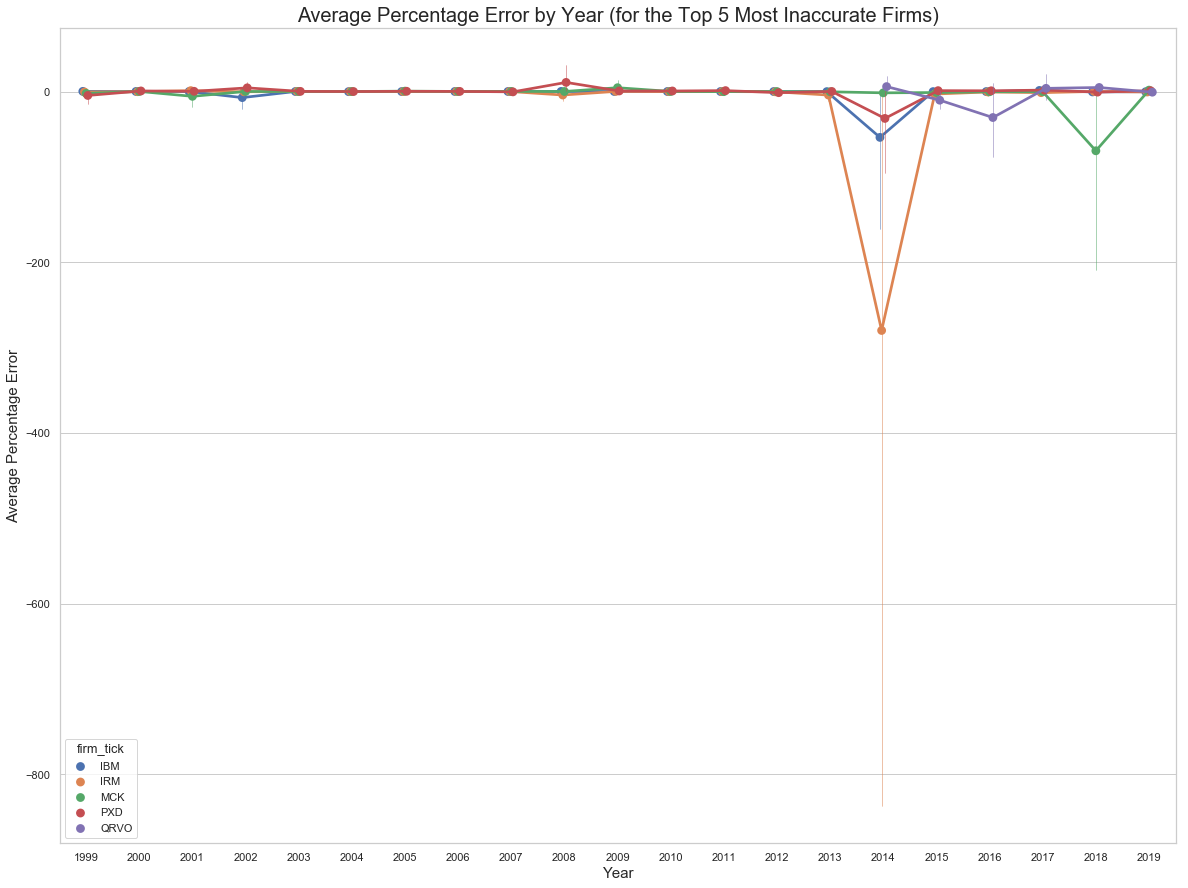

In [190]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = features_pct_top, x = features_pct_top.term.dt.year, y = 'pct_error',
                  hue = 'firm_tick', dodge = True, legend_out = False, errwidth = 0.5)


plt.xlabel('Year')
plt.ylabel('Average Percentage Error')
plt.title('Average Percentage Error by Year (for the Top 5 Most Inaccurate Firms)', size = 20)

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-year-top.png')
plt.show()

**The above visual isn't great for analysis. Let's look at a strip plot distribution instead.**

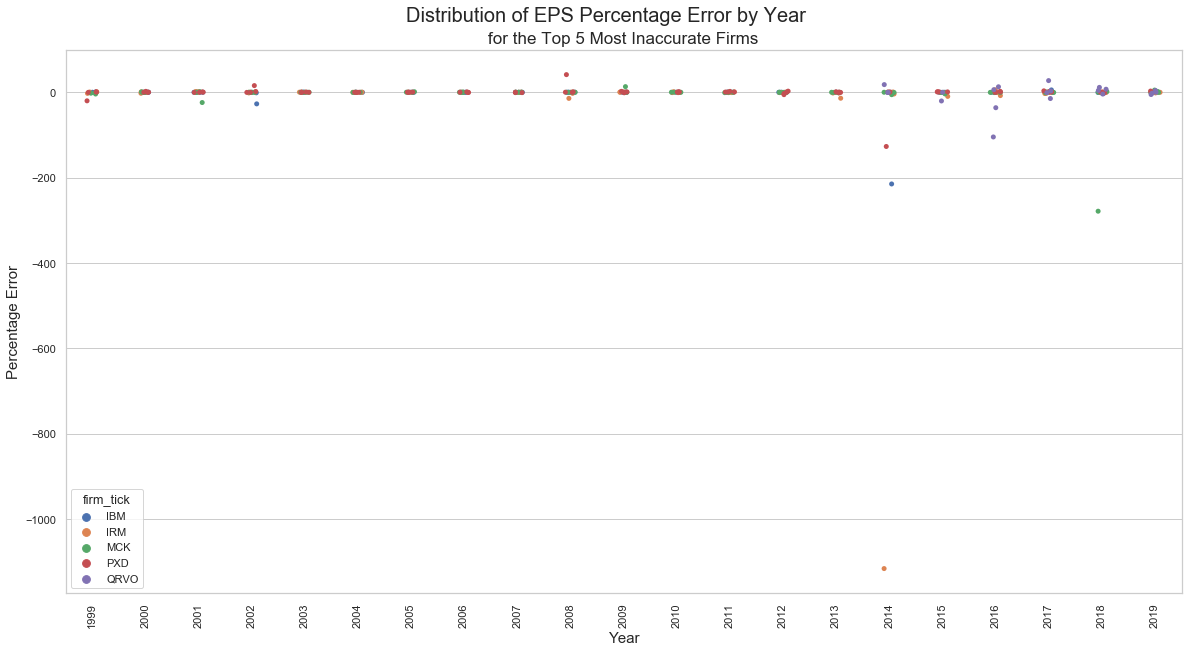

In [191]:
plt.figure(figsize = [20, 10])
sb.stripplot(data = features_pct_top, x = features_pct_top.term.dt.year, y = 'pct_error', hue = 'firm_tick')
plt.xticks(rotation = 'vertical')

plt.suptitle('Distribution of EPS Percentage Error by Year', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)

plt.xlabel('Year')
plt.ylabel('Percentage Error')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-year-top-strip.png')

**Observation 1:** The most notable outlier is IRM, with a percentage error of over -1000 for EPS in the year 2014.

**Observation 2:** BIM, IRM, MCK, PXD, and QRVO are the five most inaccurately predicted firms in terms of percentage error by year.

**Observation 3:** All other firms beside IRM share large distance gaps from 2014 - 2018 with IRM in 2014.

**Observation 4:** Outliers only started showing up in distributions starting on the year 2014. Therefore, this means that ***EPS forecasts have become more inaccurate in the more recent years, starting from 2014.***

> **Percentage Error by Quarter**

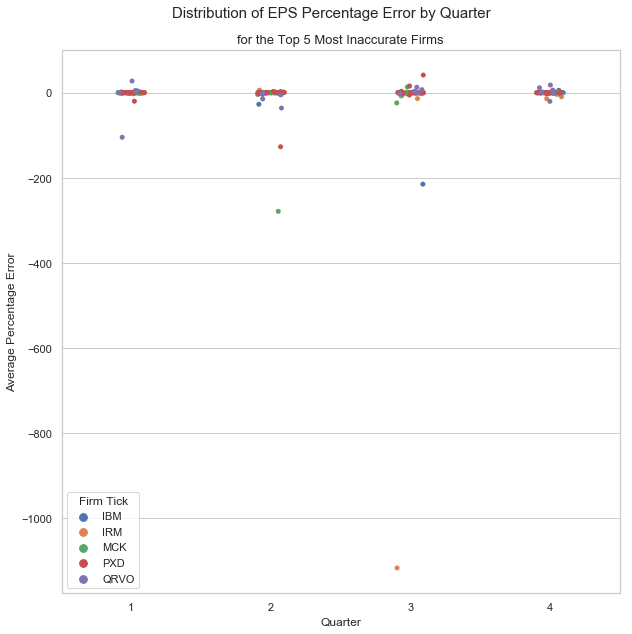

In [193]:
plt.figure(figsize = [10, 10])
ax = sb.stripplot(data = features_pct_top, x = features_pct_top.term.dt.quarter, y = 'pct_error',
                  hue = 'firm_tick', jitter = True)

plt.suptitle('Distribution of EPS Percentage Error by Quarter', size = 15, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 13)
plt.ylabel('Average Percentage Error', size = 12)
plt.xlabel('Quarter', size = 12)
plt.legend(title = 'Firm Tick')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-quarter-top-strip.png')

**Observation 1:** The most notable outlier is IRM yet again, with a percentage error of over -1000 for EPS in Quarter 3.

**Observation 2:** IBM, IRM, MCK, PXD, and QRVO are the five most inaccurately predicted firms in terms of percentage error by quarter. This list is the same as the previous stripplot and pointplot depicting years.

**Observation 3:** Quarter 4 is the only quarter with no outliers. This makes intuitive sense because as the quarters in any singular year pass and familiarity with the current fiscal year builds, the more accurate forecasted EPS would be. Let us test this theory.

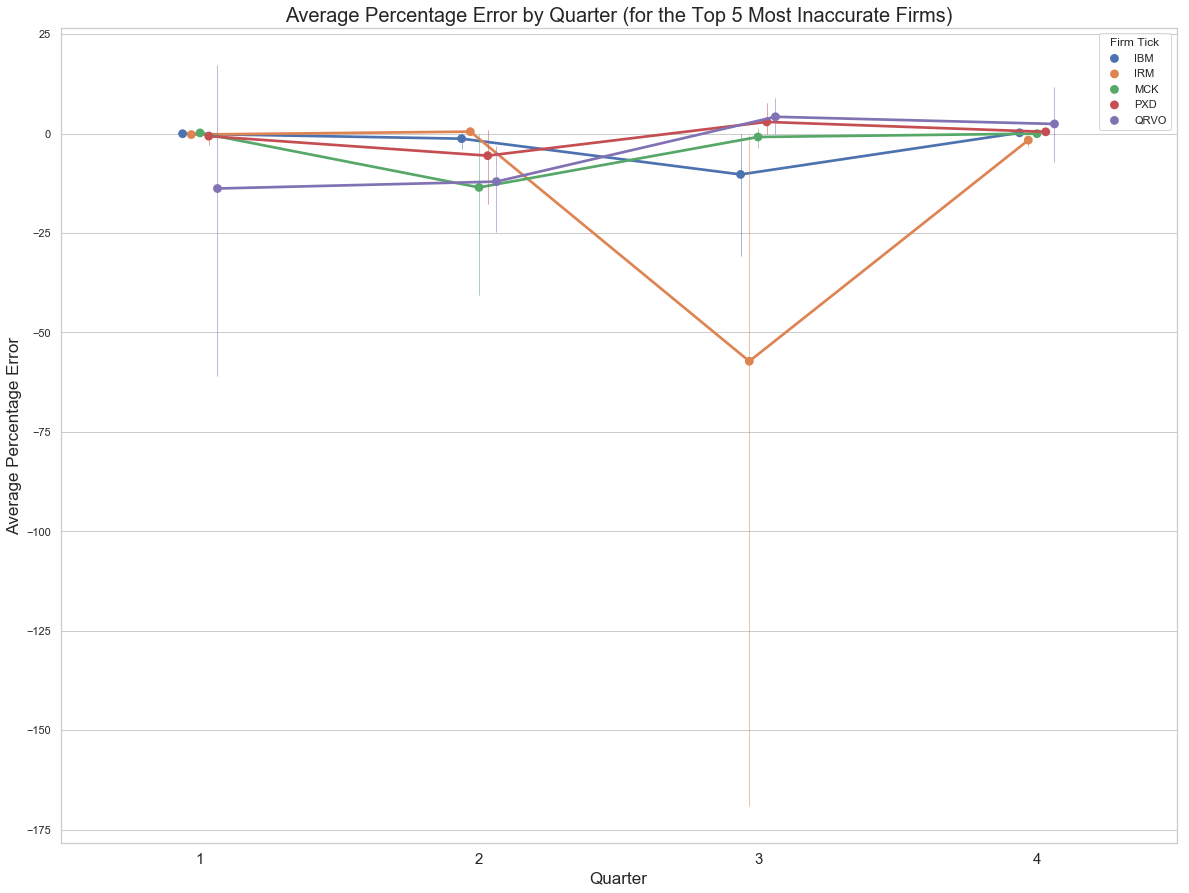

In [194]:
plt.figure(figsize = [20, 15])
ax = sb.pointplot(data = features_pct_top, x = features_pct_top.term.dt.quarter, y = 'pct_error', hue = 'firm_tick', dodge = True,
                  legend_out = False, errwidth = 0.5)

plt.xlabel('Quarter', size = 17)
plt.ylabel('Average Percentage Error', size = 17)
plt.title('Average Percentage Error by Quarter (for the Top 5 Most Inaccurate Firms)', size = 20)
plt.xticks(size = 15)
plt.legend(title = 'Firm Tick')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-quarter.png')
plt.show()

**Observation 1:** The firms IRM and IBM deviate greatly in Quarter 3, where forecasters' predictions veer away from zero. Meanwhile, the other firms cluster more closely around 0. ***The most inaccurate predictions, on average, happen to be made during Quarter 3 in any given year.*** 

**Observation 2:** The previous observation disproves my initial intuition that forecasters' predictions would become more accurate by the quarter.

> **Percentage Error by Year and Quarter**


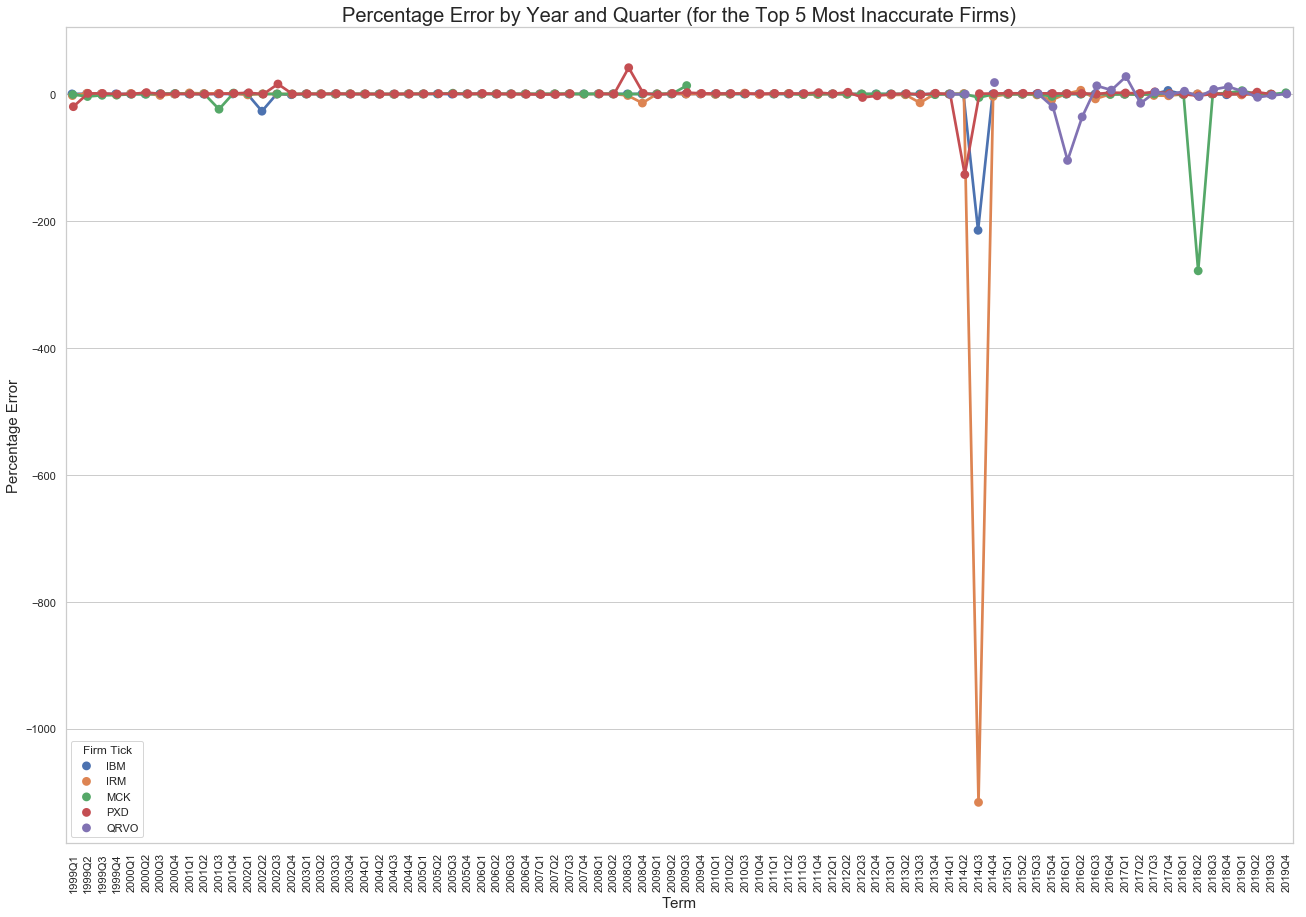

In [195]:
plt.figure(figsize = [22, 15])
ax = sb.pointplot(data = features_pct_top, x = 'term', y = 'pct_error', hue = 'firm_tick', dodge = True,
                  legend_out = False)

plt.xlabel('Term')
plt.ylabel('Percentage Error')
plt.title('Percentage Error by Year and Quarter (for the Top 5 Most Inaccurate Firms)', size = 20)
plt.xticks(rotation = 'vertical')
plt.legend(title = 'Firm Tick')

plt.savefig(PATH_MULTIVARIATE + 'pct-firm-term.png')
plt.show()

**This isn't a very good visualization either. Let's look at a stripplot instead:**

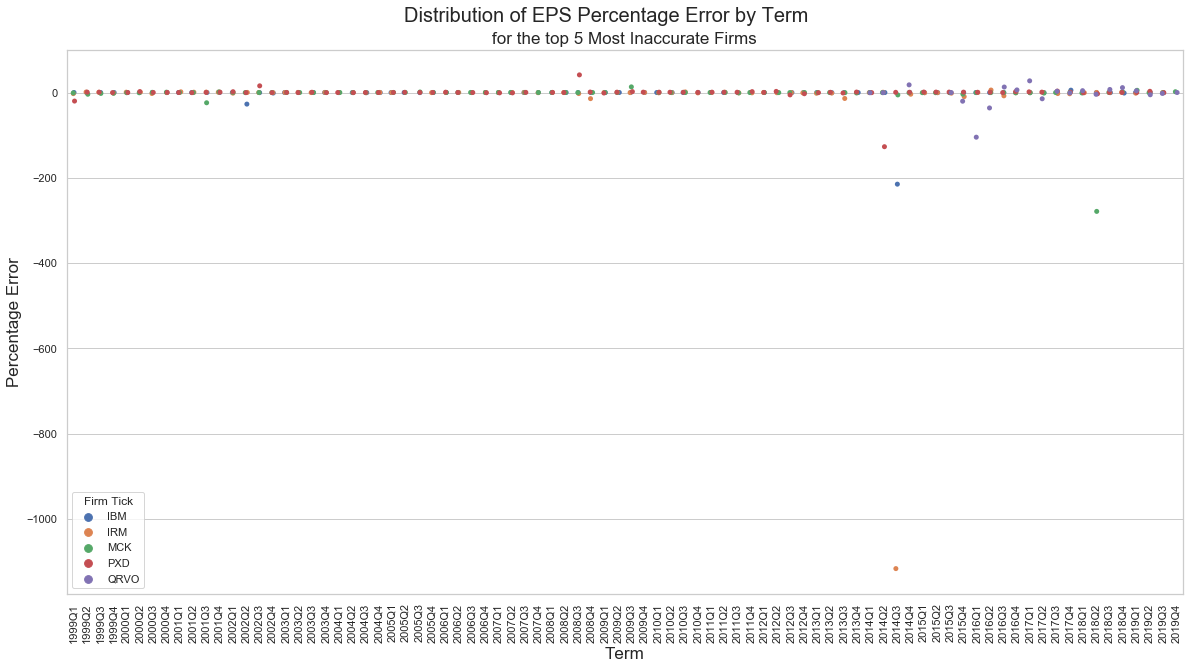

In [196]:
plt.figure(figsize = [20, 10])
sb.stripplot(data = features_pct_top, x = 'term', y = 'pct_error', hue = 'firm_tick')

plt.suptitle('Distribution of EPS Percentage Error by Term', size = 20, y = .94)
plt.title('for the top 5 Most Inaccurate Firms', size = 17)

plt.xlabel('Term', size = 17)
plt.ylabel('Percentage Error', size = 17)
plt.xticks(rotation = 'vertical')
plt.legend(title = 'Firm Tick')

plt.savefig(PATH_MULTIVARIATE + 'pct-ferm-tirm-strip.png')
plt.show();

**Observation 1**: The most notable outlier is IRM, with a percentage error of over -1000 for EPS in the term 2014Q3.

**Observation 2**: BIM, IRM, MCK, PXD, and QRVO are the five most inaccurately predicted firms in terms of percentage error by term. This list is consistent for the previous plots feature standalone *quarters* and *years*.

**Observation 3**: outliers start after 2014Q3. In the next terms, outliers tend to year in Q1 and Q3 exclusively; much more Q3.

**Observation 4**: All other firms beside IRM share large distance gaps from 2014Q3 - 2018Q3 from IRM in 2014Q3.

**Observation 5**: Outliers only started showing up in distributions starting in the year 2014. Therefore, this means that ***EPS forecasts have become more inaccurate in the more recent terms, starting from 2014Q3.*** This conclusion is consistent with the observation made in the quarterly and yearly stripplots & pointplots.

### Prediction Error by Term by Top 5 Firms

In [201]:
features_pct['difference'] = features_pct.eps_act - features_pct.eps_fc

In [202]:
features_pct['difference_abs'] = features_pct.difference.abs()

In [203]:
diffs_top_ids = features_pct.sort_values(by = 'difference_abs', ascending = False).firm_id.drop_duplicates().head(5).values
diffs_bottom_ids = features_pct.sort_values(by = 'difference_abs', ascending = True).firm_id.drop_duplicates().head(5).values

In [204]:
diffs_top = features_pct[features_pct.firm_id.isin(diffs_top_ids)]
diffs_bottom = features_pct[features_pct.firm_id.isin(diffs_bottom_ids)]

> **Prediction Error by Term**

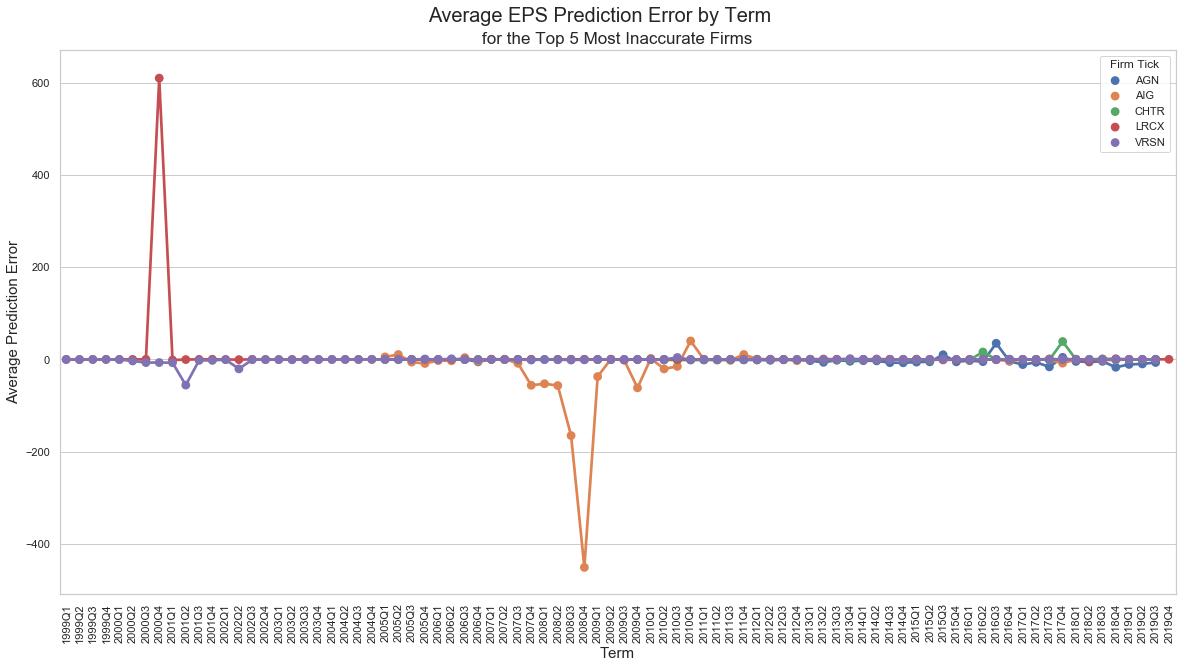

In [232]:
plt.figure(figsize = [20, 10])
sb.pointplot(data = diffs_top, x = diffs_top.term, y = 'difference', hue = 'firm_tick', errwidth = 0.5)

plt.legend(title = 'Firm Tick')
plt.xticks(rotation = 'vertical')
plt.xlabel('Term')
plt.ylabel('Average Prediction Error')
plt.suptitle('Average EPS Prediction Error by Term', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)

plt.savefig(PATH_MULTIVARIATE + 'features-perror-term-firm.png')
plt.show();

**Observation 1:** The 2 most noticeable outliers are the firm AIG in 2008Q4 (optimistic forecasts), and LRCX in 2000Q3 (pessimistic forecasts).

**Observation 2:** The 5 most inaccurate firms by prediction error are AGN, AIG, CHTR, LRCX, and VRSN.

**Observation 3:** VRSN is the most stable of the top 5 most inaccurate firms; its average prediction error by term hugs closely to a slopeless y = 0 trend.

> **Prediction Error by Year**

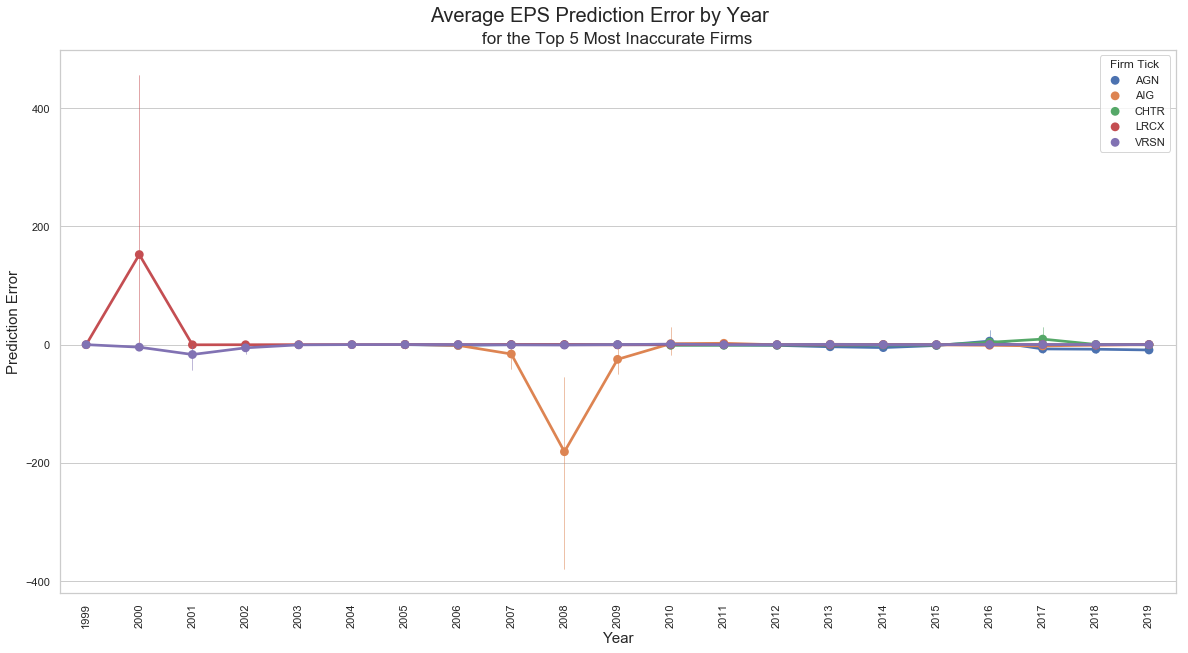

In [233]:
plt.figure(figsize = [20, 10])
sb.pointplot(data = diffs_top, x = diffs_top.term.dt.year, y = 'difference', hue = 'firm_tick',errwidth = 0.5)

plt.legend(title = 'Firm Tick')
plt.xticks(rotation = 'vertical')
plt.xlabel('Year')
plt.ylabel('Prediction Error')
plt.suptitle('Average EPS Prediction Error by Year', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)

plt.savefig(PATH_MULTIVARIATE + 'features-perror-year-firm.png')
plt.show();

**Observation 1:** Yet again, the 2 most noticeable outliers are the firm AIG in 2008 (optimistic forecasts), and LRCX in 2000 (pessimistic forecasts).

**Observation 2:** The 5 most inaccurate firms by prediction error are AGN, AIG, CHTR, LRCX, and VRSN. The same list as before.

**Observation 3:** VRSN is the most stable of the top 5 most inaccurate firms; it contains no outliers. Data for the firm CHTR shows up only in 2017.

> **Prediction Error by Quarter**

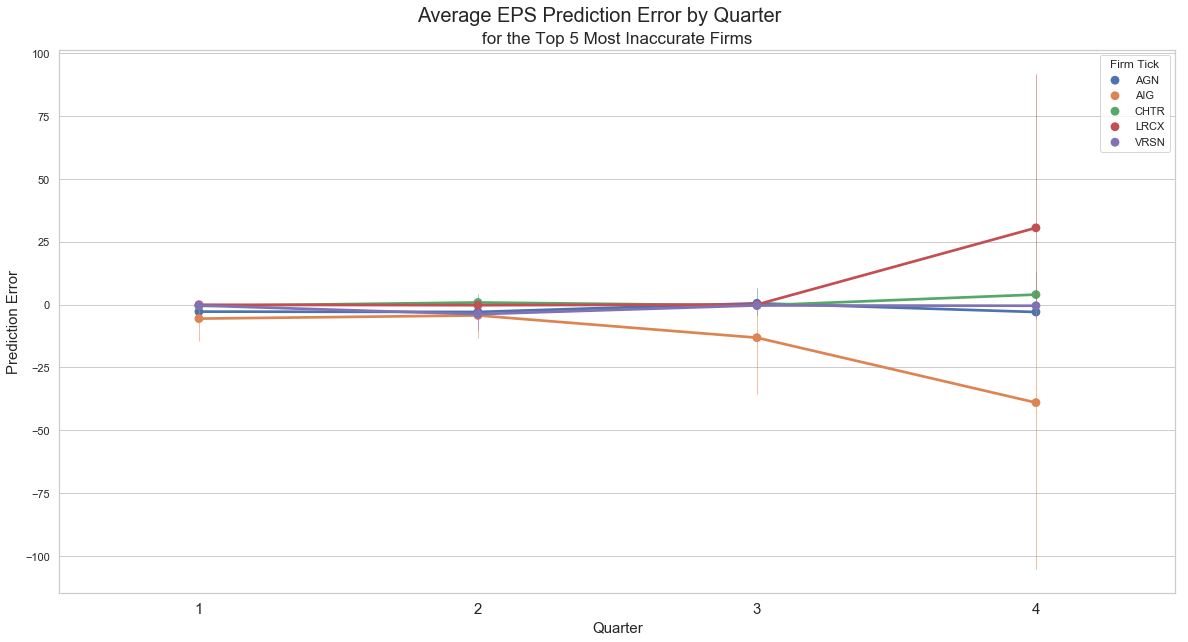

In [207]:
plt.figure(figsize = [20, 10])
sb.pointplot(data = diffs_top, x = diffs_top.term.dt.quarter, y = 'difference', hue = 'firm_tick',errwidth = 0.5)

plt.legend(title = 'Firm Tick')
plt.xlabel('Quarter')
plt.ylabel('Prediction Error')
plt.suptitle('Average EPS Prediction Error by Quarter', size = 20, y = .94)
plt.title('for the Top 5 Most Inaccurate Firms', size = 17)
plt.xticks(size = 15)

plt.savefig(PATH_MULTIVARIATE + 'features-perror-quarter-firm.png')
plt.show();

**Observation 1:** One most noticable outlier is AIG, which is, on average, the ***only outlier*** in Q3 of any given year.

**Observation 2:** The 5 most inaccurate firms by prediction error are AGN, AIG, CHTR, LRCX, and VRSN. The same list as generated through a yearly and term basis.

**Observation 3:** These 5 firms display relatively low prediction errors until Q4, where both LRCX and AIG "branch off" into opposite directions. This means that **forecasters, on average, are likely to be more inaccurate in their EPS forecasts in Q4 of any given year.**

**Observation 4:** VRSN is the most stable of the top 5 most inaccurate firms; it contains no outliers. Data for the firm CHTR shows up only in 2017.

# Conclusions <a id = "conclude"> </a>

**RESEARCH QUESTIONS RESTATED:**
- do forecasters' predictions become more accurate by the quarter?
- I generate "dumb EPS forecasts" by taking the rolling mean of the previous 2 actual EPS values before the current term (YYYYQQ). How do these "dumb EPS forecasts" compare to the experts' EPS forecasts?
- What differences emerge when analyzing the prediction error and percentage error of EPS forecasts? 
- For both the top most inaccurately predicted companies, do EPS forecasts show a pessimistic and/or optimistic view of their company value?


**Dumb Predictions**

- The technique that the Bloomberg forecasters used was much more effective than my method of predicting by using 2-quarter moving averages.

---

**Percentage Errors**

- The stripplots were useful in locating *outliers* more so than showing *trends.*


---
**Prediction Errors**

- research AIG, LRCX, GM, BKNG, CHTR, and NVR, and articles on their forecasts

- are the prediction error charts consistent with the average percentage error charts?

- **forecasters, on average, are likely to be more inaccurate in their EPS forecasts in Q4 of any given year.**

- All patterns shown in the Actual vs. Forecasted pointplots are consistent with the stripplot at the beginning of the bivariate stage. Actual EPS has the most outliers, and there a few "spikes" in the pointplots where actual EPS significantly veers away from the forecasted EPS trend line.

Apparently, the top 5 most inaccurate firms are different when looking at percentage error and prediction error.

The charts with Firm IDs on the x-axis aren't useful, but they were a good visual aid for spotting Firm IDs that have consistently shown to be outliers. (that is, the most inaccurate companies)

---

The EOD graph could be used to make correlations with EPS forecasts and how the firm is getting "richer" overtime.

---

Compare bivariate prediction error patterns to **multivariate forecasted and actual EPS by term**, and **percentage error** charts
- by term, quarter, and year

Why did EOD prices show a general positive trend from 2009? EOD prices see a trough from 2007 - 2009: the great Recession. How did the great Recession play a role in the economic restabilization after the end the recession in the year 2009? Research.

**Key takeaways:**

The later the quarter, the more optimistic forecasters become in their predictions. I draw the connection that this is because people need time to familiarize themselves with the current year’s stock market dynamics to create more confident predictions. Each new quarter brings the familiarity of previous mistakes made in previous quarters of that year. This, combined with building familiarity of the year as it advances, could be two psychological causes to this tendency to become more optimistic over EPS forecasted in any given year.


***EPS forecasts have become more inaccurate in the more recent years, starting from 2014.***